<div style="
    background-color: #1a1a1a; 
    padding: 40px; 
    border-radius: 20px; 
    text-align: center; 
    font-family: 'Garamond', serif; 
    box-shadow: 0 6px 18px rgba(0, 0, 0, 0.8); 
    color: white;">
    

<div style="
        font-size: 1.2em; 
        color: #BFA86A; 
        font-weight: bold; 
        letter-spacing: 2px;">
        ✦ A CINEMATIC EXPERIENCE ✦
</div>   

<h1 style="
        font-size: 3.2em; 
        margin: 20px 0; 
        color: #E3D9B6; 
        font-weight: bold; 
        text-transform: uppercase;">
        Money, Money, Movies
</h1>    

<h2 style="
        font-size: 2em; 
        margin: 10px 0; 
        font-style: italic; 
        color: #D4C593;">
        The Secrets of Movies' Box Office Success
</h2>

    
<div style="
        font-size: 1em; 
        color: #999; 
        margin-top: 20px;">
        🎥 A Production by <strong style="color: #E3D9B6;">C1n3mada Studios</strong>
</div>
</div>


### Importing Libraries

In [1]:
import ast
import warnings
from collections import Counter
from itertools import chain

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from IPython.display import clear_output
from ipywidgets import interact, widgets
from scipy import stats
from scipy.stats import f_oneway, pearsonr, spearmanr
from statsmodels.formula.api import ols
from tabulate import tabulate

from src.utils.evaluation_utils import validate_dataframes

from src.utils.analysis_utils import (
    genre_correlation,
    extract_names,
    extract_first_country,
    get_movies_with_genres,
    calculate_count_revenue_correlation
)

from src.utils.data_utils import (
    prepare_df_for_rating_analysis,
    prepare_df_for_genre_analysis,
    prepare_df_for_budget_analysis,
    prepare_df_for_country_language_analysis,
    prepare_df_country_language_extended,
    prepare_director_data,
    prepare_seasonal_data,
)

from src.utils.plot_utils import (
    plot_genre_barplot,
    plot_distribution,
    plot_scatter,
    plot_budget_revenue_trend,
    plot_correlation_heatmap,
    plot_genre_correlation_bars,
    create_animated_treemap,
    revenue_formatter,
)

# Plot configurations
sns.set_theme(style="white", palette="colorblind")

warnings.filterwarnings("ignore")
%matplotlib inline
# auto-reload modules
%load_ext autoreload
%autoreload 2

### Loading the Dataset

In [2]:
# load the dataset
PATH = "data/processed/movies_processed.csv"
df = pd.read_csv(PATH)

df.head()

wiki_movie_id freebase_movie_id                movie_name  \
0         975900         /m/03vyhn            Ghosts of Mars   
1       10408933        /m/02qc0j7  Alexander's Ragtime Band   
2         171005         /m/016ywb                   Henry V   
3          77856          /m/0kcn7              Mary Poppins   
4         612710         /m/02wjqm            New Rose Hotel   

  movie_release_date  movie_box_office_revenue  movie_runtime  \
0         2001-08-24                14010832.0           98.0   
1         1938-08-16                 3600000.0          106.0   
2         1989-11-08                10161099.0          137.0   
3         1964-08-27               102272727.0          139.0   
4         1999-10-01                   21521.0           92.0   

                        movie_languages  \
0  [('/m/02h40lc', 'English Language')]   
1  [('/m/02h40lc', 'English Language')]   
2  [('/m/02h40lc', 'English Language')]   
3  [('/m/02h40lc', 'English Language')]   
4  [('/m/02h40lc', 'English Language')]   

                               movie_countries  \
0  [('/m/09c7w0', 'United States of America')]   
1  [('/m/09c7w0', 'United States of America')]   
2             [('/m/07ssc', 'United Kingdom')]   
3  [('/m/09c7w0', 'United States of America')]   
4  [('/m/09c7w0', 'United States of America')]   

                                        movie_genres  release_year  ...  \
0  [('/m/01jfsb', 'Thriller'), ('/m/06n90', 'Scie...        2001.0  ...   
1  [('/m/04t36', 'Musical'), ('/m/01z4y', 'Comedy...        1938.0  ...   
2  [('/m/04xvh5', 'Costume drama'), ('/m/082gq', ...        1989.0  ...   
3  [('/m/0hj3myq', "Children's/Family"), ('/m/04t...        1964.0  ...   
4  [('/m/01jfsb', 'Thriller'), ('/m/06n90', 'Scie...        1999.0  ...   

   combined_revenue  release_month release_day              primaryTitle  \
0        14010832.0            8.0        24.0            Ghosts of Mars   
1         3600000.0            8.0        16.0  Alexander's Ragtime Band   
2        10161099.0           11.0         8.0                   Henry V   
3       102272727.0            8.0        27.0              Mary Poppins   
4           21521.0           10.0         1.0                       NaN   

   startYear  averageRating  numVotes          director  inflated_revenue  \
0     2001.0            4.9   58868.0    John Carpenter      1.899115e+07   
1     1938.0            6.8    2357.0        Henry King      6.131466e+07   
2     1989.0            7.5   32088.0   Kenneth Branagh      1.967252e+07   
3     1964.0            7.8  189183.0  Robert Stevenson      7.913870e+08   
4        NaN            0.0       0.0           Unknown      3.100822e+04   

   inflated_budget  
0     3.795294e+07  
1     3.406370e+07  
2     1.742456e+07  
3     4.642804e+07  
4              NaN  

[5 rows x 23 columns]

# Movie 1: Echo 📢 
## How does a movie’s IMDb rating relate to its box office revenue?

The film industry is a complex ecosystem where various factors contribute to a movie’s success. Among these factors, audience reception and financial performance are two critical metrics. This analysis aims to explore the relationship between a movie’s IMDb rating—a reflection of audience and critic reception—and its box office revenue. Understanding this relationship can provide valuable insights for filmmakers, producers, investors as well as researchers such as ourselves.

**🏗️ Analysis Structure:**

- **Data Preparation**
  - **Columns:** We use `averageRating`, `inflated_revenue`, `numVotes`, and `movie_genres`.
  - **Missing Data:** Entries with missing values are removed.
  - **Duplicates:** Duplicate entries are removed.
  - **Genres:** Genre strings are converted to lists.
- **Exploratory Data Analysis (EDA)**
  - **Descriptive Statistics:** We examine the distributions of ratings, revenue, and votes.
  - **Genre Counts:** We analyze and visualize the frequency of each genre.
  - **Rating Distribution:** A histogram displays the distribution of IMDb ratings.
  - **Revenue Distribution:**  Histograms show revenue distribution, both raw and log-transformed.
  - **Ratings vs. Revenue:** A scatter plot explores the relationship between IMDb ratings and log-transformed revenue.
- **Correlation Analysis**
  - **Pearson & Spearman:** We compute both correlation coefficients between ratings and revenue.
  - **Correlation Matrix:** A heatmap visualizes the relationships between ratings, revenue, and votes.
- **Genre-Specific Correlations**
  - **By Genre:** We compute Pearson and Spearman correlations for each genre (ratings vs. log-transformed revenue).
  - **Visual Comparison:** A bar plot compares correlations across genres.
- **Regression Analysis**
  - **Simple Regression:** We model log-transformed revenue as a function of IMDb ratings.
  - **Multiple Regression:** We add log-transformed vote counts to the regression model.
  - **3D Visualization:** We visualize the multiple regression plane.
  - **Regression Plot:** We visualize the regression line against the data.
  - **Hexbin Plot:** A hexbin plot with regression line provides a clearer view of the relationship, handling data density effectively.

### Data Preparation

#### Relevant Columns
For this analysis, we’ll focus on the following columns:
*	`averageRating`: The IMDb rating of the movie.
*	`inflated_revenue`: The box office revenue adjusted for inflation.
*	`numVotes`: The number of votes the movie received on IMDb.
*   `movie_genres`: The genres of the movie.

In [4]:
# data preparation: select necessary columns, drop missing values, handle duplicates
df_rating = prepare_df_for_rating_analysis(df)

### Exploratory Data Analysis

<div class="alert alert-success"> 💭 <strong>Idea:</strong> 

- Understand the distribution of IMDb ratings. 
- Analyze the distribution of box office revenue. 
- Explore the relationship between IMDb ratings and box office revenue. 
- Investigate the number of movies per genre. 
</div> <div class="alert alert-warning"> 🛠️ <strong>Methods:</strong>

 - Use descriptive statistics to summarize the data. 
 - Visualize the distribution of IMDb ratings using histograms. 
 - Visualize the distribution of box office revenue using histograms with a logarithmic scale. 
 - Use bar plots to show the number of movies per genre. 
 - Use scatter plots to explore the relationship between IMDb ratings and box office revenue. </div>

#### Summary Statistics

In [5]:
df_rating.describe()

averageRating  inflated_revenue      numVotes
count    7892.000000      7.892000e+03  7.892000e+03
mean        6.429726      8.712150e+07  7.893043e+04
std         0.969148      2.189459e+08  1.778774e+05
min         1.600000      1.108173e+03  7.400000e+01
25%         5.900000      7.114762e+06  5.778750e+03
50%         6.500000      2.571579e+07  2.028500e+04
75%         7.100000      8.179225e+07  7.315275e+04
max         9.300000      6.941575e+09  2.959489e+06

#### Number of Movies per Genre

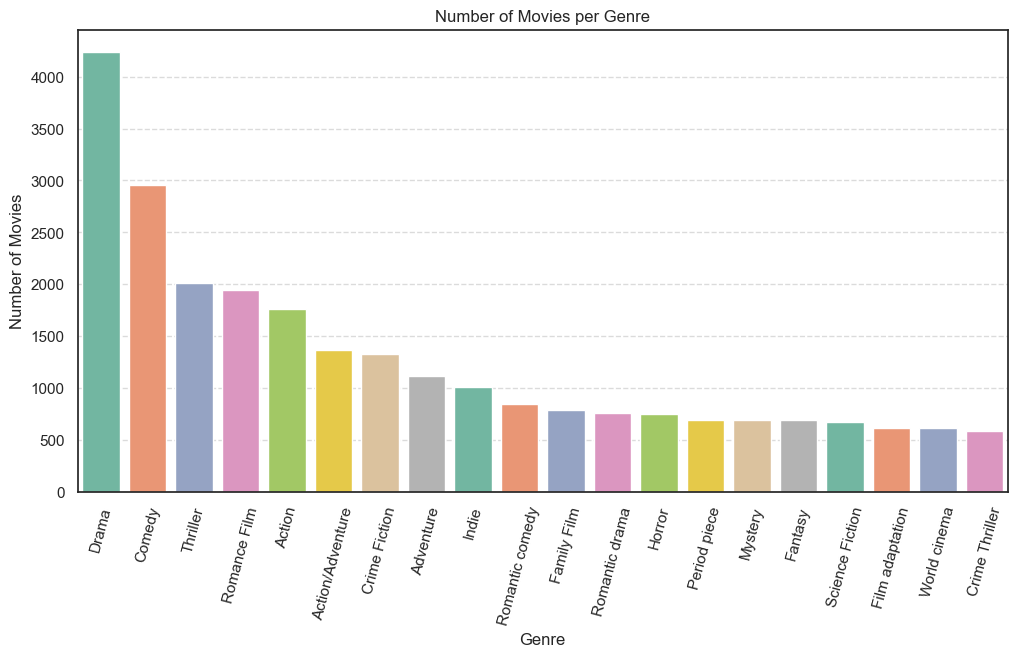

In [6]:
# Explode the genres_list to count each genre separately
genre_counts = df_rating.explode("genres_list")["genres_list"].value_counts()

# get the most common 20 genres
genre_counts_top20 = genre_counts.head(20)

plot_genre_barplot(genre_counts_top20, "Number of Movies per Genre")

#### Distribution of IMDb Ratings

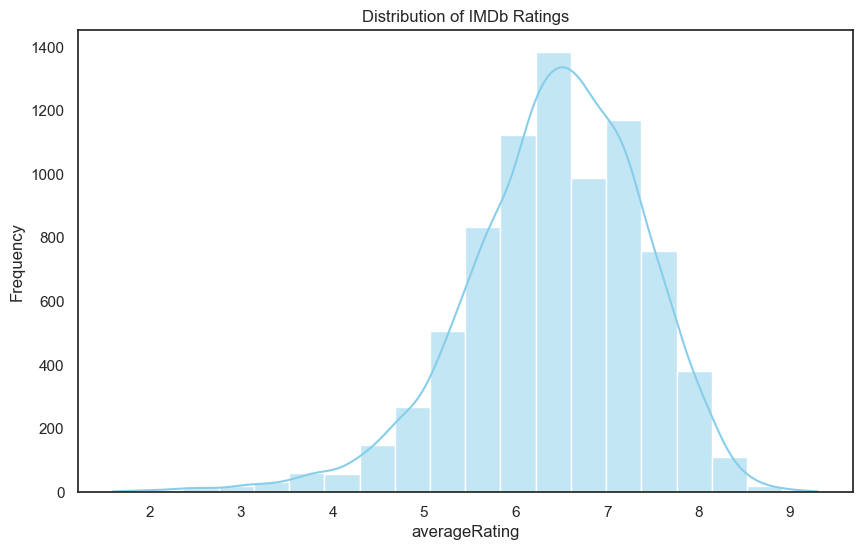

In [7]:
# we plot the distribution of the IMDb ratings
plot_distribution(df_rating, "averageRating", title="Distribution of IMDb Ratings")

#### Distribution of Box Office Revenue
Due to the wide range of revenues, we’ll use a logarithmic scale.

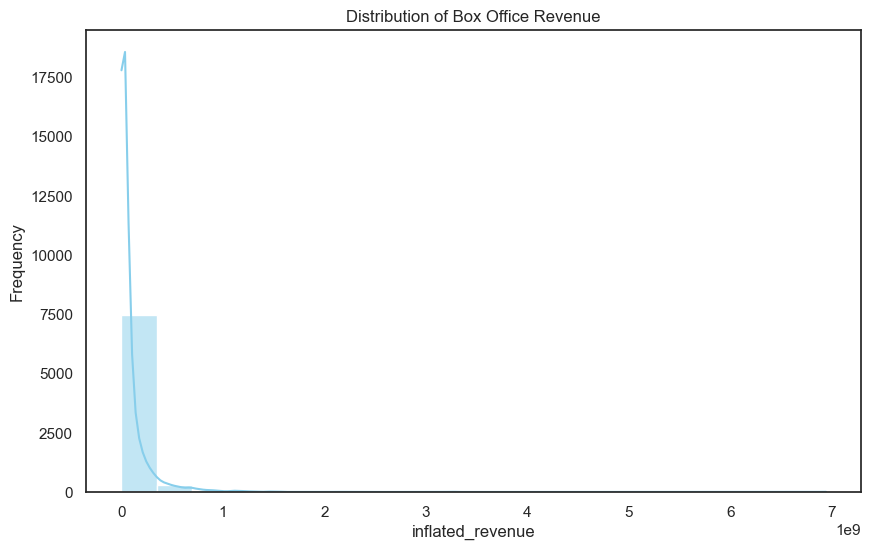

In [8]:
# then we plot the distribution of the box office revenue
plot_distribution(
    df_rating, "inflated_revenue", title="Distribution of Box Office Revenue"
)

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - For our analysis, we log-transformed the movie revenue data (using log base 10) for several reasons:
    - **Distribution Properties**: As we can see from the Distribution of the Box Office Revenue plot above, movie revenues show a right-skewed distribution with a long tail of high-revenue outliers. Log transformation helps normalize this distribution.
    - **Statistical Considerations**: The transformation helps meet OLS regression assumptions by:
      - Making the relationship more linear
      - Normalizing the distribution of errors

</div>

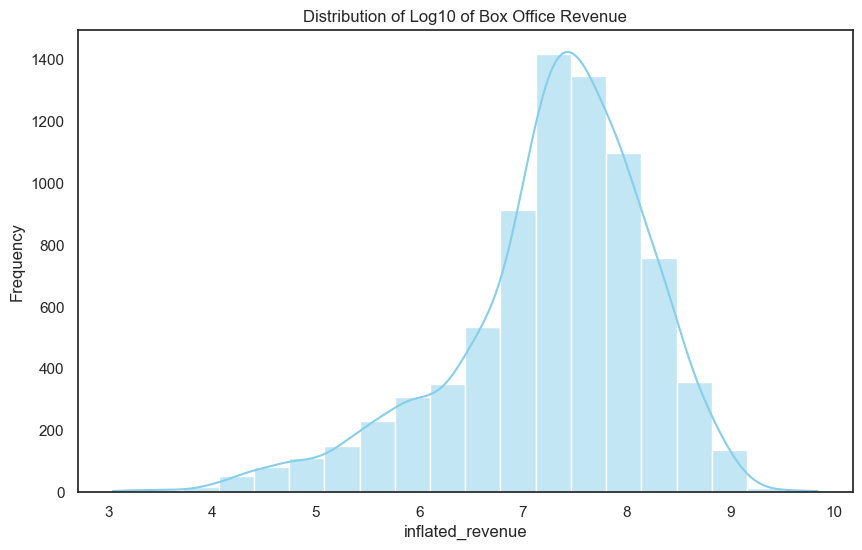

In [9]:
# the log10 transformation of the box office revenue is more normally distributed
plot_distribution(
    df_rating,
    "inflated_revenue",
    title="Distribution of Log10 of Box Office Revenue",
    transformation=np.log10,
)

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - As shown in the plots above, the log transformation provides a more normally distributed dependent variable.

</div>

#### Scatter Plot of IMDb Ratings vs. Box Office Revenue

<div class="alert alert-success"> 💭 <strong>Idea:</strong> 

  - The scatter plot shows a lot of dispersion. To better visualize the data, we’ll apply a logarithmic transformation to the revenue.

</div>

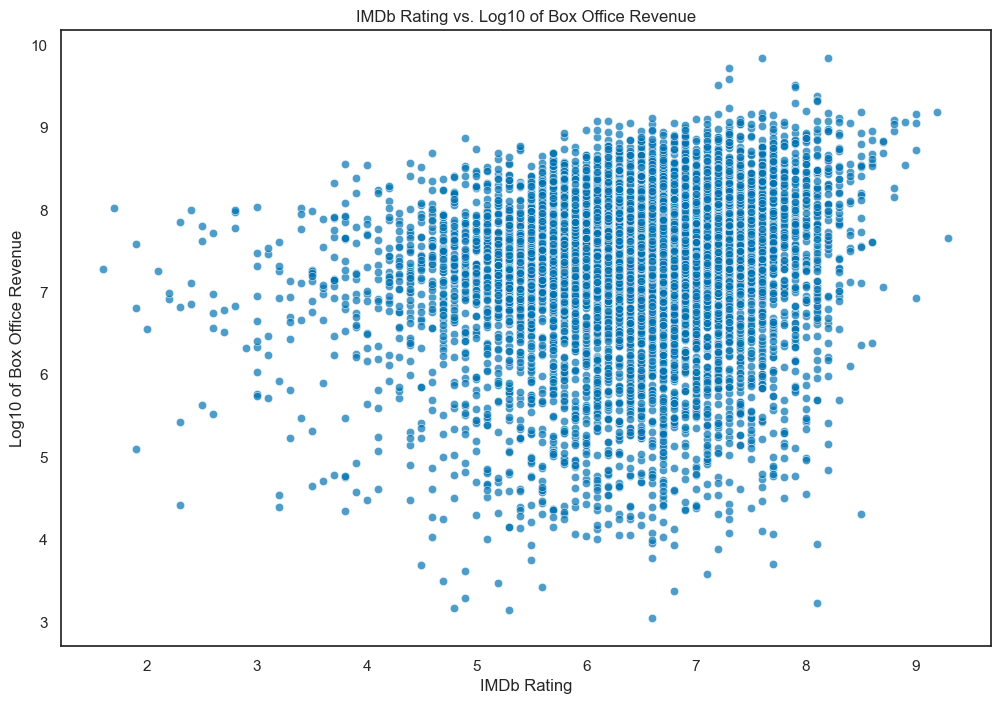

In [11]:
# scatter plot of IMDb Rating vs. Log10 of Box Office Revenue
plot_scatter(
    df_rating,
    "averageRating",
    "inflated_revenue",
    title="IMDb Rating vs. Log10 of Box Office Revenue",
    xlabel="IMDb Rating",
    ylabel="Log10 of Box Office Revenue",
    transformation=np.log10,
)

### Correlation Analysis


Correlation analysis helps in understanding the strength and direction of the relationship between two variables. In this section, we will analyze the correlation between IMDb ratings and box office revenue.

<div class="alert alert-success"> 💭 <strong>Idea:</strong> 

- Determine the strength and direction of the relationship between IMDb ratings and box office revenue. 
- Identify if higher ratings are associated with higher revenues. 
</div> 

<div class="alert alert-warning"> 🛠️ <strong>Methods:</strong> 

- Calculate the Pearson and spearman correlation coefficient between IMDb ratings and box office revenue. 
- Visualize the correlation using a heatmap. 
</div>

#### Calculating the Correlation Coefficient

In [12]:
# Pearson correlation
corr_pearson = df_rating[["averageRating", "inflated_revenue"]].corr(method="pearson")
print("Pearson Correlation Coefficient:")
print(corr_pearson)

# Spearman correlation
corr_spearman = df_rating[["averageRating", "inflated_revenue"]].corr(method="spearman")
print("\nSpearman Correlation Coefficient:")
print(corr_spearman)

Pearson Correlation Coefficient:
                  averageRating  inflated_revenue
averageRating          1.000000          0.180228
inflated_revenue       0.180228          1.000000

Spearman Correlation Coefficient:
                  averageRating  inflated_revenue
averageRating          1.000000          0.157229
inflated_revenue       0.157229          1.000000


#### Heatmap of Correlation Matrix

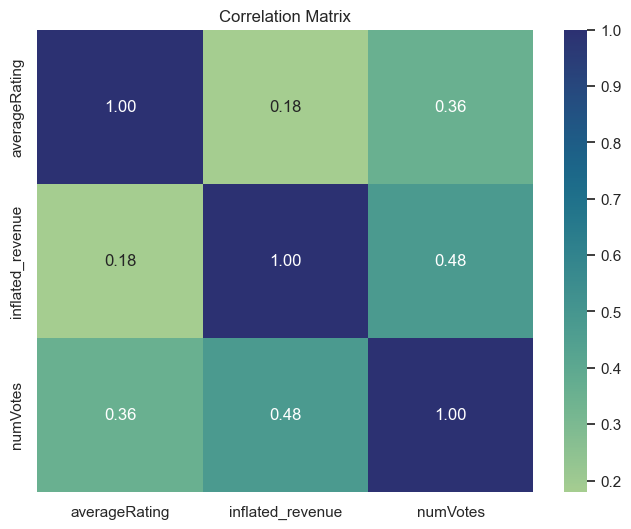

In [14]:
# correlation heatmap
plot_correlation_heatmap(df_rating, ["averageRating", "inflated_revenue", "numVotes"])

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - The Pearson correlation coefficient between IMDb rating and inflated revenue is 0.189, indicating a weak positive linear relationship.
  - The Spearman correlation coefficient is 0.157, suggests a weak monotonic relationship.

</div>

### Genre-wise Correlation

<div class="alert alert-success"> 💭 <strong>Idea:</strong> 

Different genres might exhibit different relationships between ratings and revenue. As for different genres audiences might have different biases in rating movies. For instance, horror movies might get lower ratings due to the affects they have on the audience, but they might still be successful in terms of revenue.
</div> 

#### Calculate Correlations by Genre

In [15]:
# get top 20 genres
genre_counts_filtered = genre_counts.head(20)
genres = genre_counts_filtered.index.tolist()
genre_corrs = pd.DataFrame([genre_correlation(df_rating, genre) for genre in genres])
genre_corrs.set_index("Genre", inplace=True)
genre_corrs

Pearson  Spearman
Genre                               
Drama             0.230902  0.230783
Comedy            0.186471  0.185382
Thriller          0.230736  0.248662
Romance Film      0.183884  0.176662
Action            0.304330  0.323150
Action/Adventure  0.299375  0.302421
Crime Fiction     0.208187  0.228940
Adventure         0.277862  0.310489
Indie             0.237353  0.251666
Romantic comedy   0.229253  0.212764
Family Film       0.255518  0.297464
Romantic drama    0.184314  0.177087
Horror            0.242278  0.229773
Period piece      0.376940  0.412148
Mystery           0.247740  0.267792
Fantasy           0.255571  0.269186
Science Fiction   0.296879  0.298583
Film adaptation   0.400542  0.408783
World cinema      0.062458  0.066823
Crime Thriller    0.308922  0.302500

#### Visualizing Genre-wise Correlations

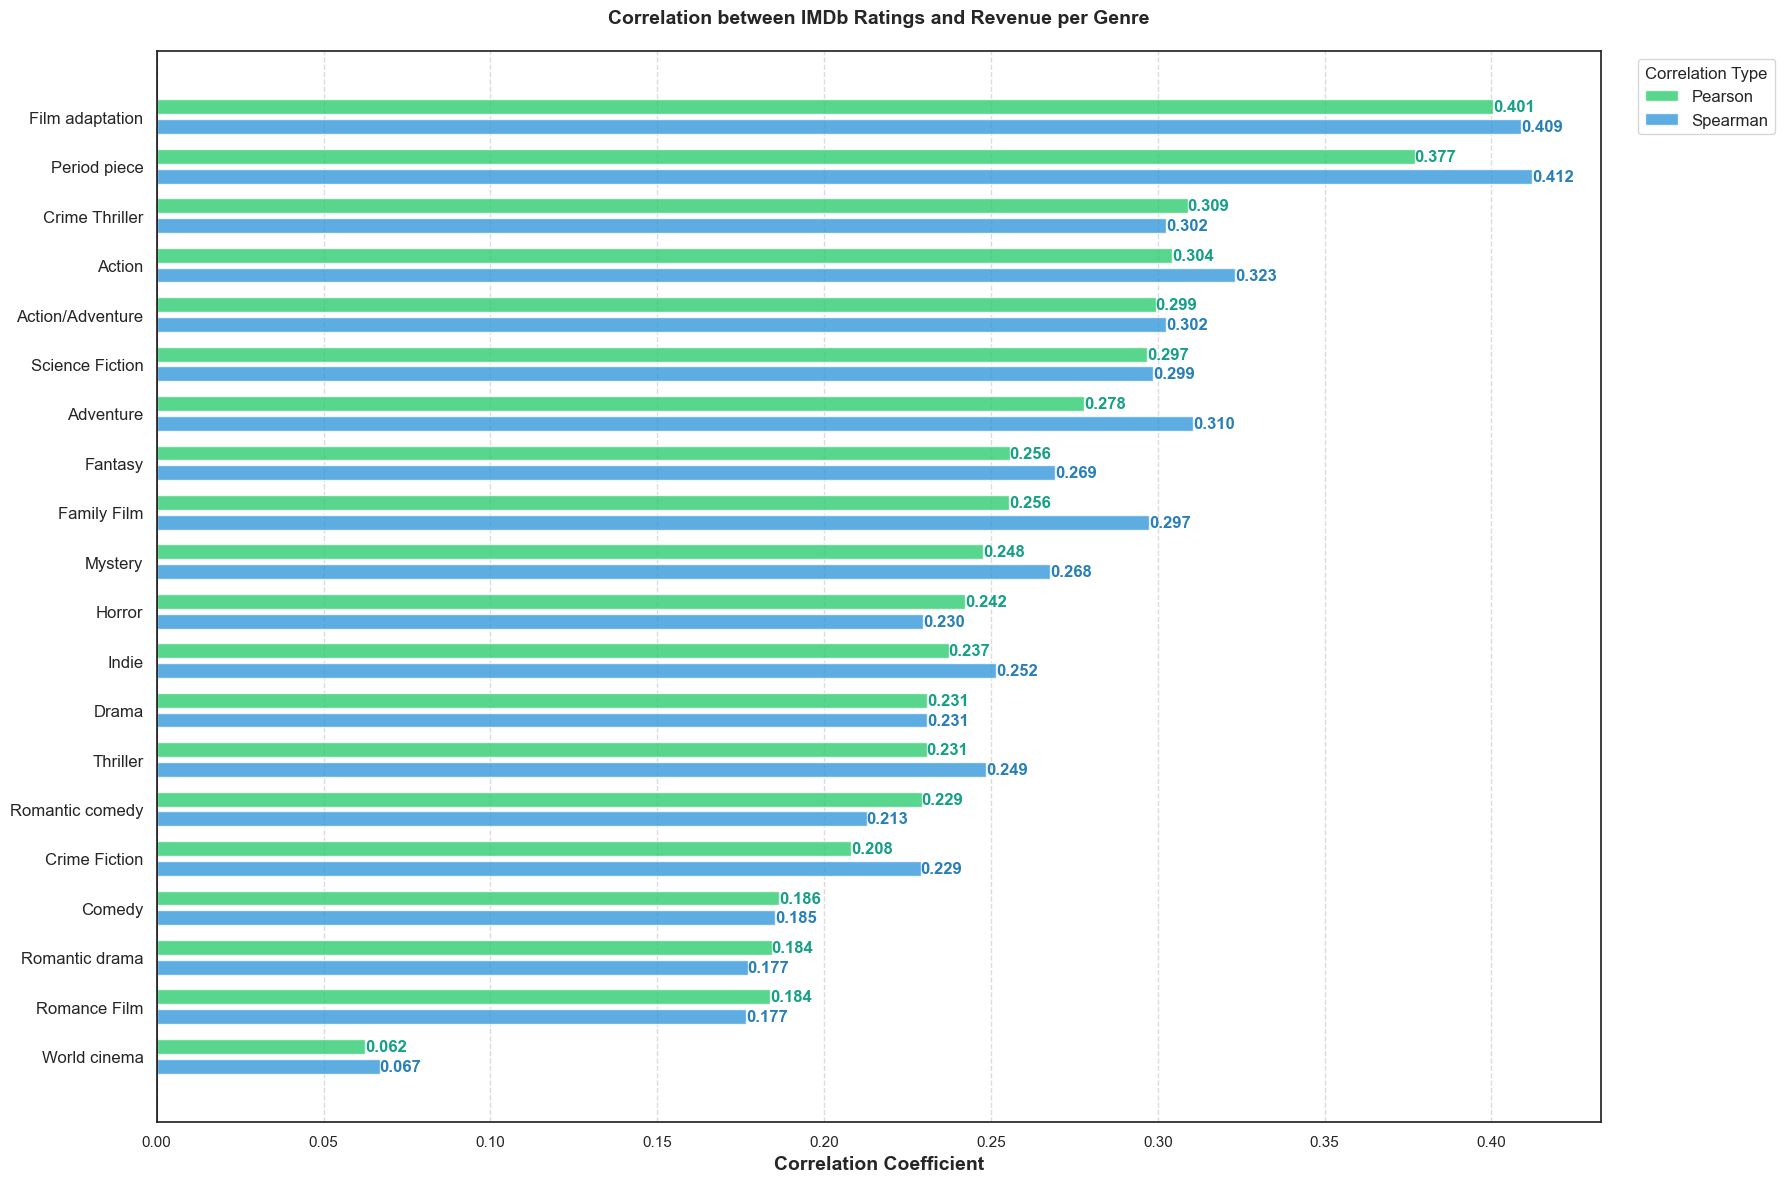

In [16]:
plot_genre_correlation_bars(
    genre_corrs, title="Correlation between IMDb Ratings and Revenue per Genre"
)

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - Among the genres, some exhibit a stronger correlation between IMDb rating and box office revenue than others.
  - For example, Action movies have a positive correlation of 0.33, while World cinema movies have a near negligible correlation of 0.05.
  - Although the correlation values vary across genres, there is no genre with a negative correlation or a very strong positive correlation between IMDb rating and box office revenue.

</div>

### Regression Analysis

<div class="alert alert-success"> 💭 <strong>Idea:</strong>

 - We build a regression model to predict box office revenue based on IMDb ratings. 
 - The predictive power of IMDb ratings can be assessed on box office revenue. 
 </div> 
 <div class="alert alert-warning"> 🛠️ <strong>Methods:</strong> 
 
 - Use linear regression to model the relationship between IMDb ratings and box office revenue.
  - Evaluate the model's performance using metrics such as R-squared and P values. 
  - Visualize the regression line and residuals. 
  </div>

In [17]:
# get top 20 genres
genre_counts_filtered = genre_counts.head(20)
genres = genre_counts_filtered.index.tolist()
genre_corrs = pd.DataFrame([genre_correlation(df_rating, genre) for genre in genres])
genre_corrs.set_index("Genre", inplace=True)
genre_corrs

Pearson  Spearman
Genre                               
Drama             0.230902  0.230783
Comedy            0.186471  0.185382
Thriller          0.230736  0.248662
Romance Film      0.183884  0.176662
Action            0.304330  0.323150
Action/Adventure  0.299375  0.302421
Crime Fiction     0.208187  0.228940
Adventure         0.277862  0.310489
Indie             0.237353  0.251666
Romantic comedy   0.229253  0.212764
Family Film       0.255518  0.297464
Romantic drama    0.184314  0.177087
Horror            0.242278  0.229773
Period piece      0.376940  0.412148
Mystery           0.247740  0.267792
Fantasy           0.255571  0.269186
Science Fiction   0.296879  0.298583
Film adaptation   0.400542  0.408783
World cinema      0.062458  0.066823
Crime Thriller    0.308922  0.302500

#### Linear Regression Model

In [18]:
# Prepare the df_rating
X = df_rating[["averageRating"]]
y = np.log10(df_rating["inflated_revenue"])  # Log-transform the revenue

# Add a constant term for the intercept
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       inflated_revenue   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     202.6
Date:                Fri, 20 Dec 2024   Prob (F-statistic):           2.06e-45
Time:                        20:26:36   Log-Likelihood:                -10716.
No. Observations:                7892   AIC:                         2.144e+04
Df Residuals:                    7890   BIC:                         2.145e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             6.2724      0.071     88.268

##### Multiple Linear Regression: IMDb Rating and Number of Votes vs. Box Office Revenue

In [19]:
# Prepare the df_rating
X_multi = df_rating[["averageRating", "numVotes"]]
y_multi = np.log10(df_rating["inflated_revenue"])

# Log-transform numVotes to normalize
X_multi["log_numVotes"] = np.log10(X_multi["numVotes"])

# Add a constant term
X_multi = sm.add_constant(X_multi[["averageRating", "log_numVotes"]])

# Fit the model
model_multi = sm.OLS(y_multi, X_multi).fit()

# Model summary
print(model_multi.summary())

                            OLS Regression Results                            
Dep. Variable:       inflated_revenue   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     1986.
Date:                Fri, 20 Dec 2024   Prob (F-statistic):               0.00
Time:                        20:26:39   Log-Likelihood:                -9206.8
No. Observations:                7892   AIC:                         1.842e+04
Df Residuals:                    7889   BIC:                         1.844e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.3839      0.066     65.974

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - **Model Improvement:** Including log-transformed vote count significantly enhanced the model, with R² rising from 0.025 (rating-only) to 0.335, which shows vote count as a stronger revenue predictor than ratings alone.
  - **Surprising Rating Effect Shift:** Controlling for votes, the rating coefficient turns slightly negative (-0.0537) compared to its positive effect (0.1556) in the single predictor model. This indicates that higher ratings don’t necessarily increase revenue once popularity (votes) is considered. (Said's Note: This is a surprising result that may effect our other analysis in this section as well)
  - **Vote Count Impact**: The positive coefficient for log_numVotes (0.7506, p < 0.001) suggests a 10% vote count increase correlates with an 7.5% revenue boost, that highlights vote count as the primary revenue driver over rating quality.

</div>

#### Regression Plot

It is hard to interpret the regression scatter plot due to the high density of points. We can use a hexbin plot to visualize the relationship better.

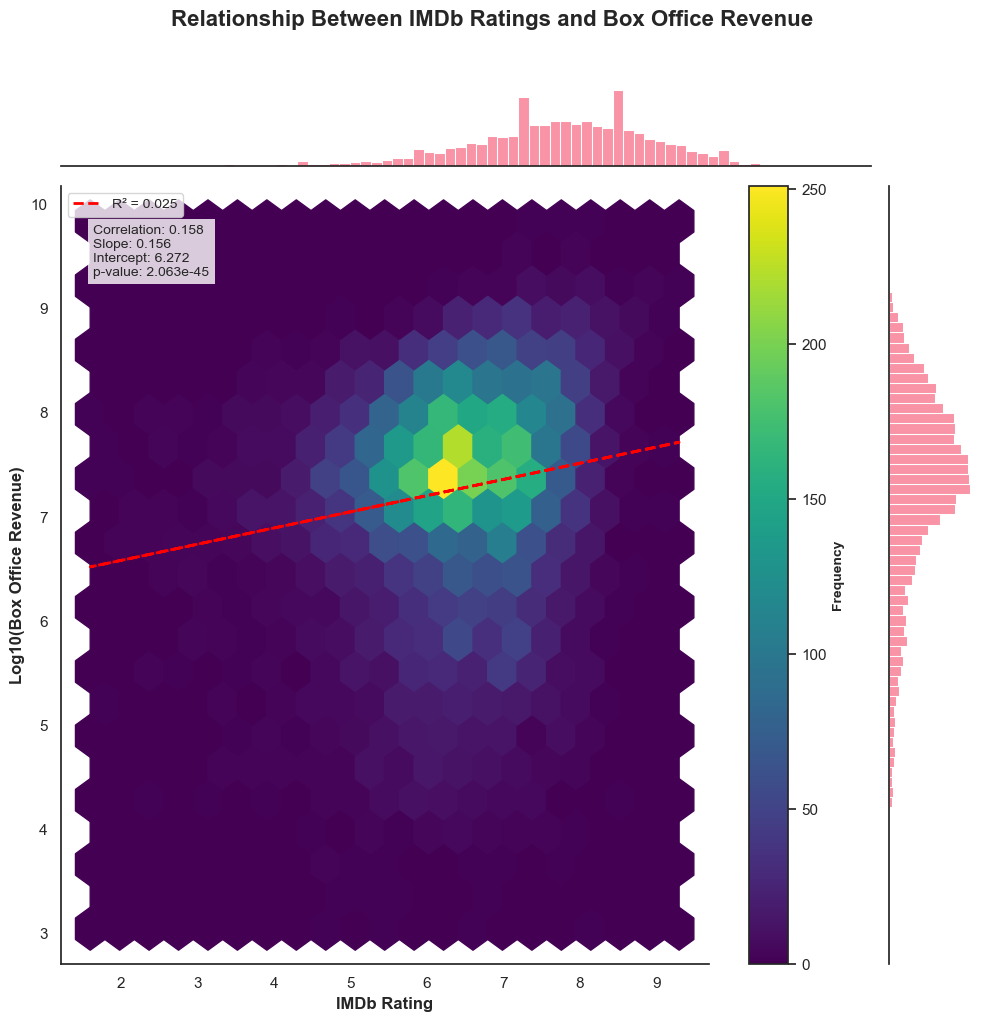

In [22]:
# Create figure with custom size and style
plt.style.use("seaborn-v0_8-ticks")
sns.set_palette("husl")

# Creation of the joint plot
g = sns.jointplot(
    data=df_rating,
    x="averageRating",
    y=np.log10(df_rating["inflated_revenue"]),
    kind="hex",
    height=10,  # figure size
    ratio=8,  # the ratio of main plot to marginal plots
    marginal_kws=dict(bins=70),  # More bins in marginal plots
    joint_kws=dict(gridsize=20),  # More hexbins for better resolution
    palette="viridis",  # Modern color palette
)

# Add trend line
x = df_rating["averageRating"]
y = np.log10(df_rating["inflated_revenue"])
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
line = slope * x + intercept
g.ax_joint.plot(
    x, line, color="red", linestyle="--", linewidth=2, label=f"R² = {r_value**2:.3f}"
)

# Customize the plot
g.figure.suptitle(
    "Relationship Between IMDb Ratings and Box Office Revenue",
    y=1.02,
    fontsize=16,
    fontweight="bold",
)

# Add descriptive labels
g.ax_joint.set_xlabel("IMDb Rating", fontsize=12, fontweight="bold")
g.ax_joint.set_ylabel("Log10(Box Office Revenue)", fontsize=12, fontweight="bold")

# Add legend with modern color
g.ax_joint.legend(loc="upper left", fontsize=10, frameon=True, facecolor="white")


# Add text box with statistics
stats_text = (
    f"Correlation: {r_value:.3f}\n"
    f"Slope: {slope:.3f}\n"
    f"Intercept: {intercept:.3f}\n"
    f"p-value: {p_value:.3e}"
)
g.ax_joint.text(
    0.05,
    0.95,
    stats_text,
    transform=g.ax_joint.transAxes,
    bbox=dict(facecolor="white", alpha=0.8, edgecolor="none"),
    fontsize=10,
    verticalalignment="top",
)

# Customize hexbin appearance
g.ax_joint.collections[0].set_cmap("viridis")  # Modern colormap


# Add color bar
cbar = g.figure.colorbar(g.ax_joint.collections[0], ax=g.ax_joint, label="Count")
cbar.set_label("Frequency", fontsize=10, fontweight="bold")

# Tight layout
plt.tight_layout()

# Show the plot
plt.show()

<div class="alert alert-info"> 📢 <strong>Discussion:</strong> 

- The regression analysis provides a quantitative measure of the relationship between IMDb ratings and box office revenue.
- The visualization, including the regression line and hexbin plot, helps in understanding the distribution of data points and the fit of the regression model. 
- The color bar provides additional context by showing the frequency of data points in different regions of the plot.
- The slope of the regression line shows the rate at which box office revenue changes with respect to IMDb ratings. And since the slope is not significant, we can say that the relationship is weak.
- The p-value indicates the statistical significance of the relationship, with a low p-value suggesting that the observed relationship is unlikely to be due to chance. 
 </div>

# Movie 2: Tongues 🗣 
## How do the language and country of a movie influence its box office revenue?

This analysis aims to explore the importance of a movie's primary language and release country, as well as the correlation between these two aspects. Additionally, it wants to show whether movies with more than one original language achieve more success.

**🏗️ Analysis Structure:**

- **Data Preparation**
- **Exploratory Data Analysis**
- **Language Influence**
  - Top-n Languages and Box Office Revenue
  - Top-n Languages and Box Office Revenue with Threshold
  - Average Box Office Revenue per Language over the Years
  - Regression Analysis
  - ANOVA
- **Multilingual Movies**
- **Country Influence**
  - Average Box Office Revenue on the Map
  - Top-n Countries and Box Office Revenue
  - Top-n Countries and Box Office Revenue with Threshold
  - Regression Analysis
  - ANOVA


### Data Preparation

A specifically prepared dataframe is used:
- `df_movie_country_language`: Dataframe used for the country and language analysis

It contains the following columns:
- `movie_name`: Name of the movie
- `movie_languages`: Languages that are listed for the movie
- `movie_countries`: Countries that are listed for the movie, the first one is the main one
- `inflated_revenue`: Box office revenue after inflation adjustment
- `release_year`: Year in which the movie was released
- `log_revenue`: Log of the box office revenue (after inflation adjustment)


In [23]:
# create the data for the current analysis
df_movie_country_language = prepare_df_for_country_language_analysis(df)
# check the created dataframe
print("Number of rows:", df_movie_country_language.shape[0])
print(
    f"Percentage of retained rows from original dataframe: {np.round(df_movie_country_language.shape[0] / df.shape[0] * 100, 2)} %"
)
df_movie_country_language.head()

Number of rows: 9152
Percentage of retained rows from original dataframe: 95.98 %


movie_name                       movie_languages  \
0            Ghosts of Mars  [('/m/02h40lc', 'English Language')]   
1  Alexander's Ragtime Band  [('/m/02h40lc', 'English Language')]   
2                   Henry V  [('/m/02h40lc', 'English Language')]   
3              Mary Poppins  [('/m/02h40lc', 'English Language')]   
4            New Rose Hotel  [('/m/02h40lc', 'English Language')]   

                               movie_countries  inflated_revenue  \
0  [('/m/09c7w0', 'United States of America')]      1.899115e+07   
1  [('/m/09c7w0', 'United States of America')]      6.131466e+07   
2             [('/m/07ssc', 'United Kingdom')]      1.967252e+07   
3  [('/m/09c7w0', 'United States of America')]      7.913870e+08   
4  [('/m/09c7w0', 'United States of America')]      3.100822e+04   

   release_year  log_revenue  
0          2001     7.278551  
1          1938     7.787564  
2          1989     7.293860  
3          1964     8.898389  
4          1999     4.491477

### Exploratory Data Analysis

<div class="alert alert-success">

  💭 <strong>Idea:</strong>

  - Analyse the number of countries and languages in the dataset
  - Check which ones are most common ones
  
</div>

<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>
  - Extract the country and language names and print the absolute frequency for the most common ones
  - Print the total number of different countries and languages
  - Visualisation: Plot the most common countries and languages in a bar chart
</div>

In [24]:
# extract all possible countries and languages
countries = extract_names(df_movie_country_language["movie_countries"])
languages = extract_names(df_movie_country_language["movie_languages"])

# count
countries_count = pd.Series(countries).value_counts()
languages_count = pd.Series(languages).value_counts()

# print the top 10 countries and languages
print(f"Top 10 countries:\n{countries_count.head(10)}")
print(f"Top 10 languages:\n{languages_count.head(10)}")

Top 10 countries:
United States of America    7515
United Kingdom              1093
France                       625
Germany                      514
Canada                       380
South Korea                  246
Japan                        231
Australia                    209
Italy                        188
India                        128
Name: count, dtype: int64
Top 10 languages:
English Language     8288
French Language       642
Spanish Language      484
German Language       308
Italian Language      277
Korean Language       257
Japanese Language     252
Russian Language      216
Standard Mandarin     145
Hindi Language         97
Name: count, dtype: int64


In [25]:
# print the number of different countries and languages
print(f"Number of different countries: {len(countries_count)}")
print(f"Number of different languages: {len(languages_count)}")

Number of different countries: 104
Number of different languages: 155


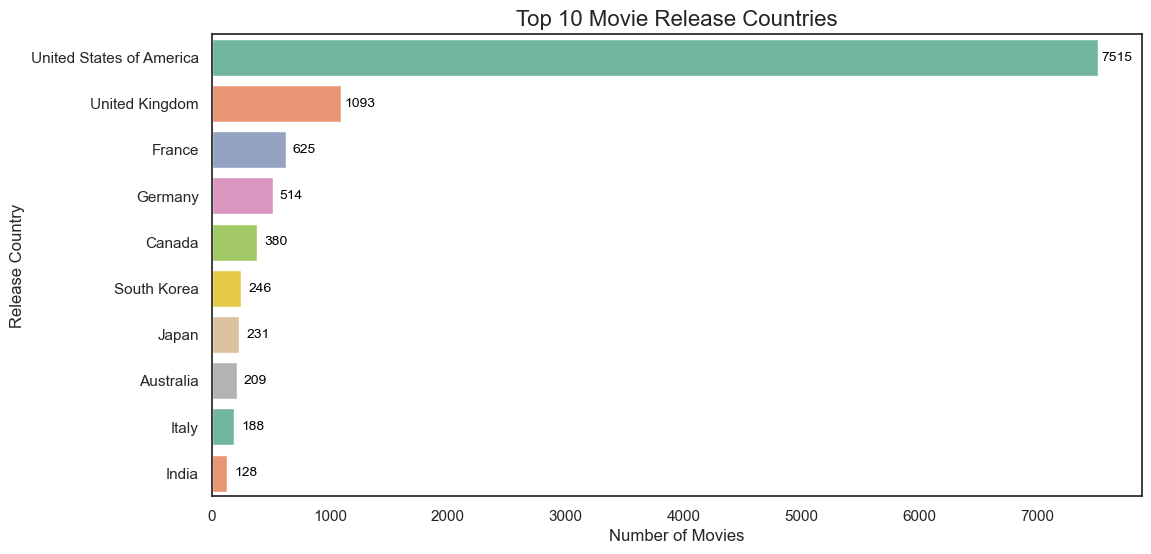

In [26]:
# plot the top n countries
top_n = 10

plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(
    x=countries_count.head(top_n).values,
    y=countries_count.head(top_n).index,
    palette="Set2",
)

for bar in bar_plot.patches:
    plt.text(
        bar.get_width() + 160,
        bar.get_y() + bar.get_height() / 2,
        f"{int(bar.get_width())}",
        ha="center",
        va="center",
        fontsize=10,
        color="black",
    )

plt.title(f"Top {top_n} Movie Release Countries", fontsize=16)
plt.xlabel("Number of Movies")
plt.ylabel("Release Country")
plt.show()

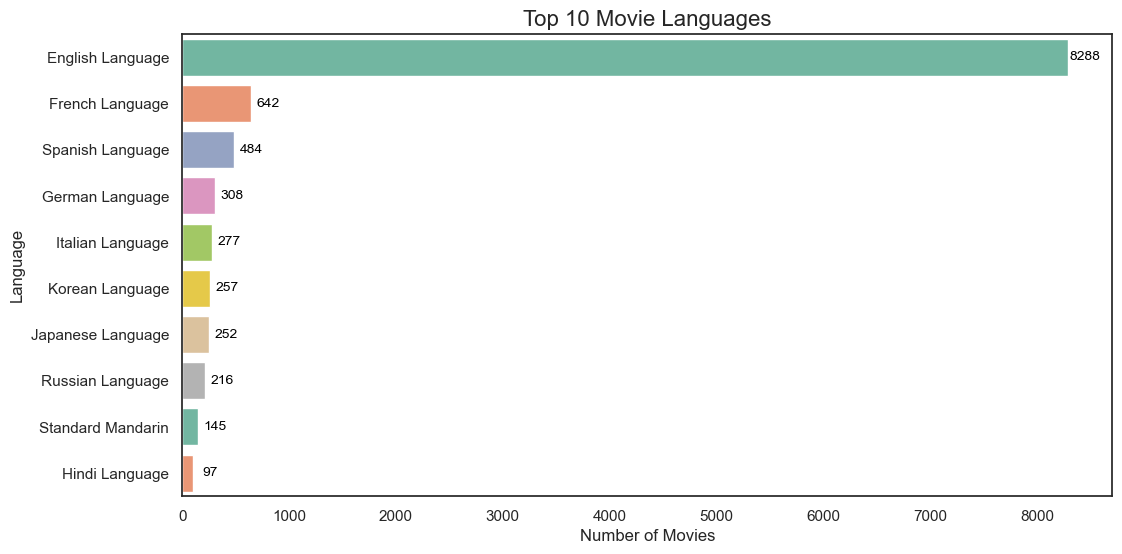

In [27]:
# plot the top n languages
top_n = 10

plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(
    x=languages_count.head(top_n).values,
    y=languages_count.head(top_n).index,
    palette="Set2",
)

for bar in bar_plot.patches:
    plt.text(
        bar.get_width() + 160,
        bar.get_y() + bar.get_height() / 2,
        f"{int(bar.get_width())}",
        ha="center",
        va="center",
        fontsize=10,
        color="black",
    )

plt.title(f"Top {top_n} Movie Languages", fontsize=16)
plt.xlabel("Number of Movies")
plt.ylabel("Language")
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - As expected, the English speaking countries are leading. USA is far further from the rest with more than 7'500 movies.
  - There is a strong presence of North America, Europe, parts of Asia and Australia. South America and Africa are notably absent. 
  - English strongly dominates as the language for movies, with more than 8’000 titles and surpasses all other languages by far.
  - Other languages may have a more localised but still notable presence.
    
</div>

### Language Influence

<div class="alert alert-success">

  💭 <strong>Idea:</strong>

  - Analyse the influence of the language on the box office revenue
  - Consider all of the languages per movie since their order is random. So the movies that have multiple languages will contribute multiple times to the used dataset.
  - Analyse the yearly box office revenue average per language
  
</div>

<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>
  - Duplicate the multilingual movies as additional rows so that there is one row per language
  - Visualisation: Plot the languages and their average box office revenue in a bar chart
  - Regression analysis
  - Statistical hypothesis testing: ANOVA
  - Apply a threshold to consider only languages having a representative amount of movies, repeat several analysis with this modified data
  - Visualisation: Plot the average box office revenues per language over the years in a bar chart
  
</div>

#### Top-n Languages and Box Office Revenue

In [28]:
# create a new dataframe for the extended version (one row per movie and per language)
df_movie_country_language_extended = prepare_df_country_language_extended(
    df_movie_country_language
)
# check the created dataframe
df_movie_country_language_extended.head()

movie_name   movie_languages  \
0            Ghosts of Mars  English Language   
1  Alexander's Ragtime Band  English Language   
2                   Henry V  English Language   
3              Mary Poppins  English Language   
4            New Rose Hotel  English Language   

                               movie_countries  inflated_revenue  \
0  [('/m/09c7w0', 'United States of America')]      1.899115e+07   
1  [('/m/09c7w0', 'United States of America')]      6.131466e+07   
2             [('/m/07ssc', 'United Kingdom')]      1.967252e+07   
3  [('/m/09c7w0', 'United States of America')]      7.913870e+08   
4  [('/m/09c7w0', 'United States of America')]      3.100822e+04   

   release_year  log_revenue  
0          2001     7.278551  
1          1938     7.787564  
2          1989     7.293860  
3          1964     8.898389  
4          1999     4.491477

In [29]:
# average box office revenue per language
average_revenue_per_language = (
    df_movie_country_language_extended.groupby("movie_languages")[
        "inflated_revenue"
    ].mean()
).sort_values(ascending=False)

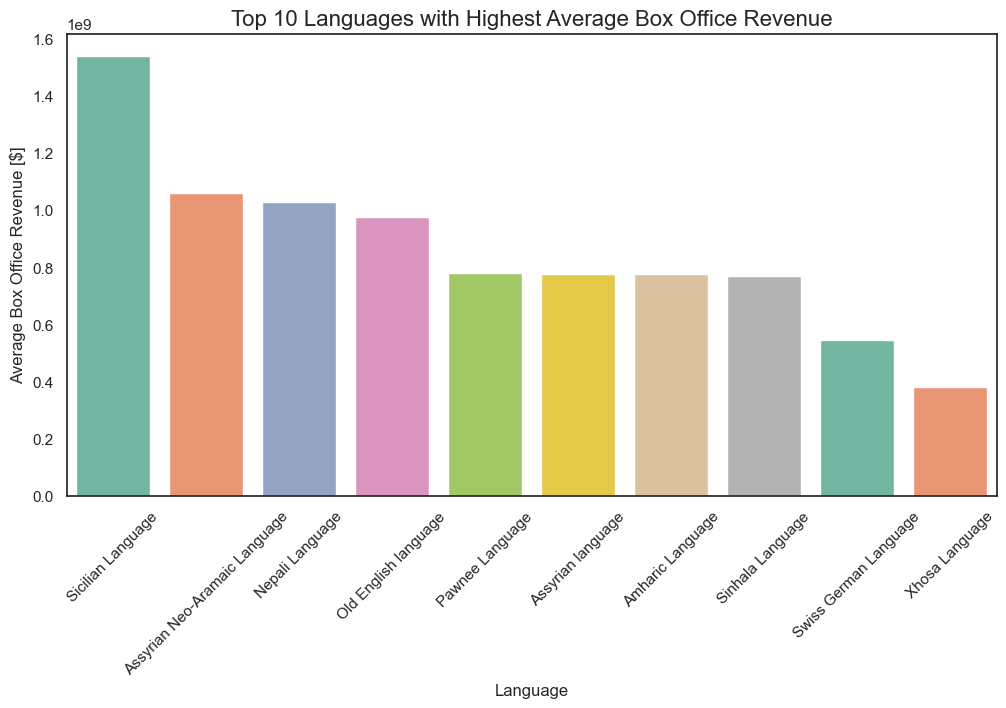

In [30]:
# plot the top n languages with highest average box office revenue
top_n = 10

plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(
    x=average_revenue_per_language.head(top_n).index,
    y=average_revenue_per_language.head(top_n).values,
    palette="Set2",
)

plt.title(f"Top {top_n} Languages with Highest Average Box Office Revenue", fontsize=16)
plt.xlabel("Language")
plt.ylabel("Average Box Office Revenue [$]")
plt.xticks(rotation=45)

plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - It can be seen that quite unknown languages appear to have a high average box revenue. A possible explanation could be: Since the languages are unknown, they don't have a lot of movies. Therefore, their mean is less representative (it could be the mean of only 10 movies). 
  - In order to remove such cases, a threshold is set. Only languages with more movies than this threshold are kept and the same analysis is done again. 
    
</div>

#### Top-n Languages and Box Office Revenue with Threshold

In [31]:
# count the number of movies per language
movies_per_language = df_movie_country_language_extended[
    "movie_languages"
].value_counts()
# only keep languages with at least 50 movies
threshold = 50
common_languages = movies_per_language[movies_per_language >= threshold].index

# average box office revenue per language with applying the threshold
average_revenue_per_language_threshold = (
    df_movie_country_language_extended[
        df_movie_country_language_extended["movie_languages"].isin(common_languages)
    ]
    .groupby("movie_languages")["inflated_revenue"]
    .mean()
    .sort_values(ascending=False)
)

In [32]:
# print the common languages
print(f"Common languages with more than {threshold} movies:\n{common_languages}")

Common languages with more than 50 movies:
Index(['English Language', 'French Language', 'Spanish Language',
       'German Language', 'Italian Language', 'Korean Language',
       'Japanese Language', 'Russian Language', 'Standard Mandarin',
       'Hindi Language', 'Cantonese', 'Arabic Language', 'Latin Language',
       'Portuguese Language', 'Standard Cantonese'],
      dtype='object', name='movie_languages')


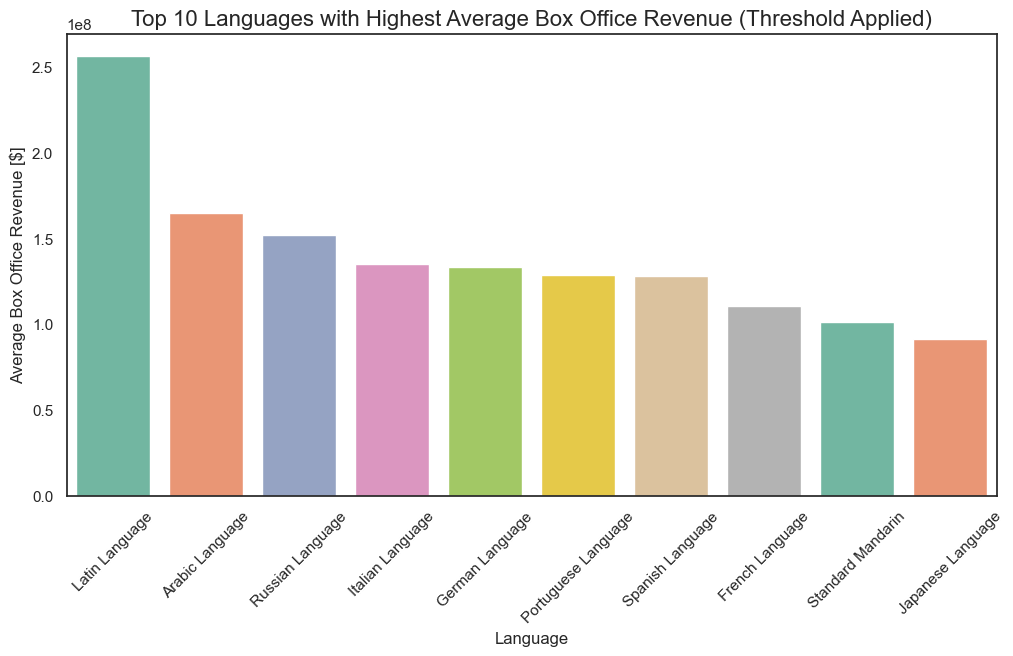

In [33]:
# plot the top n languages with highest average box office revenue (after applying the threshold)
top_n = 10

plt.figure(figsize=(12, 6))
sns.barplot(
    x=average_revenue_per_language_threshold.head(top_n).index,
    y=average_revenue_per_language_threshold.head(top_n).values,
    palette="Set2",
)
plt.title(
    f"Top {top_n} Languages with Highest Average Box Office Revenue (Threshold Applied)",
    fontsize=16,
)
plt.xlabel("Language")
plt.ylabel("Average Box Office Revenue [$]")
plt.xticks(rotation=45)

plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - The plot looks quite different, containing more common languages.
  - However, the results are maybe not as expected. Latin, arabic and russian language are dominating. Probably the number of movies plays a role. In fact, many of the top 10 languages don't have that many movies. If some of the ones they have achieve a particularly high box office revenue, it increases the mean more importantly than for languages with more movies (as for example English).
  - Additionally, the release year might also play a role. So let's analyse how the average box office revenue per language changed over the years.
    
</div>

#### Regression Analysis

The language (categorical) should predict the box office revenue (continuous). An ordinary least squares (OLS) regression can be done. The categorical variable has to be one-hot encoded. Each language will get an own coefficient, indicating its influence on the box office revenue compared to the baseline language.

In [36]:
# one-hot encode the language column
# baseline language -> the most common language
# only take the common languages
X = pd.get_dummies(
    df_movie_country_language_extended[
        df_movie_country_language_extended["movie_languages"].isin(common_languages)
    ]["movie_languages"],
    drop_first=True,
).astype(int)

# take the log for the revenue
y = np.log10(
    df_movie_country_language_extended[
        df_movie_country_language_extended["movie_languages"].isin(common_languages)
    ]["inflated_revenue"].astype(float)
)

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       inflated_revenue   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     10.87
Date:                Fri, 20 Dec 2024   Prob (F-statistic):           4.09e-25
Time:                        20:32:52   Log-Likelihood:                -15590.
No. Observations:               11311   AIC:                         3.121e+04
Df Residuals:                   11296   BIC:                         3.132e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   7.5094    

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - The R-squared value is very low (0.013), indicating that the model does not explain much of the variability in the data.
  - Some p-values are low, indicating that the influence of the corresponding languages is significant. 
  - All the coefficients except the one for Latin are negative. This means that every of the mentioned languages has a negative influence on the box office revenue, excpet for Latin, which is has the highest overall average box office revenue.
  - So even though the R-squared value is very low, there is a statistical significance for several languages.
    
</div>

#### ANOVA

An ANOVA analysis can be done in order to determine if there are statistically significant differences in box office revenue across different languages.

In [37]:
# ANOVA only with the common languages
# define and fit the model
anova_model_threshold = ols(
    "inflated_revenue ~ C(movie_languages)",
    data=df_movie_country_language_extended[
        df_movie_country_language_extended["movie_languages"].isin(common_languages)
    ],
).fit()
# get the anova table
anova_table_threshold = sm.stats.anova_lm(anova_model_threshold, typ=2)

print(anova_table_threshold)

                          sum_sq       df         F        PR(>F)
C(movie_languages)  6.349516e+18     14.0  8.937749  8.215000e-20
Residual            5.732038e+20  11296.0       NaN           NaN


<div class="alert alert-info">
  💡 <strong>Discussion:</strong>
  
  - The p-value is very low, meaning the null hypothesis that box office revenue means are the same for all languages can be rejected. 
  - There is statistically significant evidence that the release country has an impact on box office revenue.
  
</div>

### Multilingual Movies

<div class="alert alert-success">

  💭 <strong>Idea:</strong>

  - Analyse the influence of the number of languages a movie has
  
</div>
<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>
  - Count the number of languages per movie
  - Visualisation: Plot the number languages and the average box office revenue with box plots
  
</div>

In [38]:
# Count the number of languages per movie
df_movie_country_language["nbr_languages"] = df_movie_country_language[
    "movie_languages"
].apply(lambda x: len(ast.literal_eval(x)))

# check the dataframe
df_movie_country_language.head()

movie_name                       movie_languages  \
0            Ghosts of Mars  [('/m/02h40lc', 'English Language')]   
1  Alexander's Ragtime Band  [('/m/02h40lc', 'English Language')]   
2                   Henry V  [('/m/02h40lc', 'English Language')]   
3              Mary Poppins  [('/m/02h40lc', 'English Language')]   
4            New Rose Hotel  [('/m/02h40lc', 'English Language')]   

                               movie_countries  inflated_revenue  \
0  [('/m/09c7w0', 'United States of America')]      1.899115e+07   
1  [('/m/09c7w0', 'United States of America')]      6.131466e+07   
2             [('/m/07ssc', 'United Kingdom')]      1.967252e+07   
3  [('/m/09c7w0', 'United States of America')]      7.913870e+08   
4  [('/m/09c7w0', 'United States of America')]      3.100822e+04   

   release_year  log_revenue  nbr_languages  
0          2001     7.278551              1  
1          1938     7.787564              1  
2          1989     7.293860              1  
3          1964     8.898389              1  
4          1999     4.491477              1

In [39]:
# average revenue for each language
mean_language_revenue = df_movie_country_language.groupby("nbr_languages")[
    "inflated_revenue"
].agg(["mean", "std"])

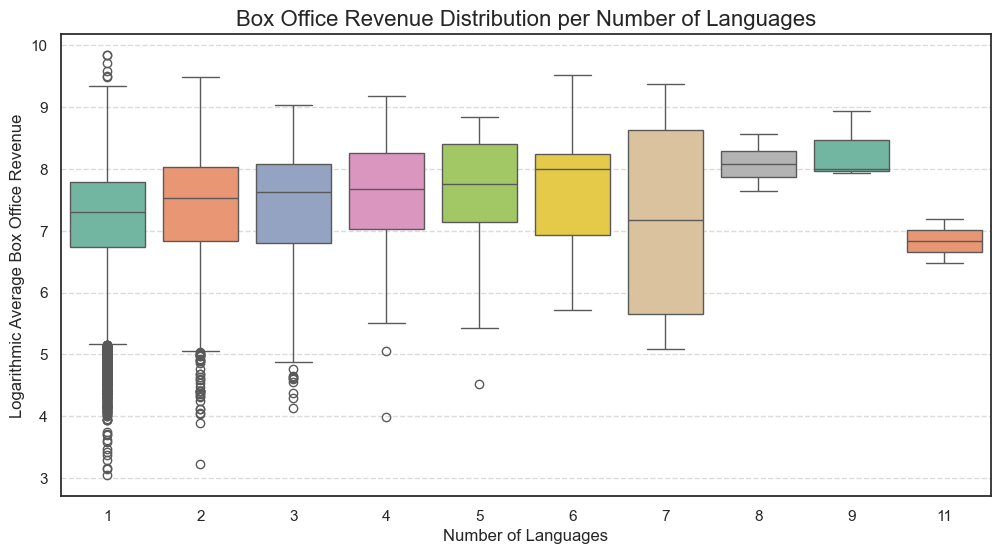

In [40]:
# create the boxplots of box office revenue
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_movie_country_language,
    x="nbr_languages",
    y="log_revenue",
    order=mean_language_revenue.index.to_list(),
    showfliers=True,
    palette="Set2",
)
plt.title("Box Office Revenue Distribution per Number of Languages", fontsize=16)
plt.xlabel("Number of Languages")
plt.ylabel("Logarithmic Average Box Office Revenue")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>
  
  - The median of logarithmic revenue increases with the number of languages (from 1 to 6). 
  - There are not many movies with more than 7 languages, which might be the reason why the trend doesn't continue for all numbers. 
  - There is no movie with 10 languages.
  - It can be concluded that multilinguality can have a positive influence on the box office revenue.
  
</div>

### Country Influence

<div class="alert alert-success">

  💭 <strong>Idea:</strong>

  - Get an idea of the average box office revenue per country
  - Analyse the influence of the country on the box office revenue
  - Only consider the first mentioned country in the list of countries (the release country)
  
</div>

<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>
  - Extract the first country in the country list for each movie
  - Visualisation: Plot a map with all countries and their average box office revenues
  - Visualisation: Plot the countries and their average box office revenue in a bar chart
  - Regression analysis
  - Statistical hypothesis testing: ANOVA
  - Apply a threshold to consider only countries having a representative amount of movies, repeat several analysis with this modified data
  
</div>

#### Average Box Office Revenue on the Map

In [41]:
# extract the first country
df_movie_country_language["first_country"] = df_movie_country_language[
    "movie_countries"
].apply(lambda x: extract_first_country(x))

# average box office revenue per country (only considering the fist countries for each movie)
average_revenue_per_country = (
    df_movie_country_language.groupby("first_country")["inflated_revenue"]
    .mean()
    .sort_values(ascending=False)
)
# create a dataframe for visualisation
country_revenue_df = average_revenue_per_country.reset_index()
country_revenue_df.columns = ["Country", "Average Box Office Revenue"]

In [42]:
# plot the average box office revenue per country on a map
fig = px.choropleth(
    country_revenue_df,
    locations="Country",
    locationmode="country names",
    color="Average Box Office Revenue",
    hover_name="Country",
    color_continuous_scale=px.colors.sequential.matter,
    title="Average Box Office Revenue by Country",
)

fig.update_layout(
    title_x=0.5,
    title_font=dict(family="Arial"),
    margin=dict(t=70, b=50, l=50, r=50),
    coloraxis_colorbar=dict(
        title="Average Box Office Revenue [$]",
    ),
    template="plotly_white",
)

fig.show(config={"staticPlot": True})

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>
  
  - It can be observed that not all regions of the world are represented in the dataset. For example Africa contains significant areas with missing data.
  - Some countries, as for example Kenya or Thailand, have a high average box office revenue due to their low number of movies, where a few successful films significantly influence the average.
  - The USA on the other hand has a high average box office revenue that is more representative since it is based on a large volume of movies produced.
  
</div>

#### Top-n Countries and Box Office Revenue

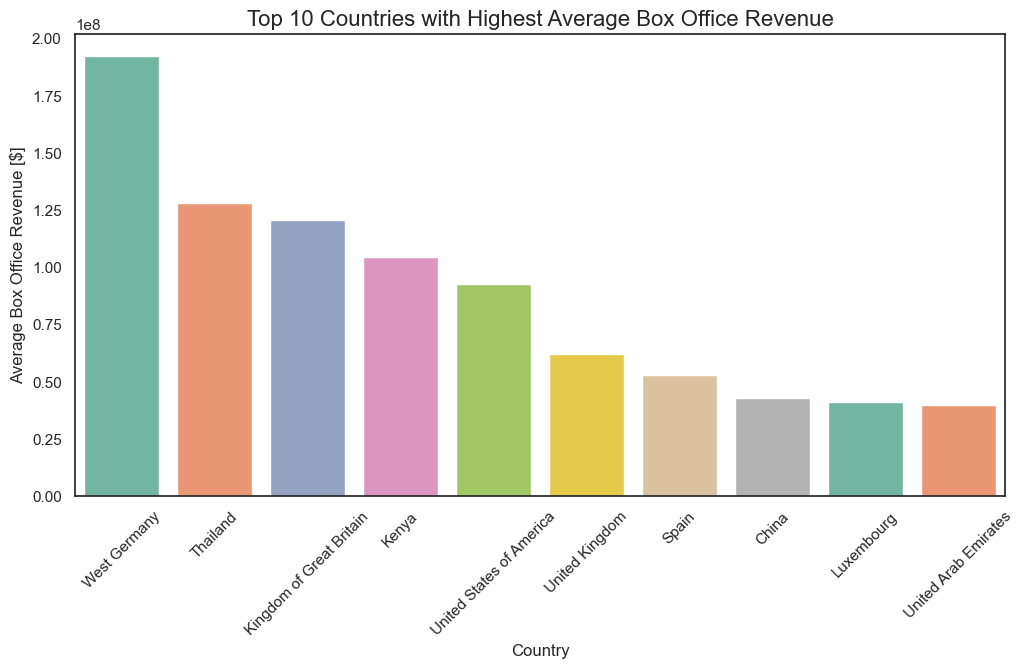

In [43]:
# plot the top n countries with highest average box office revenue
top_n = 10

plt.figure(figsize=(12, 6))
sns.barplot(
    x=average_revenue_per_country.head(top_n).index,
    y=average_revenue_per_country.head(top_n).values,
    palette="Set2",
)
plt.title(f"Top {top_n} Countries with Highest Average Box Office Revenue", fontsize=16)
plt.xlabel("Country")
plt.ylabel("Average Box Office Revenue [$]")
plt.xticks(rotation=45)
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>
  
  - Some of the countries probably only released few movies. These might be removed by applying a threshold. 
  
</div>

#### Top-n Countries and Box Office Revenue with Threshold

In [44]:
# count the number of movies per country
movies_per_country = df_movie_country_language["first_country"].value_counts()
# only get the countries with more than a certain number of movies
threshold = 40
common_countries = movies_per_country[movies_per_country >= threshold].index

# average box office revenue per country with applying the threshold
average_revenue_per_country_threshold = (
    df_movie_country_language[
        df_movie_country_language["first_country"].isin(common_countries)
    ]
    .groupby("first_country")["inflated_revenue"]
    .mean()
).sort_values(ascending=False)

In [45]:
# print the common countries
print(f"Common countries with more than {threshold} movies:\n{common_countries}")

Common countries with more than 40 movies:
Index(['United States of America', 'France', 'United Kingdom', 'South Korea',
       'Japan', 'India', 'Australia', 'Canada', 'Hong Kong', 'Spain'],
      dtype='object', name='first_country')


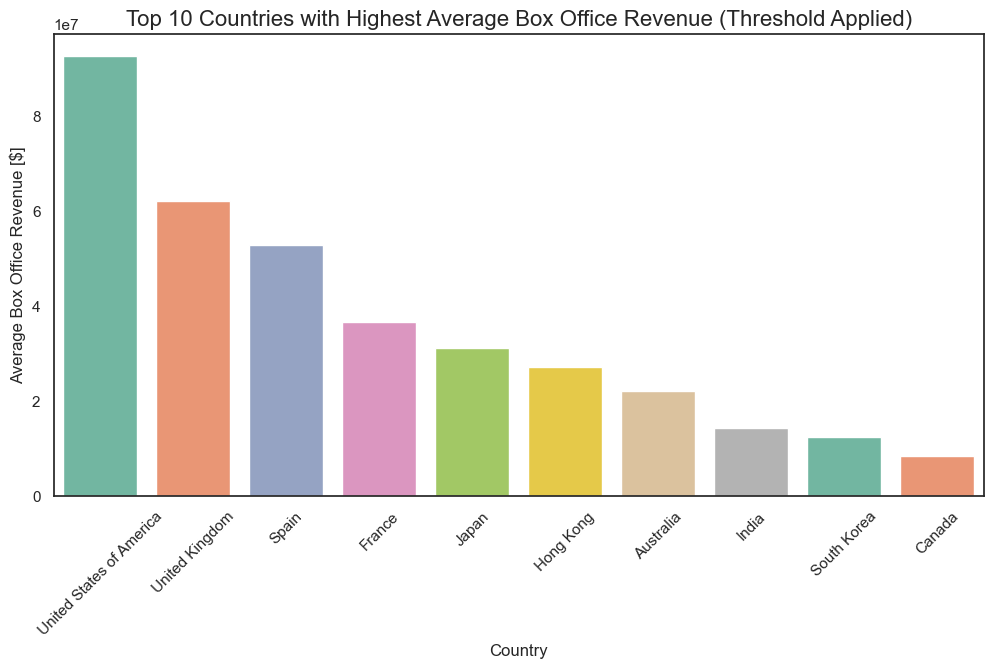

In [46]:
# plot the top n countries with highest average box office revenue
top_n = 10

plt.figure(figsize=(12, 6))
sns.barplot(
    x=average_revenue_per_country_threshold.head(top_n).index,
    y=average_revenue_per_country_threshold.head(top_n).values,
    palette="Set2",
)
plt.title(
    f"Top {top_n} Countries with Highest Average Box Office Revenue (Threshold Applied)",
    fontsize=16,
)
plt.xlabel("Country")
plt.ylabel("Average Box Office Revenue [$]")
plt.xticks(rotation=45)
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>
  
  - The plot no longer contains the countries that might not have a representative number of movies. 
  - The USA and the United Kingdom are leading, which aligns with the previous language analysis.
  - The presence of North America, Europe, and parts of Asia is notable. However, Africa and South America are largely absent from the top countries.
  
</div>

#### Regression Analysis

The country (categorical) should predict the box office revenue (continuous). An ordinary least squares (OLS) regression can be done. The categorical variable has to be one-hot encoded. Each country will get an own coefficient, indicating its influence on the box office revenue compared to the baseline country.

In [47]:
# one-hot encode the country column
# baseline country -> the most common country
# only take the common countries
X = pd.get_dummies(
    df_movie_country_language[
        df_movie_country_language["first_country"].isin(common_countries)
    ]["first_country"],
    drop_first=True,
).astype(int)

# take the log for the revenue
y = np.log10(
    df_movie_country_language[
        df_movie_country_language["first_country"].isin(common_countries)
    ]["inflated_revenue"].astype(float)
)

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       inflated_revenue   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     50.70
Date:                Fri, 20 Dec 2024   Prob (F-statistic):           3.28e-90
Time:                        20:33:47   Log-Likelihood:                -11927.
No. Observations:                8808   AIC:                         2.387e+04
Df Residuals:                    8798   BIC:                         2.394e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - The R-squared value is very low (0.049), indicating that the model does not explain a lot of variability in the data so the fit is not really good.
  - However, several p-values (for the USA, Canada, Hong Kong, Japan and United Kingdom) are significantly low. This indicates that these countries have a statistically significant influence on the box office revenue.
  - The coefficients are positive for all countries, though slightly for some, except for Canada. Canada, in fact, had the lowest average box office revenue among the top countries.
    
</div>

#### ANOVA

An ANOVA analysis can be done in order to determine if there are statistically significant differences in box office revenue across different countries.

In [49]:
# define and fit the model (only with the common countries)
anova_model_country = ols(
    "inflated_revenue ~ C(first_country)",
    data=df_movie_country_language[
        df_movie_country_language["first_country"].isin(common_countries)
    ],
).fit()
# get the anova table
anova_table_country = sm.stats.anova_lm(anova_model_country, typ=2)

print(anova_table_country)

                        sum_sq      df          F        PR(>F)
C(first_country)  4.672548e+18     9.0  11.397784  6.117292e-18
Residual          4.007512e+20  8798.0        NaN           NaN


<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - The p-value is low, meaning the null hypothesis that box office revenue means are the same for all countries can be rejected. 
  - There is statistically significant evidence that the release country has an impact on box office revenue.
  
</div>

# Movie 3: Shades 🎭 
## How does a movie's genre impact its box office revenue?

This movie aims to provide an understanding of whether certain genres are associated with higher revenues and if the relationship between genre and revenue changes over time.

**🏗️ Analysis Structure:**

- **Data Preparation**
  - **Columns:** We use `movie_genres`, `inflated_revenue`, `release_year`. Additionally, we create a `log_revenue` column for log-transformed revenue.
  - **Missing Data:** Entries with missing values are removed
  - **Handling duplicates:** Duplicate entries are removed
  - **Genres:** Genre strings are converted to lists. Duplicate genres are removed from the lists. Additionally, we drop the movies with empty genre lists.
- **Exploratory Data Analysis**
  - **Descriptive Statistics:** Summarize the data to understand the distribution of revenue and release years.
  - **Number of Movies per Genre:** Analyze the frequency of each genre. Show the top 20 most common genres.
  - **Number of Genres per Movie:** Examine the distribution of the number of genres per movie. 
  - **Genre Co-Occurences:** Analyze the co-occurrence of genres.
  - **Genres with Highest Average Box Office Revenue:** Visualize the genres with the highest average revenue.
  - **Distribution of Box Office Revenue per Genre:** Analyze the distribution of revenue for each genre.
  - **Distribution of Box Office Revenue per Number of Genres:** Analyze the distribution of revenue based on the number of genres.
  - **Revenue Trends Over Time:** Investigate the average box office revenue per genre over time.
  - **Genre Ranking by Average Box Office Revenue per Decade:** Rank genres based on average revenue per decade.
  - **Genre Popularity Over Time:** Analyze the popularity of genres over time by number of movies released.
  - **Genre Popularity and Revenue Trends over Time:** Plot the popularity and revenue trends for genres over time.
  - **Correlation between Genre Popularity and Genre Trends over Time:** Analyze the correlation between genre popularity and revenue trends over time.
- **Regression Analysis**
  - **Predicting Box Office Revenue from Genres**: Build a regression model to predict revenue based on genres.
  - **Predicting Box Office Revenue from Genres and Release Year**: Extend the model to include release year as a predictor.
  - **Predicting Box Office Revenue from Number of Genres**: Build a regression model to predict revenue based on the number of genres.

### Data Preparation

#### Relevant Columns

For this analysis, we'll focus on the following columns:
- `movie_genres`: List of the genres of the movie.
- `inflated_revenue`: The box office revenue adjusted for inflation.
- `release_year`: The release year of the movie.

In [ ]:
# data preparation: select necessary columns, drop missing values, handle duplicates
df_genres = prepare_df_for_genre_analysis(df)
print("Number of rows:", df_genres.shape[0])
print(
    f"Percentage of retained rows from original dataframe: {np.round(df_genres.shape[0] / df.shape[0] * 100, 2)} %"
)
df_genres.head()

Number of rows: 9505
Percentage of retained rows from original dataframe: 99.69 %


movie_name  inflated_revenue  release_year  \
0            Ghosts of Mars      1.899115e+07          2001   
1  Alexander's Ragtime Band      6.131466e+07          1938   
2                   Henry V      1.967252e+07          1989   
3              Mary Poppins      7.913870e+08          1964   
4            New Rose Hotel      3.100822e+04          1999   

                                         genres_list  log_revenue  
0  [Thriller, Space western, Horror, Science Fict...     7.278551  
1                 [Musical, Comedy, Black-and-white]     7.787564  
2  [Period piece, Costume drama, Film adaptation,...     7.293860  
3  [Comedy, Fantasy, Family Film, Family, Childre...     8.898389  
4  [Thriller, Indie, Fantasy, Erotic thriller, Fi...     4.491477

### Exploratory Data Analysis
<!-- <div class="alert alert-success"> 💭 <strong>Idea:</strong> 

- Understand the distribution of IMDb ratings. 
- Analyze the distribution of box office revenue. 
- Explore the relationship between IMDb ratings and box office revenue. 
- Investigate the number of movies per genre. 
</div> <div class="alert alert-warning"> 🛠️ <strong>Methods:</strong>

 - Use descriptive statistics to summarize the data. 
 - Visualize the distribution of IMDb ratings using histograms. 
 - Visualize the distribution of box office revenue using histograms with a logarithmic scale. 
 - Use bar plots to show the number of movies per genre. 
 - Use scatter plots to explore the relationship between IMDb ratings and box office revenue. </div>  -->

#### Summary Statistics

In [ ]:
df_genres.describe()

inflated_revenue  release_year  log_revenue
count      9.505000e+03    9505.00000  9505.000000
mean       7.912216e+07    1991.49353     7.187551
std        2.083683e+08      19.64850     0.976878
min        1.108173e+03    1914.00000     3.044607
25%        5.334935e+06    1985.00000     6.727129
50%        2.127232e+07    1998.00000     7.327815
75%        7.031761e+07    2006.00000     7.847064
max        6.941575e+09    2014.00000     9.841458

#### Number of Movies per Genre

Number of unique genres: 316


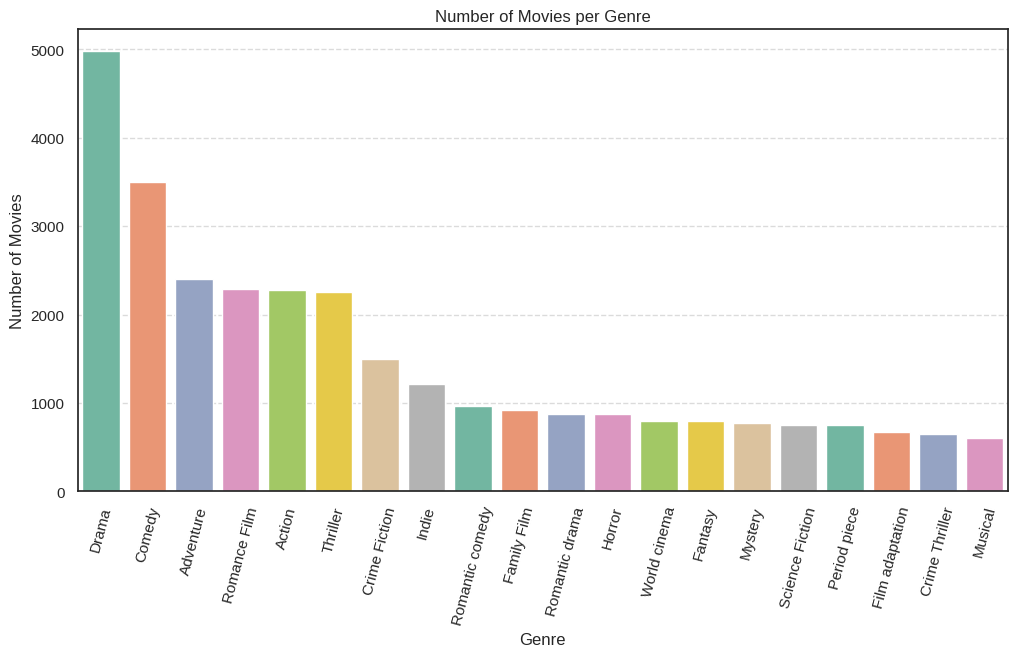

Number of movies with genres in the top 20 most common genres: 9243
Percentage of movies with genres in the top 20 most common genres: 97.24 %


In [ ]:
# explode genres_list to count each genre separately
genre_counts = df_genres.explode("genres_list")["genres_list"].value_counts()

# get the unique genres
unique_genres = genre_counts.index.tolist()
print(f"Number of unique genres: {len(unique_genres)}")

# get the most common 20 genres and their counts
genre_counts_top20 = genre_counts.head(20)
top_20_genres = genre_counts_top20.index.tolist()

plot_genre_barplot(genre_counts_top20, "Number of Movies per Genre")

# get the number of movies with genres in the top 20 most common genres
print(
    "Number of movies with genres in the top 20 most common genres:",
    len(get_movies_with_genres(df_genres, top_20_genres)),
)
print(
    f"Percentage of movies with genres in the top 20 most common genres: {np.round(len(get_movies_with_genres(df_genres, top_20_genres)) / df_genres.shape[0] * 100, 2)} %"
)

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - There are **316 unique genres** in our dataset.
  
  - The top 20 most common genres are shown in the plot above, and include *Drama*, *Comedy*, *Adventure*, *Romance Film*, *Action*, *Thriller* and others.

  - **97.24%** of movies (9243 out of 9505) have at least one genre from the top 20.
</div>

#### Distribution of Number of Genres per Movie

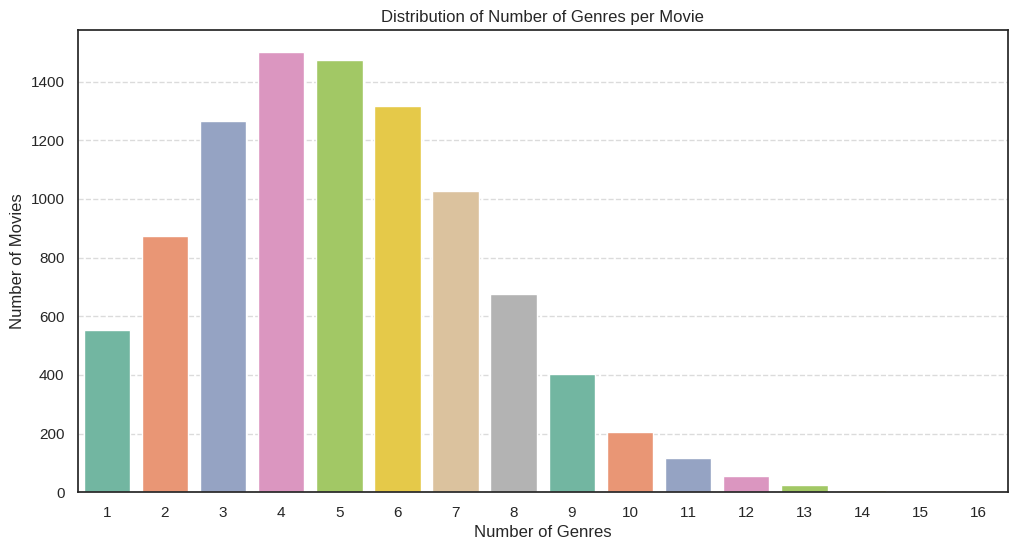

Percentage of movies with more than one genre: 94.19%


In [ ]:
# get the number of genres for each movie
df_genres["num_genres"] = df_genres["genres_list"].apply(len)

# get the distribution of the number of genres
num_genres_distribution = df_genres["num_genres"].value_counts().sort_index()

# plot the distribution
plt.figure(figsize=(12, 6))
sns.barplot(
    x=num_genres_distribution.index,
    y=num_genres_distribution.values,
    palette="Set2",
)
plt.title("Distribution of Number of Genres per Movie")
plt.xlabel("Number of Genres")
plt.ylabel("Number of Movies")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# print the percentage of movies with more than one genre
percentage = (len(df_genres) - num_genres_distribution[1]) / len(df_genres) * 100
print(
    f"Percentage of movies with more than one genre: {percentage:.2f}%",
)

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - This plot shows the distribution of the number of genres per movie in our dataset.
  
  - **94.19%** of the movies more have than one genre, showing that multi-genre films are very common.
  
</div>

#### Genre Co-Occurences

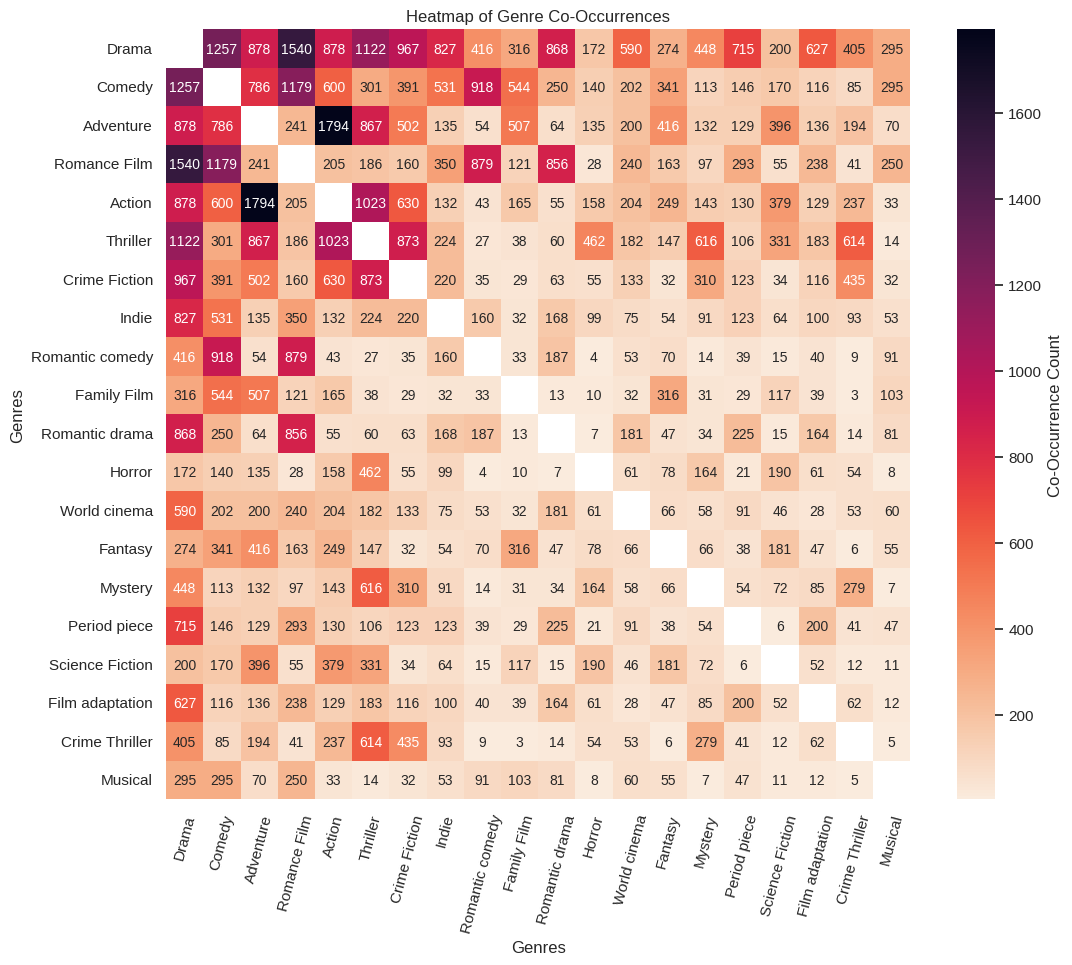

In [ ]:
# one-hot encode the top 20 most common genres
for genre in top_20_genres:
    df_genres[genre] = df_genres["genres_list"].apply(lambda x: 1 if genre in x else 0)

# create a co-occurrence matrix for the top 20 genres
coocurence_matrix = df_genres[top_20_genres].T.dot(df_genres[top_20_genres])

# create a mask to hide the main diagonal
mask = np.eye(coocurence_matrix.shape[0], dtype=bool)

# plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    coocurence_matrix,
    annot=coocurence_matrix,
    mask=mask,
    fmt="",
    cmap="rocket_r",
    xticklabels=top_20_genres,
    yticklabels=top_20_genres,
    annot_kws={"fontsize": 10},
    cbar_kws={"label": "Co-Occurrence Count"},
)
plt.title("Heatmap of Genre Co-Occurrences")
plt.xlabel("Genres")
plt.ylabel("Genres")
plt.xticks(rotation=75)
plt.yticks(rotation=0)
plt.show()

##### Find genres with the highest co-occurence count

In [ ]:
# fill the diagonal with zeros to exclude counting the same genre
np.fill_diagonal(coocurence_matrix.values, 0)

# calculate the total co-occurrences for each genre
genre_sums = coocurence_matrix.sum(axis=1)

# create a dataframe
df_genre_sums = pd.DataFrame(
    {"Genre": genre_sums.index, "Total Co-Occurrences": genre_sums.values}
)

# sort the datarame
df_genre_sums.sort_values(by="Total Co-Occurrences", ascending=False, inplace=True)
df_genre_sums.head(5)

Genre  Total Co-Occurrences
0      Drama                 12795
1     Comedy                  8365
2  Adventure                  7636
5   Thriller                  7376
4     Action                  7187

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - The heatmap shows how frequently the top 20 genres co-occur in movies, highlighting the multi-genre nature of our dataset.
  
  - *Action & Adventure* (~1794), *Romance Film & Drama* (~1540) and *Comedy & Drama* (~1257) frequently appear together.
  
  - *Drama*, *Comedy* and *Adventure* co-occur the most with other genres, as shown in the table above.
  
</div>

#### Genres with Highest Average Box Office Revenue

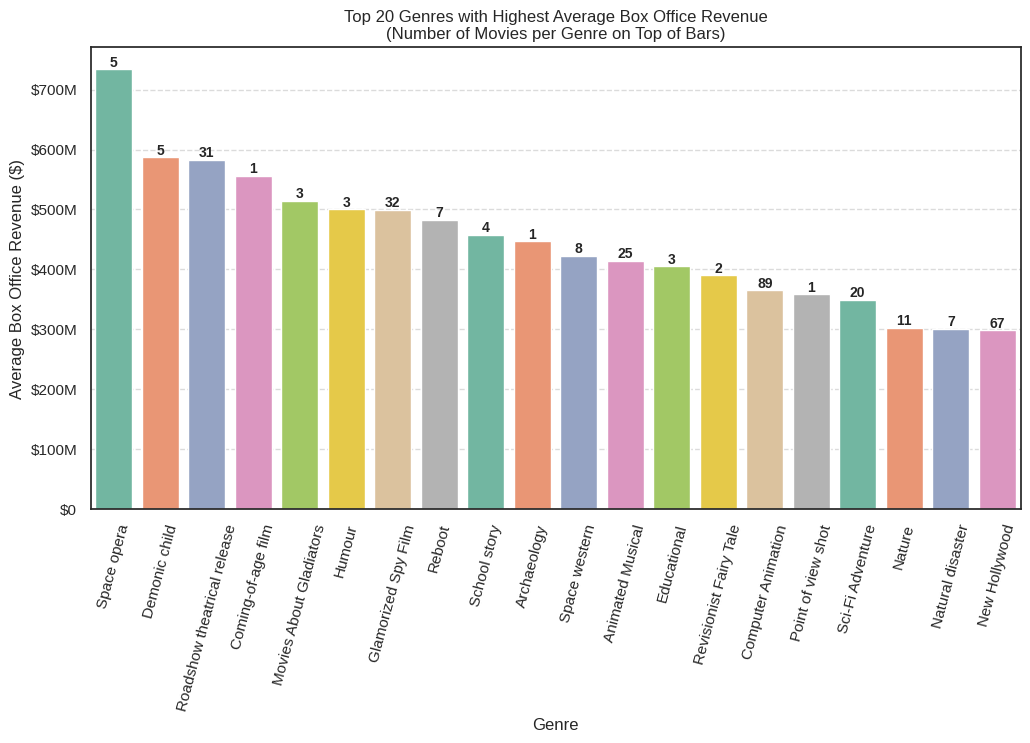

In [ ]:
# create new dataframe with exploded genres
df_genres_exploded = df_genres.explode("genres_list")[
    ["movie_name", "genres_list", "inflated_revenue", "log_revenue", "release_year"]
]

# get the average revenue for each genre
mean_genre_revenue = df_genres_exploded.groupby("genres_list")["inflated_revenue"].agg(
    ["mean", "count"]
)

# sort the genres by average revenue
mean_genre_revenue = mean_genre_revenue.sort_values(ascending=False, by="mean")

# plot the top n genres with highest average revenue
top_n = 20
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x=mean_genre_revenue.head(top_n).index,
    y=mean_genre_revenue.head(top_n).values[:, 0],
    palette="Set2",
)
# add the number of movies on top of the bars
for i, (mean, count) in enumerate(mean_genre_revenue.head(top_n).values):
    ax.text(
        i,
        mean,
        f"{int(count)}",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
    )

plt.title(
    f"Top {top_n} Genres with Highest Average Box Office Revenue\n(Number of Movies per Genre on Top of Bars)"
)
plt.xlabel("Genre")
plt.ylabel("Average Box Office Revenue ($)")
plt.xticks(rotation=75)
plt.gca().yaxis.set_major_formatter(revenue_formatter)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [ ]:
# show the movies in the top revenue genres
print("Space opera movies:", get_movies_with_genres(df_genres, ["Space opera"]))
print("Demonic child movies:", get_movies_with_genres(df_genres, ["Demonic child"]))
print(
    "Gladiator movies:", get_movies_with_genres(df_genres, ["Movies About Gladiators"])
)

Space opera movies: ['Serenity', 'Battlefield Earth', 'Star Wars Episode II: Attack of the Clones', 'Star Wars Episode VI: Return of the Jedi', 'Star Wars Episode V: The Empire Strikes Back']
Demonic child movies: ['The Omen', 'The Exorcist', 'The Omen', 'Damien: Omen II', 'Omen III: The Final Conflict']
Gladiator movies: ['Star Wars Episode II: Attack of the Clones', 'Gladiator', 'Demetrius and the Gladiators']


<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

- This plot shows the 20 genres with the highest average box office revenue, along with the number of movies per genre displayed on top of the bars.

- Many of these high-revenue genres, such as *Space Opera* and *Demonic Child*, have very few movies in the dataset, but appear as highly profitable likely due to outliers. 
  - *Space Opera* includes **Star Wars**.
  - *Demonic Child* includes **The Exorcist**.
  
- Given the multi-genre nature of our dataset, these movies likely include other, more common genres whose average revenues are lower. 
  - **Star Wars** is also listed under *Fantasy*, *Action*, *Science Fiction* and *Adventure*.
  - **The Exorcist** is also listed under *Horror* and *Drama*.

- To better understand revenue trends, further analysis will focus on the top 20 most common genres, which account for **97.24%** of the total movies in the dataset. 
  
</div>

#### Distribution of Box Office Revenue per Genre

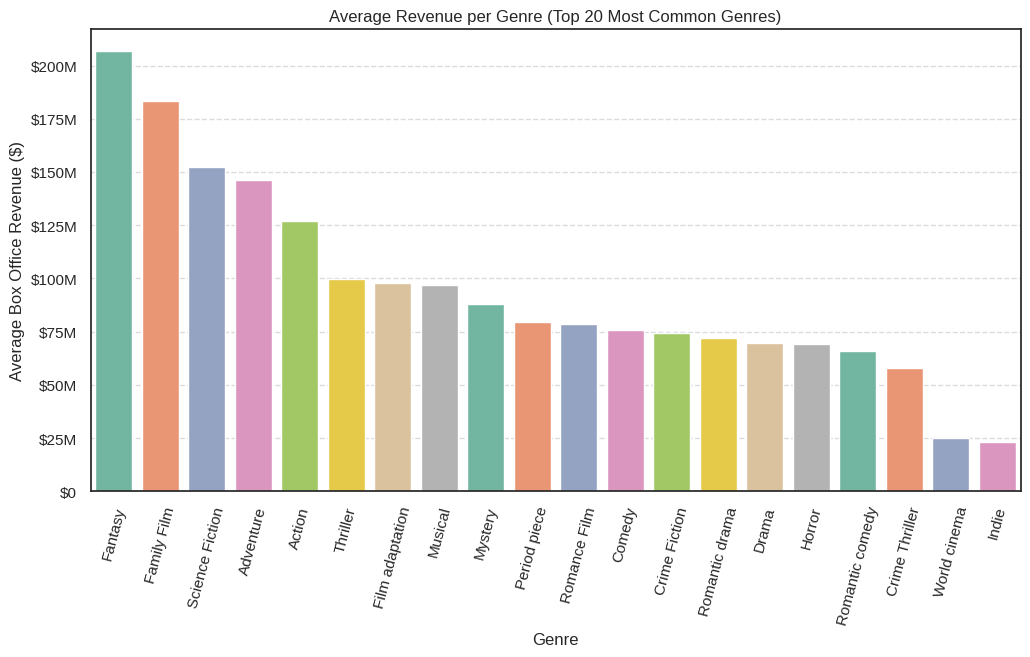

In [ ]:
# filter the top 20 most common genres
df_top_genres = df_genres_exploded[
    df_genres_exploded["genres_list"].isin(top_20_genres)
]

# get the average revenue for each genre
mean_genre_revenue = df_top_genres.groupby("genres_list")["inflated_revenue"].agg(
    ["mean", "std", "count"]
)

# sort the genres by average revenue
mean_genre_revenue = mean_genre_revenue.sort_values(ascending=False, by="mean")

# plot the top n genres with highest average revenue
top_n = 20
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x=mean_genre_revenue.head(top_n).index,
    y=mean_genre_revenue.head(top_n)["mean"],
    palette="Set2",
)
plt.title(f"Average Revenue per Genre (Top {top_n} Most Common Genres)")
plt.xlabel("Genre")
plt.ylabel("Average Box Office Revenue ($)")
plt.xticks(rotation=75)
plt.gca().yaxis.set_major_formatter(revenue_formatter)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

- This plot shows the average box office revenue for the top 20 most common genres in our dataset.

- *Fantasy* and *Family Film* genres have the highest average revenues, exceeding **$175M**.

- *Science Fiction*, *Adventure* and *Action* also show a strong average revenue, possibly due to their popularity in big-budget blockbusters.

- On the other hand, genres such as *World Cinema* and *Indie* have much lower average revenues, below **$25M**.
  
</div>

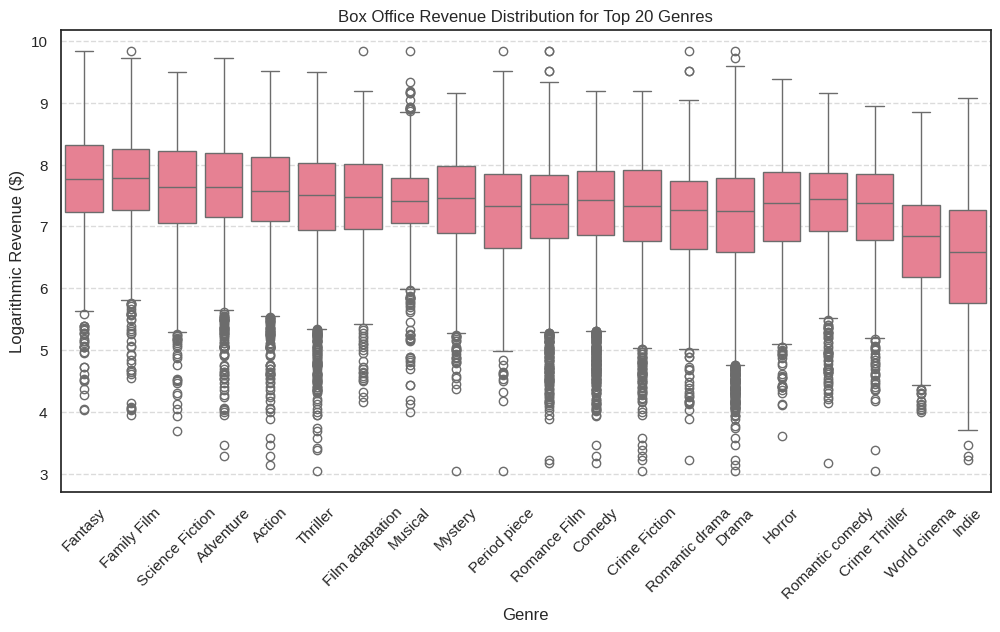

In [ ]:
# create the boxplots of box office revenue
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_top_genres,
    x="genres_list",
    y="log_revenue",
    order=mean_genre_revenue.index.to_list(),
    showfliers=True,
)
plt.title("Box Office Revenue Distribution for Top 20 Genres")
plt.xlabel("Genre")
plt.ylabel("Logarithmic Revenue ($)")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - While the average box office revenue provides an insight, it does not fully capture the distribution of revenues across genres. The boxplots above offer a more detailed view. 
  
  - The boxplots show the distribution of **log-transformed revenues**, which stabilizes the variance and reduces the skewness caused by extreme values in revenue data.

  - The plots reveal that many genres exhibit wide revenue ranges with noticeable outliers, i.e., movies that earned significantly more or less than others in the same genre.
</div>

#### Distribution of Box Office Revenue per Number of Genres 

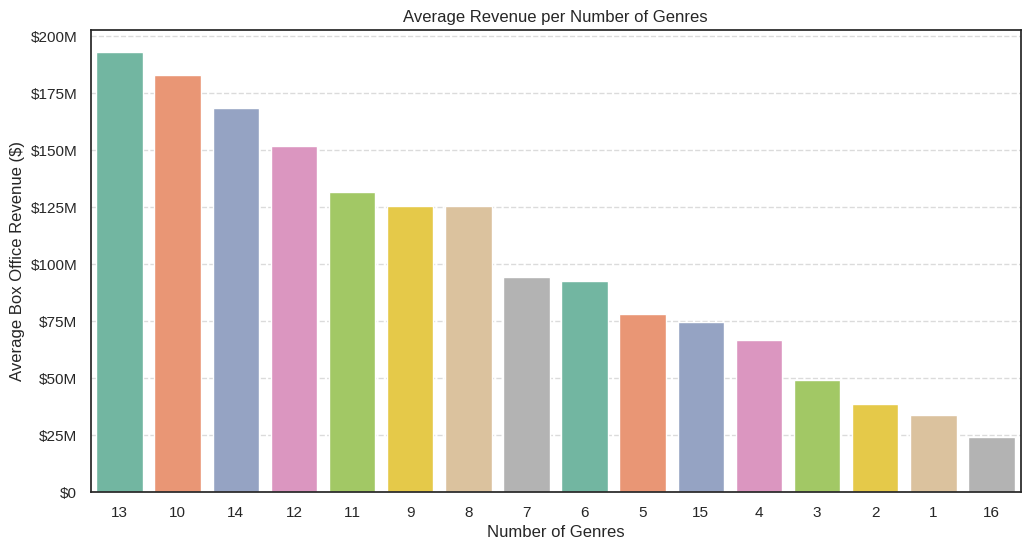

In [ ]:
# get average revenue per number of genres
average_revenue_per_num_genres = df_genres.groupby("num_genres")[
    "inflated_revenue"
].mean()

# sort the genres by average revenue
sorted_average_revenue_per_num_genres = average_revenue_per_num_genres.sort_values(
    ascending=False
)

# plot the average revenue per number of genres
plt.figure(figsize=(12, 6))
sns.barplot(
    x=sorted_average_revenue_per_num_genres.index,
    y=sorted_average_revenue_per_num_genres.values,
    order=sorted_average_revenue_per_num_genres.index,
    palette="Set2",
)
plt.title("Average Revenue per Number of Genres")
plt.xlabel("Number of Genres")
plt.ylabel("Average Box Office Revenue ($)")
plt.gca().yaxis.set_major_formatter(revenue_formatter)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

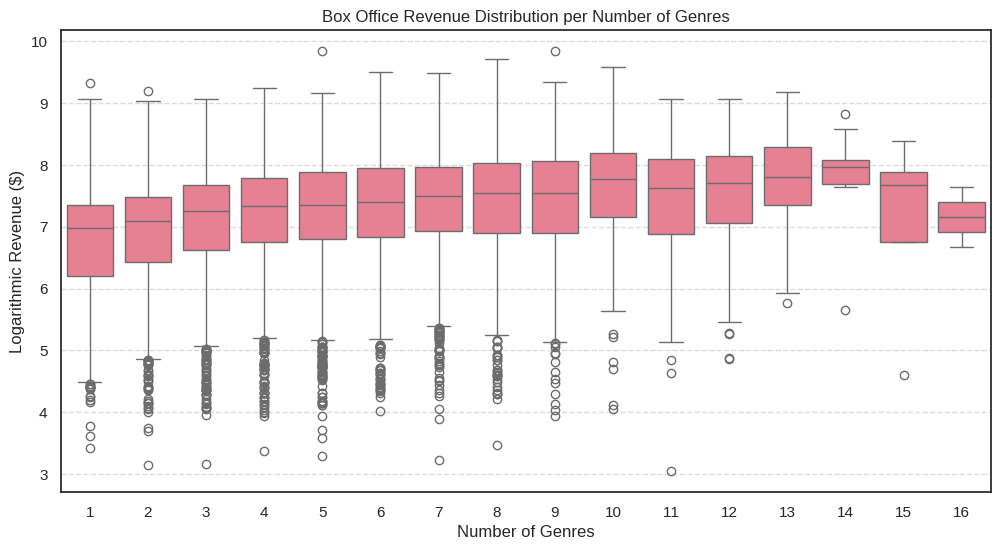

In [ ]:
# plot the revenue per the number of genres
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_genres, x="num_genres", y="log_revenue", showfliers=True)
plt.title("Box Office Revenue Distribution per Number of Genres")
plt.xlabel("Number of Genres")
plt.ylabel("Logarithmic Revenue ($)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - The two plots above show the average box office revenue and the distribution of revenue for different numbers of genres.

  - We observe that movies with more than 10 genres tend to have the highest average revenues, exceeding **$150M**. However, these movies are quite rare in the dataset. 
  
  - From the boxplots, we can see that movies with a higher number of genres tend to have higher median revenues. 

  - While this analysis shows an interesting trend, we believe that the specific genres included in a movie play a more significant role in revenue than the number of genres.
</div>

#### Revenue Trends over Time

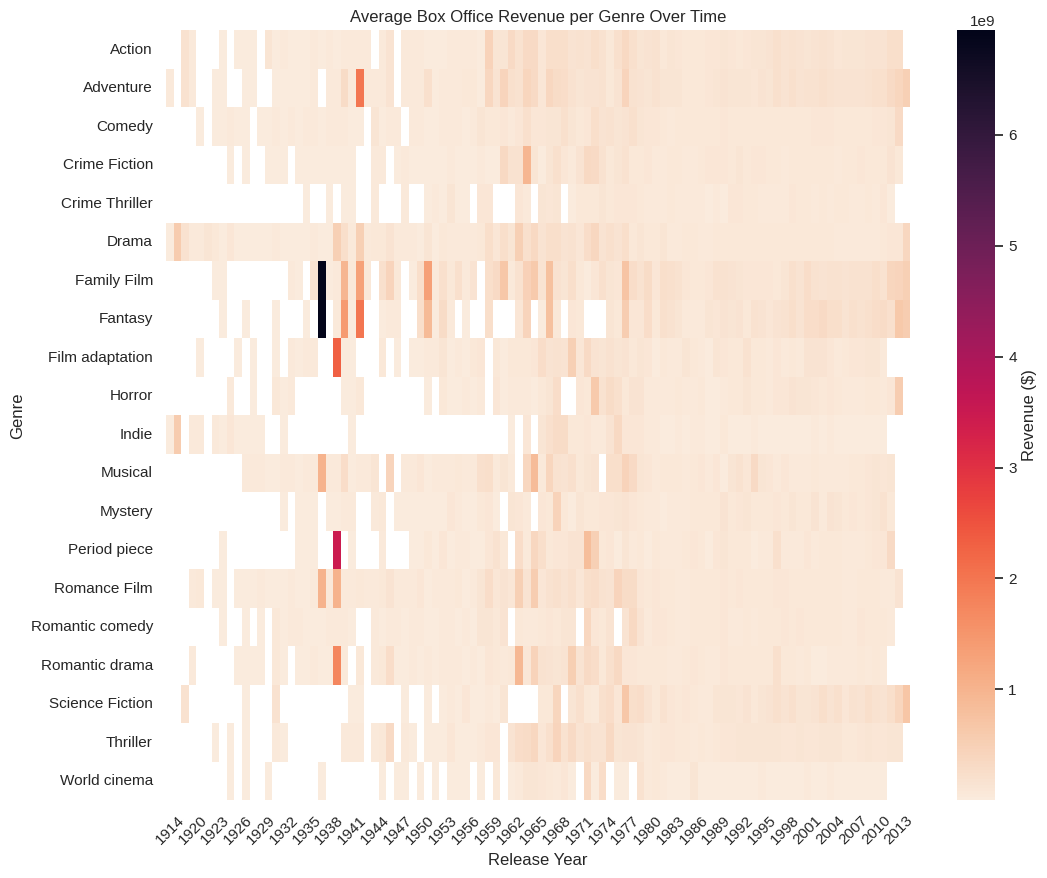

In [ ]:
# calculate the average revenue per genre and year
mean_revenue_per_genre = (
    df_top_genres.groupby(["release_year", "genres_list"])["inflated_revenue"]
    .mean()
    .reset_index()
)

# pivot the data so each genre is a column
mean_revenue_pivot = mean_revenue_per_genre.pivot(
    index="release_year", columns="genres_list", values="inflated_revenue"
).fillna(0)

# mask the years with no data
mask = mean_revenue_pivot == 0

# plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    mean_revenue_pivot.T,
    cmap="rocket_r",
    annot=False,
    mask=mask.T,
    cbar_kws={"label": "Revenue ($)"},
)

plt.title("Average Box Office Revenue per Genre Over Time")
plt.xlabel("Release Year")
plt.ylabel("Genre")
plt.xticks(rotation=45)
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - The heatmap shows the average box office revenue per genre over time, masking years with no data.
  
  - Revenue spikes are visible for genres like Family Film, Fantasy, and Period Piece in specific years, likely due to outliers.
    - The revenue spikes in 1937 in *Family Film* and *Fantasy* are due to **Snow White and the Seven Dwarfs**.
    - The revenue spike in 1939 in *Period piece* is due to **Gone with the Wind**.
  
</div>

#### Genre Ranking by Average Box Office Revenue per Decade 

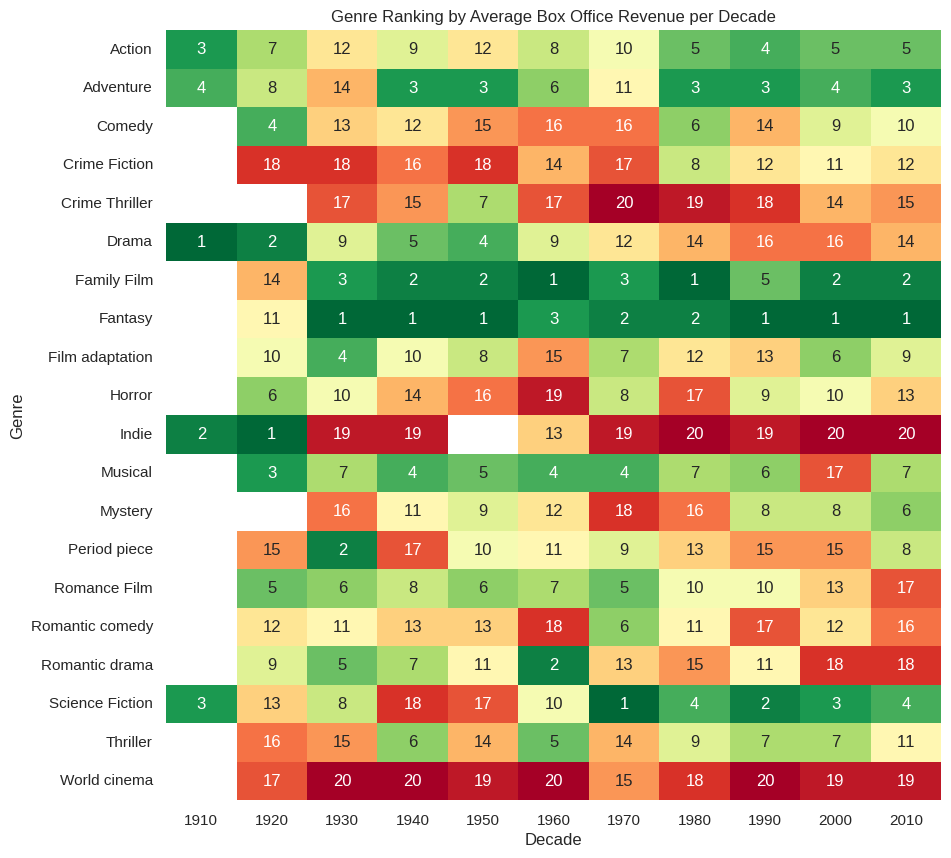

In [ ]:
# group release years into decades
df_top_genres["decade"] = df_top_genres["release_year"] // 10 * 10

# get the average revenue for each genre and decade
mean_revenue_per_genre_decade = (
    df_top_genres.groupby(["decade", "genres_list"])["inflated_revenue"]
    .mean()
    .reset_index()
)

# pivot the data so each genre is a column
mean_revenue_pivot_decade = mean_revenue_per_genre_decade.pivot(
    index="decade", columns="genres_list", values="inflated_revenue"
)

# rank the genres by average revenue per decade
rank_by_decade = mean_revenue_pivot_decade.rank(axis=1, ascending=False, method="dense")

# plot heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(
    rank_by_decade.T,
    annot=True,
    mask=rank_by_decade.T.isna(),
    cmap="RdYlGn_r",
    fmt=".0f",
    cbar=False,
)
plt.title("Genre Ranking by Average Box Office Revenue per Decade")
plt.xlabel("Decade")
plt.ylabel("Genre")
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - The heatmap shows genre rankings by average box office revenue per decade, with lower numbers (green) representing higher success.

  - Missing rankings indicate no data was available for a genre in the respective decade. 

  - The presence of duplicate rankings in some columns is due to genres with the same ranking, i.e. the same average box office revenue.

  - *Family Films* and *Fantasy* have consistently dominated since the 1930s, maintaining top rankings for multiple decades.

  - *Science Fiction* gained significant relative popularity success in the 1970s. 

  - *Indie* and *World Cinema* genres consistently ranked at the bottom, showing lower average box office revenue over time.
</div>

#### Genre Popularity over Time

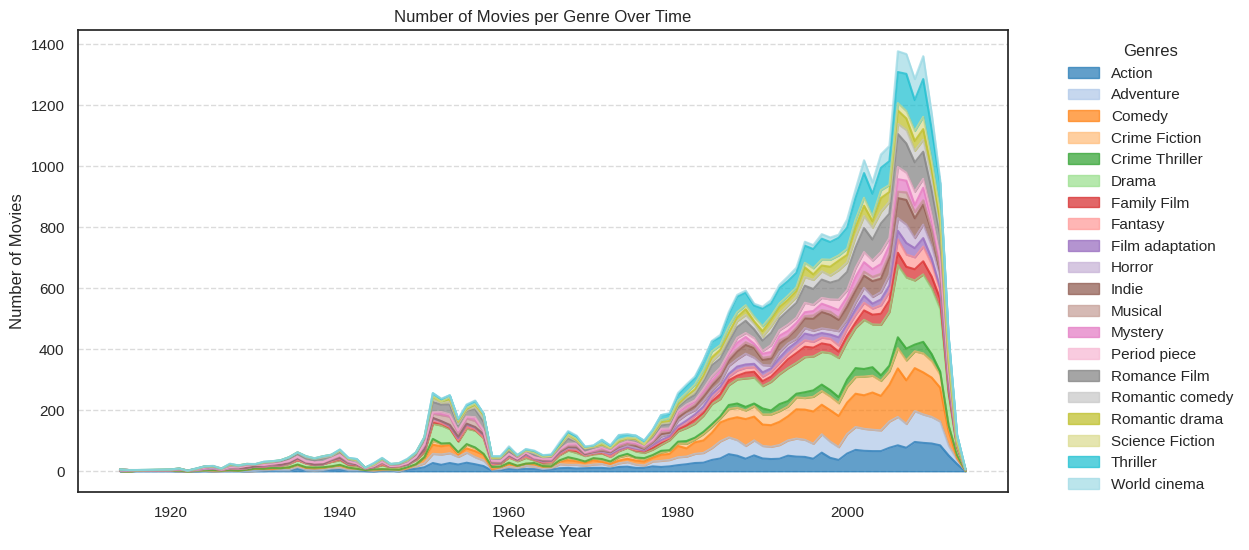

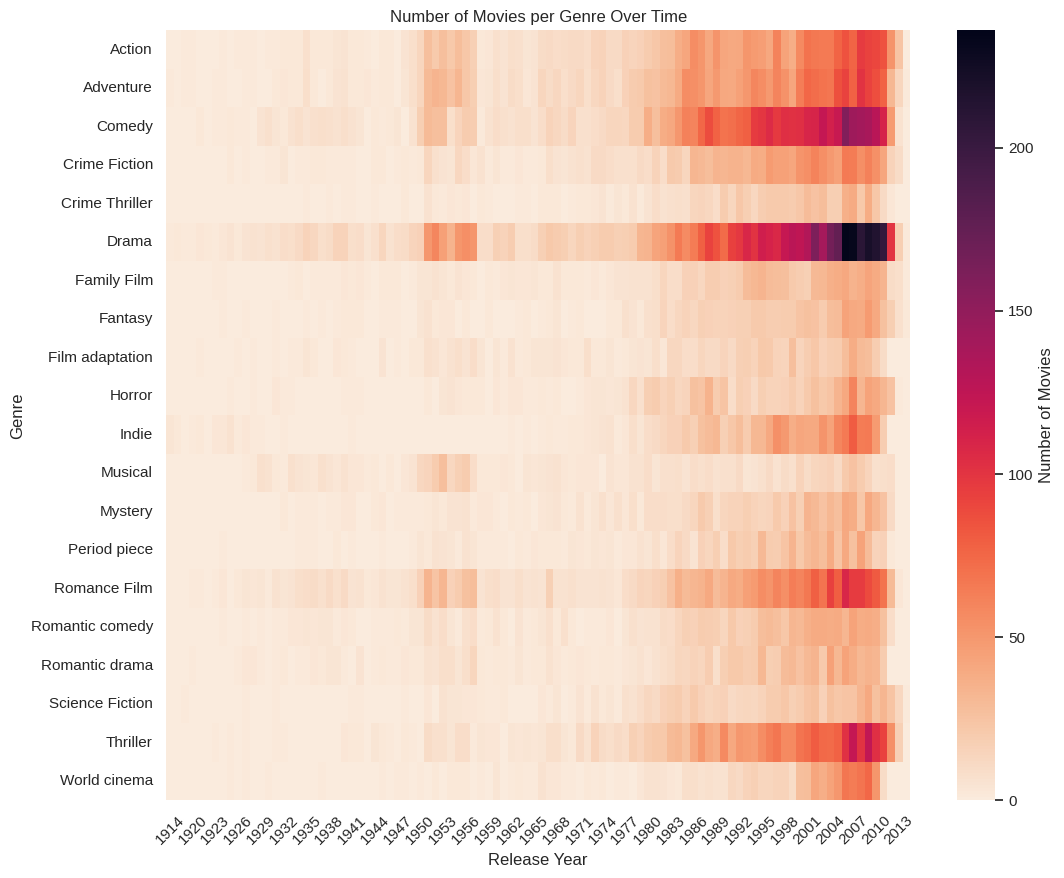

In [ ]:
# get count of movies per genre and year
genre_year_counts = (
    df_top_genres.groupby(["release_year", "genres_list"])
    .size()
    .reset_index(name="count")
)

# pivot the data for the stacked plot
genre_year_pivot = genre_year_counts.pivot(
    index="release_year", columns="genres_list", values="count"
).fillna(0)

# plot the stacked area plot
genre_year_pivot.plot.area(stacked=True, figsize=(12, 6), cmap="tab20", alpha=0.7)
plt.title("Number of Movies per Genre Over Time")
plt.xlabel("Release Year")
plt.ylabel("Number of Movies")
plt.legend(title="Genres", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.show()

# plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    genre_year_pivot.T,
    cmap="rocket_r",
    annot=False,
    cbar_kws={"label": "Number of Movies"},
)
plt.title("Number of Movies per Genre Over Time")
plt.xlabel("Release Year")
plt.ylabel("Genre")
plt.xticks(rotation=45)
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - The plot shows the number of movies produced over time across various genres.

  - We observe a notable increase in the number of movies produced over time starting in the 1970s. 

  - Additionally, there is a steep decline in the number of produced movies after 2010, which could likely be due to missing data. To ensure that the furhter analysis (correlation between genre popularity and revenue trends) is not compromised, we will focus on data up to 2010.

</div>

#### Genre Popularity and Revenue Trends over Time

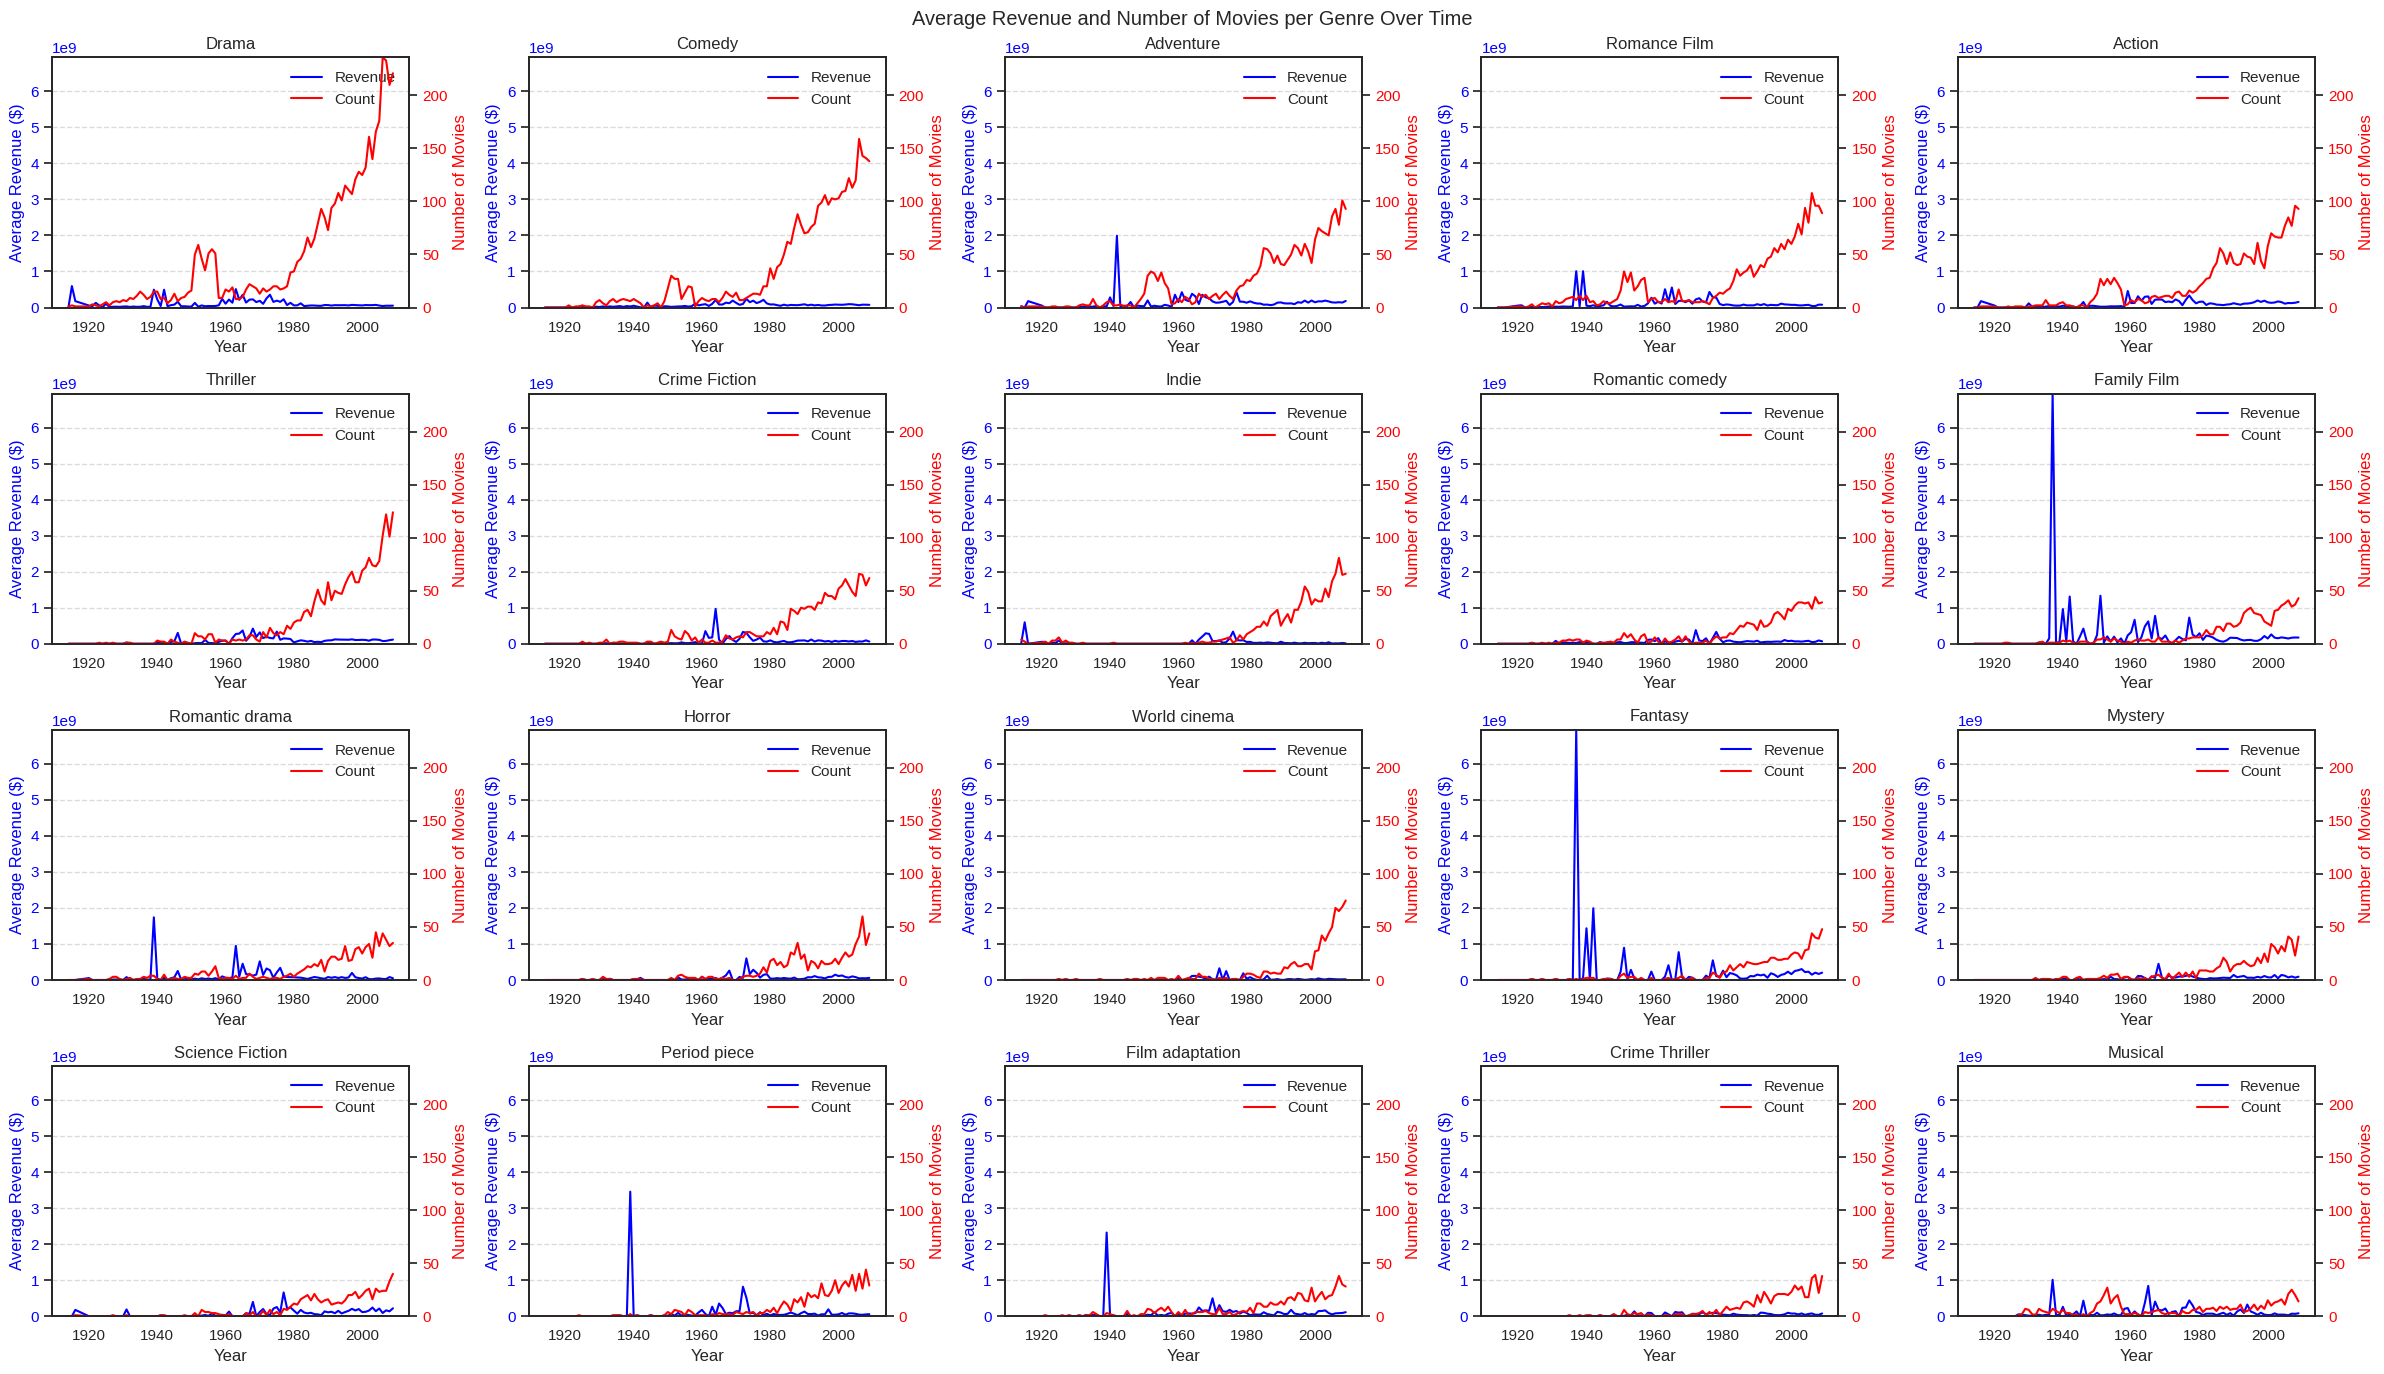

In [ ]:
# exclude the years after 2010
mean_revenue_pivot = mean_revenue_pivot[mean_revenue_pivot.index < 2010]
genre_year_pivot = genre_year_pivot[genre_year_pivot.index < 2010]

# create a facet grid plot
fig, axes = plt.subplots(4, 5, figsize=(24, 14))
axes = axes.flatten()

# extract limits for the revenue y-axis
revenue_min = mean_revenue_pivot.min().min()
revenue_max = mean_revenue_pivot.max().max()

# extract limits for the count y-axis
count_min = genre_year_pivot.min().min()
count_max = genre_year_pivot.max().max()

for ax, genre in zip(axes, top_20_genres):
    # plot average revenue on the left axis
    line_1 = ax.plot(
        mean_revenue_pivot.index,
        mean_revenue_pivot[genre],
        color="blue",
        label="Revenue",
    )
    ax.set_ylabel("Average Revenue ($)", color="blue")
    ax.tick_params(axis="y", labelcolor="blue")
    ax.set_ylim(revenue_min, revenue_max)
    ax.set_xlabel("Year")
    ax.set_title(genre)
    ax.grid(True, axis="y", linestyle="--", alpha=0.7)

    # plot number of movies on the right axis
    ax2 = ax.twinx()
    line_2 = ax2.plot(
        genre_year_pivot.index, genre_year_pivot[genre], color="red", label="Count"
    )
    ax2.set_ylabel("Number of Movies", color="red")
    ax2.tick_params(axis="y", labelcolor="red")
    ax2.set_ylim(count_min, count_max)

    # combine the legends
    lines = line_1 + line_2
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels)

plt.suptitle("Average Revenue and Number of Movies per Genre Over Time")
plt.tight_layout()
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - The plots above display the trends in the average box office revenue and the number of movies produced per genre over time.

  - As discussed before, we observe a general upward trend in the number of movies produced across most genres, starting in the 1970s.

  - However, the average revenue does not always increase proportionally with the number of movies.

  - To better understand the relationship between genre popularity and revenue over time, we will investigate their correlation in the next section.
</div>

#### Correlation between Genre Popularity and Genre Trends over Time

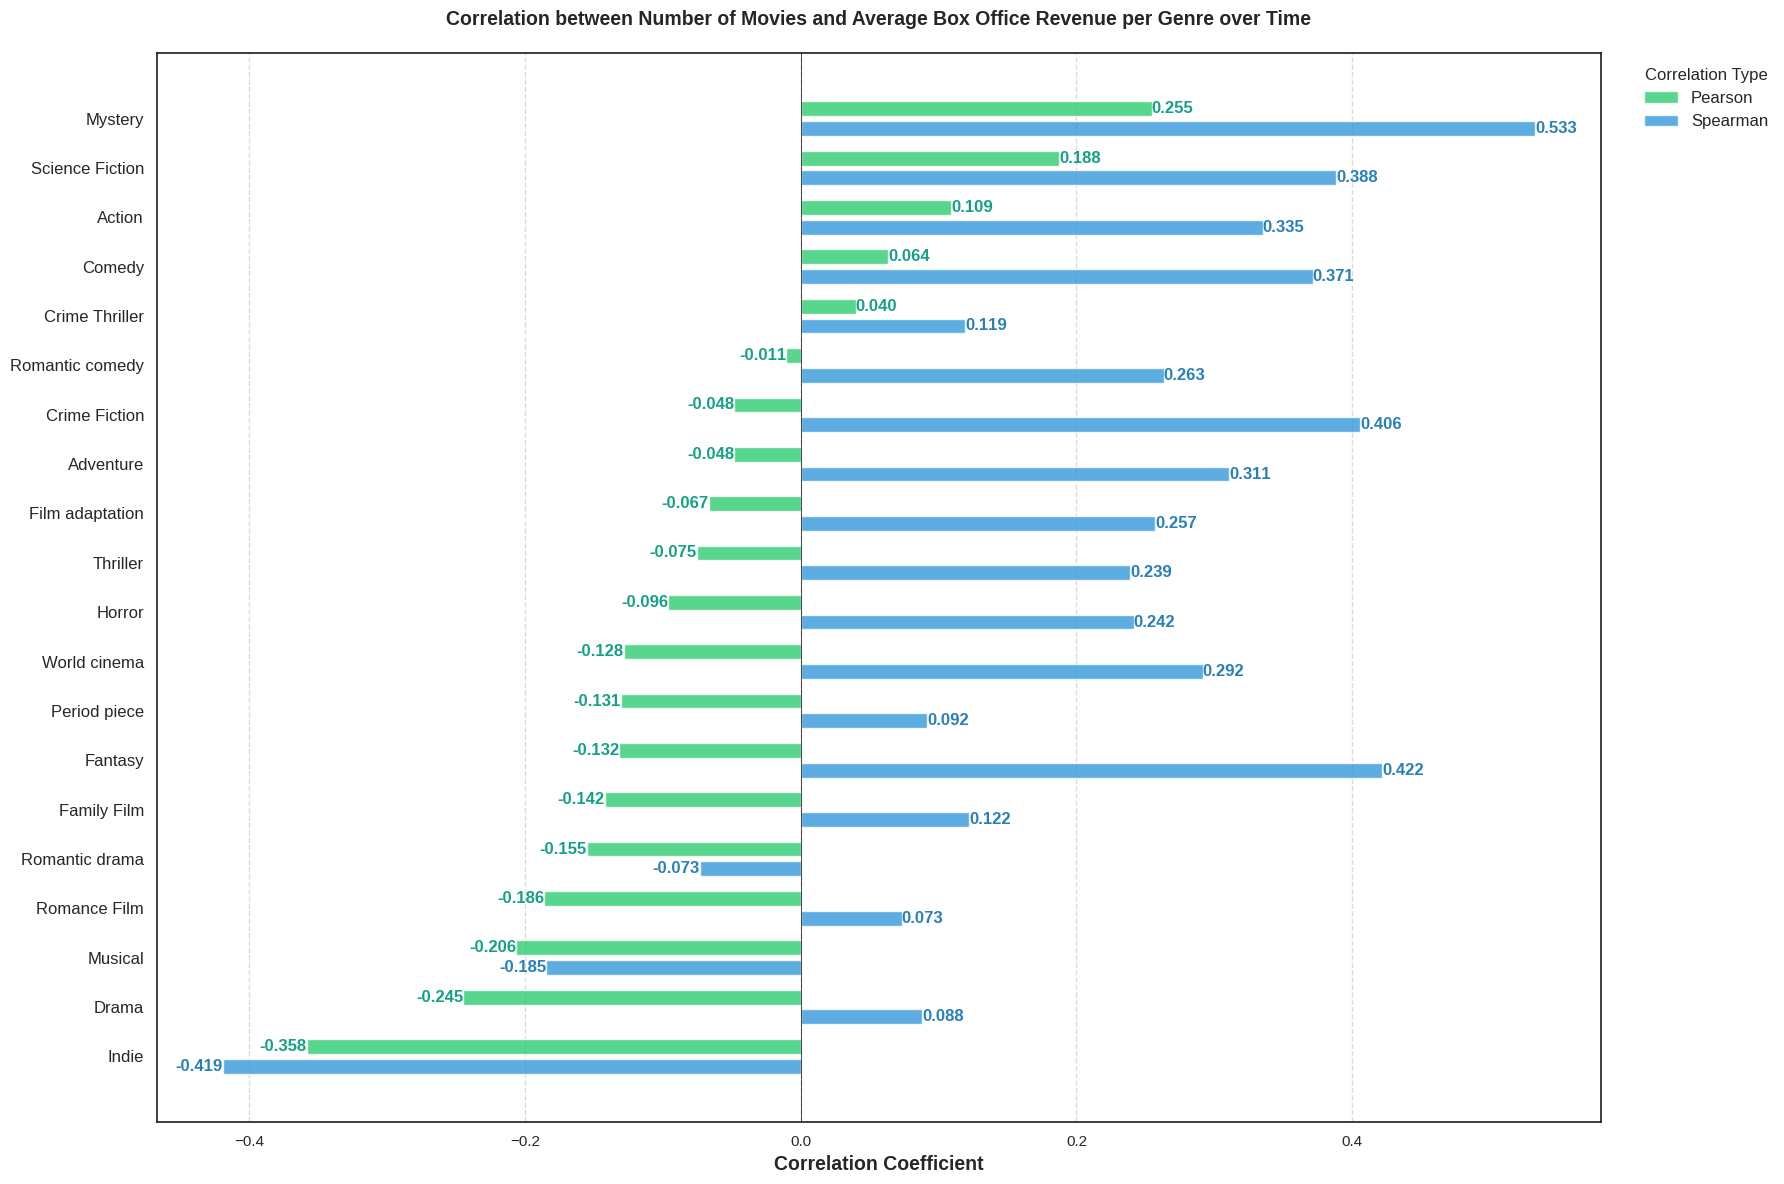

In [ ]:
correlation_df = calculate_count_revenue_correlation(
    mean_revenue_pivot, genre_year_pivot
)
plot_genre_correlation_bars(
    correlation_df,
    title="Correlation between Number of Movies and Average Box Office Revenue per Genre over Time",
)

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>
  
  - This plot displays the Pearson and Spearman correlation coefficients between the number of movies produced and the average box office revenue per genre over time.

  - Pearson correlation measures the linear relationship, while Spearman correlation captures the monotonic (rank-based) relationship.

  - Genres with positive correlations, such as *Mystery*, *Science Fiction*, and *Action*, suggest that increased production in these genres is associated with higher average revenues.

  - Genres like *Indie*, *Drama*, and *Romance Film* show negative correlations, meaning that an increase in production is accompanied by a decline in average revenue.

</div>

### Regression analysis

#### Predicting Box Office Revenue from Genres

In [ ]:
# regression input
X = df_genres[top_20_genres]
Y = df_genres["log_revenue"]

# add constant term
X = sm.add_constant(X)

# fit the model
model = sm.OLS(Y, X).fit()

# model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            log_revenue   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     116.3
Date:                Thu, 19 Dec 2024   Prob (F-statistic):               0.00
Time:                        21:43:49   Log-Likelihood:                -12222.
No. Observations:                9505   AIC:                         2.449e+04
Df Residuals:                    9484   BIC:                         2.464e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               6.9016      0.023    3

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>
  
- The model explains **19.7%** of the variance in box office revenue (R-squared), indicating that genres alone are modest predictors of revenue.

- Genres with significant positive coefficients include *Family Film*, *Adventure*, *Musical*, *Fantasy*, *Action*, and *Thriller*, all showing strong associations with higher revenue.

- On the other hand, genres with significant negative coefficients include *Indie*, *World Cinema*, and *Crime Thriller*, showing weaker revenue associations.

- The p-values indicate the statistical significance of each genre's coefficient, with lower p-values suggesting a more significant relationship with revenue. 

</div>

#### Predicting Box Office Revenue from Genres and Release Year

In [ ]:
# regression input
X = df_genres[["release_year"] + top_20_genres]
Y = df_genres["log_revenue"]

# add constant term
X = sm.add_constant(X)

# fit the model
model = sm.OLS(Y, X).fit()

# model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            log_revenue   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     122.5
Date:                Thu, 19 Dec 2024   Prob (F-statistic):               0.00
Time:                        21:43:50   Log-Likelihood:                -12123.
No. Observations:                9505   AIC:                         2.429e+04
Df Residuals:                    9483   BIC:                         2.445e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              20.3784      0.957     

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

- The R-squared increased to **21.3%** (from **19.7%**), showing a slight improvement in explaining revenue variance with the addition of release year to the linear model.
  
- The release year has a significant negative coefficient (**-0.0068**), indicating that newer movies are associated with slightly lower log-revenue.
  
- Several genres, like *Family Film*, *Adventure*, *Comedy*, and *Fantasy*, show strong positive associations with revenue, while *Indie* and *World Cinema* remain negative.
  
- Genres such as *Drama* and *Crime Fiction* remain insignificant (p > 0.05).
  
- The high condition number (**2.14e+05**) suggests possible multicollinearity.
</div>

#### Predicting Box Office Revenue from Number of Genres

In [ ]:
# regression input
X = df_genres["num_genres"]
Y = df_genres["log_revenue"]

# add constant term
X = sm.add_constant(X)

# fit the model
model = sm.OLS(Y, X).fit()

# model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            log_revenue   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     329.1
Date:                Thu, 19 Dec 2024   Prob (F-statistic):           2.49e-72
Time:                        21:43:51   Log-Likelihood:                -13102.
No. Observations:                9505   AIC:                         2.621e+04
Df Residuals:                    9503   BIC:                         2.622e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.8156      0.023    299.639      0.0

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

- Number of genres has a small but significant positive effect on revenue (coef = 0.0734, p < 0.001), suggesting each additional genre is associated with a **7.3%** increase in log-revenue.
  
- The model explains only **3.3%** of the variance (low R-squared), indicating that num_genres alone is a weak predictor of revenue.

- The relationship is statistically significant, but other factors likely play a much larger role in determining box office success.
</div>

# Movie 4: Starlight 💫 
## To what extent is a movie's box office revenue influenced by its director?

**TODO:** Feel free to modify this.

This moive aims to highlight which directors produce the most movies, which ones generate the highest total revenue and which ones achieve the best average revenue per movie.

**🏗️ Analysis Structure:**

- **Data Preparation**
  - Relevant columns
  - Handling missing values
  - Handling duplicates
  - Extra dataframes
- **Exploratory Data Analysis**
  - Top 15 directors with the highest total revenue
  - Top 15 directors with the highest average revenue
  - Top 15 directors with the most movies

- **Regression Analysis**
  - ANOVA
  - Linear Regression



### Data Preparation

#### Relevant Columns

For this analysis, we’ll focus on the following columns:
*	`director`: Add description
*	`inflated_revenue`: The box office revenue adjusted for inflation.
*	`relase_year`: Add description
*   `movie_name`: Add description

In [70]:
# select relevant columns, handle missing values and duplicates
df_dir = prepare_director_data(df)
df_dir.head()

director  inflated_revenue  release_year                movie_name
0    John Carpenter      1.899115e+07        2001.0            Ghosts of Mars
1        Henry King      6.131466e+07        1938.0  Alexander's Ragtime Band
2   Kenneth Branagh      1.967252e+07        1989.0                   Henry V
3  Robert Stevenson      7.913870e+08        1964.0              Mary Poppins
5    John Singleton      3.982571e+07        2001.0                  Baby Boy

#### Extra Dataframes

In [71]:
director_stats = (
    df_dir.groupby("director")
    .agg(
        avg_revenue=("inflated_revenue", "mean"),
        total_revenue=("inflated_revenue", "sum"),
        max_revenue=("inflated_revenue", "max"),
        movie_count=("inflated_revenue", "count"),
    )
    .reset_index()
)  # to facilitate further analysis and visualization, we will use this dataframe
director_stats

director   avg_revenue  total_revenue   max_revenue  \
0        A.R. Murugadoss  4.269914e+07   8.539827e+07  8.472054e+07   
1          Aanand L. Rai  2.688807e+05   2.688807e+05  2.688807e+05   
2           Aaron Blaise  3.266896e+08   3.266896e+08  3.266896e+08   
3             Aaron Katz  1.785506e+04   1.785506e+04  1.785506e+04   
4           Aaron Norris  1.220393e+07   7.322359e+07  2.938651e+07   
...                  ...           ...            ...           ...   
3231  Álex de la Iglesia  5.210798e+06   1.042160e+07  6.878906e+06   
3232      Élie Chouraqui  1.097529e+06   1.097529e+06  1.097529e+06   
3233    Émile Gaudreault  3.955537e+06   3.955537e+06  3.955537e+06   
3234          Éva Gárdos  1.152448e+06   1.152448e+06  1.152448e+06   
3235          Özhan Eren  4.141217e+06   4.141217e+06  4.141217e+06   

      movie_count  
0               2  
1               1  
2               1  
3               1  
4               6  
...           ...  
3231            2  
3232            1  
3233            1  
3234            1  
3235            1  

[3236 rows x 5 columns]

### Exploratory Data Analysis

<div class="alert alert-success">

  💭 <strong>Idea:</strong>
  
  - Is the same director responsible for the top revenue movies each year?
  - Is it luck or skill? Does a director that produced a top revenue movie once, do it again?
  - Does the director's get better with time?

</div>
<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>
  - Exploration of the director column
    - The average revenue of the director's movies ?
    - The total revenue of the director's movies ?
    - The revenue of the director's most successful movie ?
  - Analyse the top revenue movies and director
    - Does the top revenue movies each year have the same director?
    - What about if we consider the top 5 revenue movies?
  - Does the director's get better with time?
    - Analyse the average revenue of the director's movies over time 
      - for directors that produced the most movies
      - for directors that produced the most revenue
      - for directors that produced the most successful movies
      - for directors that produced the most average revenue movie
</div>

#### What is the highest inflated revenue each year?

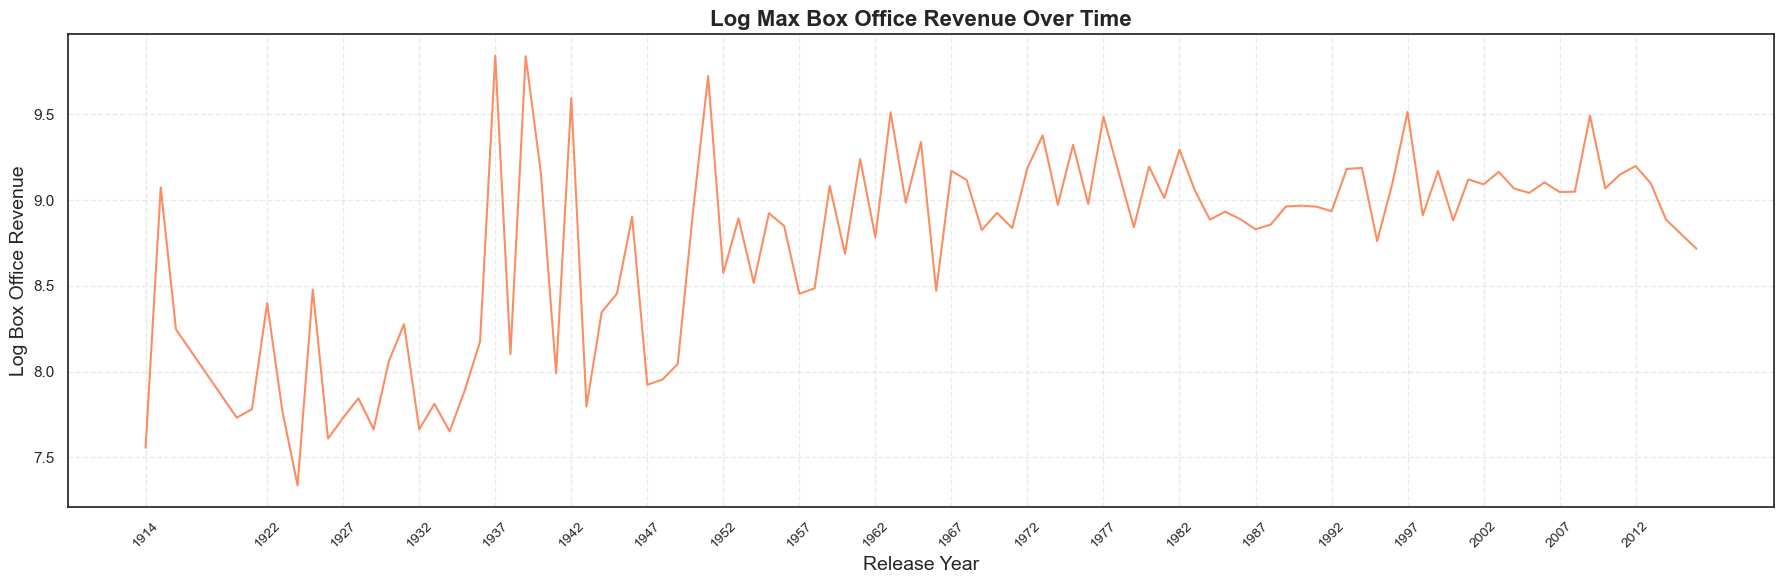

In [72]:
plt.figure(figsize=(18, 6))

# Compute the maximum inflated revenue per year and take its log10
yearly_inflated_avg = df.groupby("release_year")["inflated_revenue"].max()
yearly_inflated_avg = np.log10(yearly_inflated_avg)

# Use Seaborn lineplot with Set2 color palette
sns.lineplot(
    x=yearly_inflated_avg.index,
    y=yearly_inflated_avg.values,
    color=sns.color_palette("Set2")[1],
)

# Improve the title, labels, and grid aesthetics
plt.title("Log Max Box Office Revenue Over Time", fontsize=16, weight="bold")
plt.xlabel("Release Year", fontsize=14)
plt.ylabel("Log Box Office Revenue", fontsize=14)

# Adjust x-axis ticks for readability
plt.xticks(
    yearly_inflated_avg.index[::5], rotation=45, fontsize=10
)  # Show ticks every 5 years

# Add grid with improved style
plt.grid(True, alpha=0.4, linestyle="--")

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

Surprising ! We can observe picks in 1937 and 1939. Let's check the movie and the director.

In [73]:
director_stats.sort_values("max_revenue", ascending=False).head(2)

director   avg_revenue  total_revenue   max_revenue  movie_count
3158  William Cottrell  6.941575e+09   6.941575e+09  6.941575e+09            1
3098    Victor Fleming  1.410782e+09   7.053910e+09  6.902543e+09            5

In [74]:
df_dir[df_dir["director"] == "William Cottrell"].sort_values(
    "inflated_revenue", ascending=False
).head(2)

director  inflated_revenue  release_year  \
1411  William Cottrell      6.941575e+09        1937.0   

                           movie_name  
1411  Snow White and the Seven Dwarfs

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>
  
  They are really close! We will expect to see more famous directors like Spielberg, Cameron, Nolan or Tarantino. We might need to analyse the data deeper to clearly see the impact of the director on the revenue. We will take a look at the total revenue of the directors, movie counts and the average revenue of the movies. We should also analyse the timeline of the directors to observe trends for certain epochs.
</div>


#### Which directors generate the most revenue?

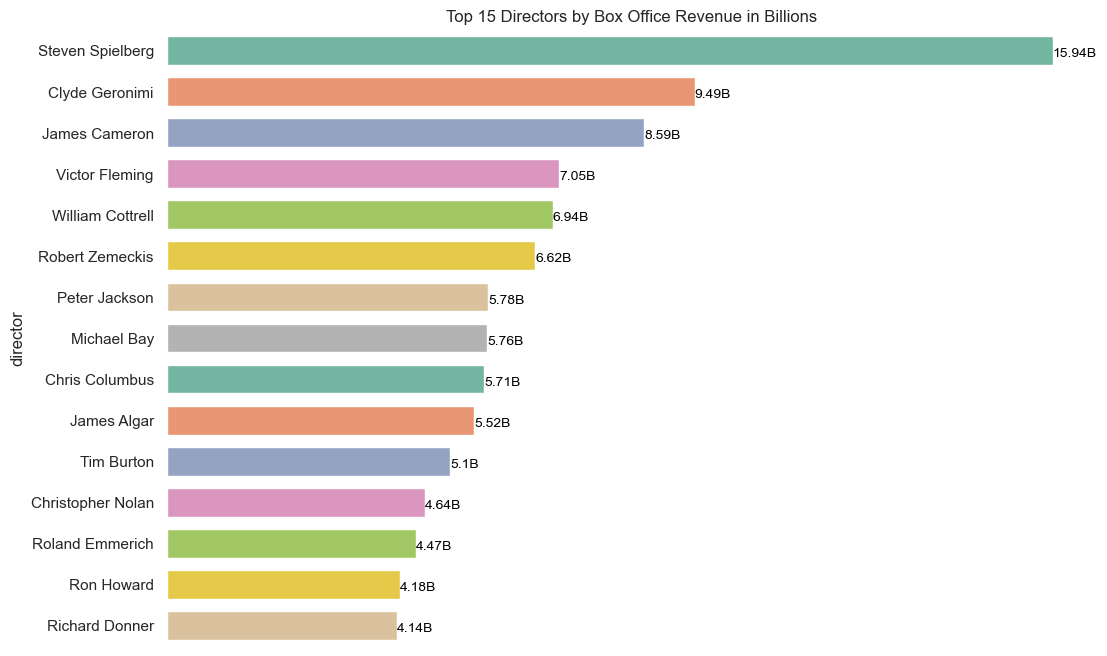

In [75]:
df_top_dir = director_stats.nlargest(15, "total_revenue")
df_top_dir.reset_index(inplace=True)
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    y="director", x="total_revenue", data=df_top_dir, width=0.7, palette="Set2"
)
ax.xaxis.set_visible(False)
ax.set_title("Top 15 Directors by Box Office Revenue in Billions")
for i in ax.patches:
    ax.text(
        i.get_width() + 0.5,
        i.get_y() + 0.5,
        str(round(i.get_width() / 1e9, 2)) + "B",
        fontsize=10,
        color="black",
    )
plt.box(False)

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>
  

In the dataset, Steven Spielberg is observed as the director with the highest total revenue. This aligns with his recognition as one of the most commercially successful directors in history. As noted on Wikipedia:

> "Spielberg is widely regarded as one of the greatest film directors of all time and is the most commercially successful director in film history."  
> — Source: [Wikipedia, "Steven Spielberg"](https://en.wikipedia.org/wiki/Steven_Spielberg)

This observation supports the dataset’s accuracy and highlights Spielberg’s significant impact on the film industry.

</div>


#### Which directors produce the most movies?

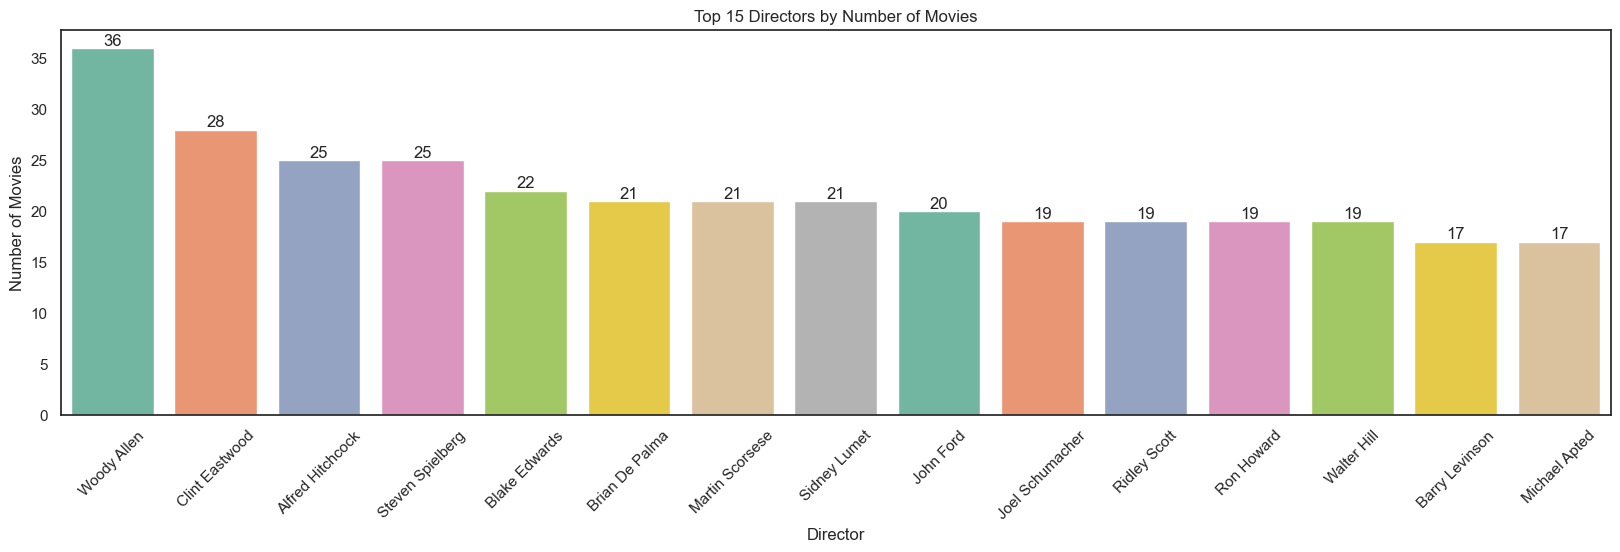

In [77]:
df_count = director_stats.nlargest(15, "movie_count").reset_index()
# plot top 15 directors by average revenue
plt.figure(figsize=(20, 5))
ax = sns.barplot(x="director", y="movie_count", data=df_count, palette="Set2")
plt.xticks(rotation=45)
plt.xlabel("Director")
plt.ylabel("Number of Movies")
plt.title("Top 15 Directors by Number of Movies")
# add the number of movies above each bar
for i, v in enumerate(df_count["movie_count"]):
    ax.text(i, v, str(v), ha="center", va="bottom")
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>
  
  - Indeed, we can see a lot of famous directors in the list. Which makes sense, if a movie is successful, the director is more likely to produce more movies.

#### Who generated the best average revenue per movie?

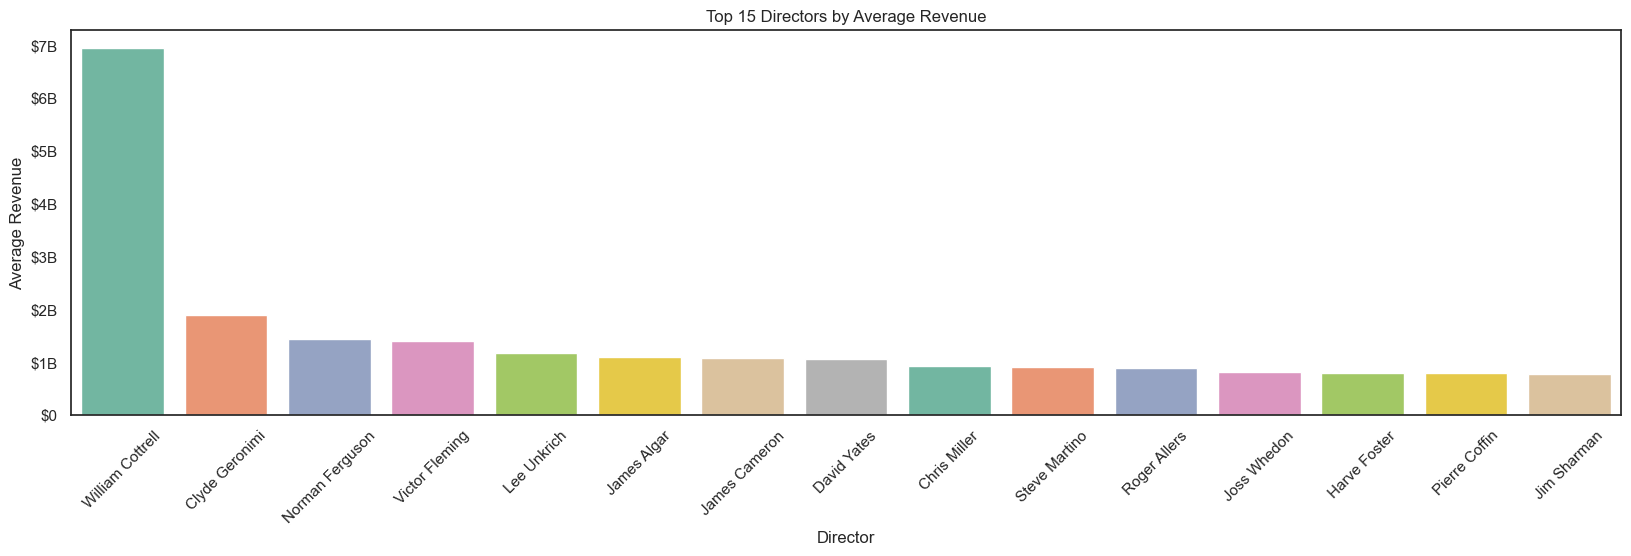

In [78]:
# plot top 15 revenue generating directors average revenue
df_mean = director_stats.nlargest(15, "avg_revenue")

# plot top 15 directors by average revenue
plt.figure(figsize=(20, 5))
ax = sns.barplot(x="director", y="avg_revenue", data=df_mean, palette="Set2")
plt.xticks(rotation=45)
plt.xlabel("Director")
plt.ylabel("Average Revenue")
plt.title("Top 15 Directors by Average Revenue")
plt.gca().yaxis.set_major_formatter(revenue_formatter)
plt.show()

We would expect that the directors with the highest average revenue per movie to be famous directors. Let's check if this is the case.

In [79]:
df_dir[df_dir["director"] == "William Cottrell"].sort_values(
    "inflated_revenue", ascending=False
)

director  inflated_revenue  release_year  \
1411  William Cottrell      6.941575e+09        1937.0   

                           movie_name  
1411  Snow White and the Seven Dwarfs

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

- Average revenue per movie is not a reliable metric for analyzing a director's box office success. For directors with only one movie, it equals total revenue, exaggerating their impact. Additionally, the dataset is incomplete, limiting its representation of each director's career.
</div>

### Analysis

#### ANOVA

In [ ]:
anova_model = ols("inflated_revenue ~ C(director)", data=df_dir).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)
print(anova_table)

                   sum_sq      df         F        PR(>F)
C(director)  1.850862e+20  3235.0  1.382908  3.121899e-24
Residual     1.922143e+20  4646.0       NaN           NaN


<div class="alert alert-info">
  💡 <strong>Discussion:</strong>
  
  - Since the p-value is $ 3.12 \cdot 10^{-24} $, which is much smaller than 0.05, we reject the null hypothesis. This means that directors have a significant influence on box office revenue.
</div>



#### Regression analysis

In [ ]:
X = df_dir["director"]
X = pd.get_dummies(X, drop_first=True).astype(int)
y = np.log10(df_dir["inflated_revenue"])  # log-transform the revenue

X = sm.add_constant(X)  # add a constant to the model (intercept)

model = sm.OLS(y.values, X.values).fit()  # fit the linear regression model

print(
    model.summary().tables[0]
)  # there was a lot of variable so we will only print the first table

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     3.734
Date:                Wed, 18 Dec 2024   Prob (F-statistic):               0.00
Time:                        16:02:35   Log-Likelihood:                -5754.9
No. Observations:                7882   AIC:                         1.798e+04
Df Residuals:                    4646   BIC:                         4.054e+04
Df Model:                        3235                                         
Covariance Type:            nonrobust                                         


<div class="alert alert-info">
  💡 <strong>Discussion:</strong>
  
  - The regression analysis demonstrates that the model explains approximately 69.3% of the variance in log-transformed box office revenue, with an adjusted R-squared of <strong>0.529</strong>. This adjusted R-squared value indicates that nearly half of the variability in box office revenue can be attributed to the directors in the model, which is a strong result for a dataset with many potential influencing factors.

  - The statistical significance of the overall model (p-value < 0.001) confirms that directors collectively have a meaningful impact on box office revenue. However, the model includes a large number of predictors (3257 unique directors), which adds complexity
</div>


# Movie 5: Waves 🌊 
## How much is a movie’s box office revenue influenced by its release timing and duration?

This moive aims to provide insights into the influence of a movie’s release season on its success. It also examines the impact of the movie’s runtime for each season individually and breaks down these factors by genre.

**🏗️ Analysis Structure:**

- **Data Preparation**
  - **Columns:** We use `movie_genres`, `inflated_revenue`, `release_year`. Additionally, we create a `log_revenue` column for log-transformed revenue.
  - **Missing Data:** Entries with missing values are removed
  - **Handling duplicates:** Duplicate entries are removed
  - **Genres:** Genre strings are converted to lists. Duplicate genres are removed from the lists. Additionally, we drop the movies with empty genre lists.
  - **Seasons:** The release months are grouped into seasons (Winter, Spring, Summer, Fall).
- **Exploratory Data Analysis**
  - **Distribution of Movie Revenues**: Analyze the distribution of movie revenues.
  - **Average Box Office Revenue per Season**: Investigate the average box office revenue per season.
  - **Relationship between Movie Runtime and Revenue (by Season)**: Explore the relationship between movie runtime and revenue for each season.
  - **Top 10 Genres by Revenue**: Identify the top 10 genres by average revenue.
  - **Average Revenue per Genre and Season**: Analyze the average revenue per genre for each season.
  - **Revenue vs. Duration by Season**: Visualize the relationship between revenue and duration for each season.
  - **Average Movie Revenue by Release Day of the Week**: Investigate the average revenue based on the release day of the week.
  - **Genre Popularity Over Time**: Analyze the popularity of genres over time by number of movies released.
  - **Genre Popularity per Season**: Explore the popularity of genres per season.
  - **ANOVA for Seasons**: Perform an ANOVA analysis to determine if there are statistically significant differences in revenue across seasons.
  - **ANOVA for Genres**: Perform ANOVA analyses for the primary genres to determine if there are statistically significant differences in revenue across genres.
  - **Revenue Distribution by Season**: Visualize the distribution of revenue for each season.
  

### Data Preparation

#### Relevant Columns
For this analysis, we’ll focus on the following columns:
*	`movie_release_date`: Release date of the movie
*	`inflated_revenue`: Inflated box office revenue
*   `release_day`: Day of the week when the movie was released
*   `release_month`: Month when the movie was released
*   `release_year`: Year when the movie was released
*   `movie_genres`: Genres of the movie
*   `movie_runtime`: Runtime of the movie in minutes

In [3]:
# select relevant columns, handle missing values and duplicates, define the season column, and ensure numeric inputs
df_season = prepare_seasonal_data(df)
df_season.head()

movie_release_date  inflated_revenue  release_day  release_month  \
0         2001-08-24      1.899115e+07         24.0            8.0   
1         1938-08-16      6.131466e+07         16.0            8.0   
2         1989-11-08      1.967252e+07          8.0           11.0   
3         1964-08-27      7.913870e+08         27.0            8.0   
4         1999-10-01      3.100822e+04          1.0           10.0   

   release_year                                       movie_genres  \
0        2001.0  [('/m/01jfsb', 'Thriller'), ('/m/06n90', 'Scie...   
1        1938.0  [('/m/04t36', 'Musical'), ('/m/01z4y', 'Comedy...   
2        1989.0  [('/m/04xvh5', 'Costume drama'), ('/m/082gq', ...   
3        1964.0  [('/m/0hj3myq', "Children's/Family"), ('/m/04t...   
4        1999.0  [('/m/01jfsb', 'Thriller'), ('/m/06n90', 'Scie...   

   movie_runtime  season  log_revenue  
0           98.0  Summer     7.278551  
1          106.0  Summer     7.787564  
2          137.0    Fall     7.293860  
3          139.0  Summer     8.898389  
4           92.0    Fall     4.491477

### Exploratory Data Analysis

<div class="alert alert-success">

  💭 <strong>Idea:</strong>
  - Are the revenues and the popularities of genres affected by the season of the year?
  - Is the movie runtime affected by the season, and does it have any affect on revenue?

  
</div>
<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>

  - Distribution plots, bar plots, scatter plots

</div>

#### Distribution of Movie Revenues

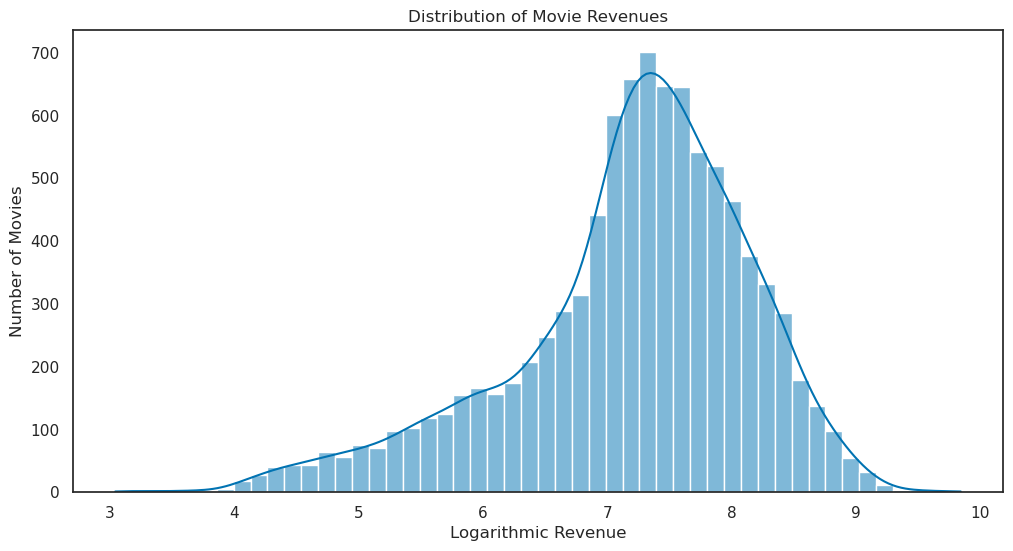

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(df_season["log_revenue"], bins=50, kde=True)
plt.title("Distribution of Movie Revenues")
plt.xlabel("Logarithmic Revenue")
plt.ylabel("Number of Movies")
plt.show()

#### Average Box Office Revenue per Season

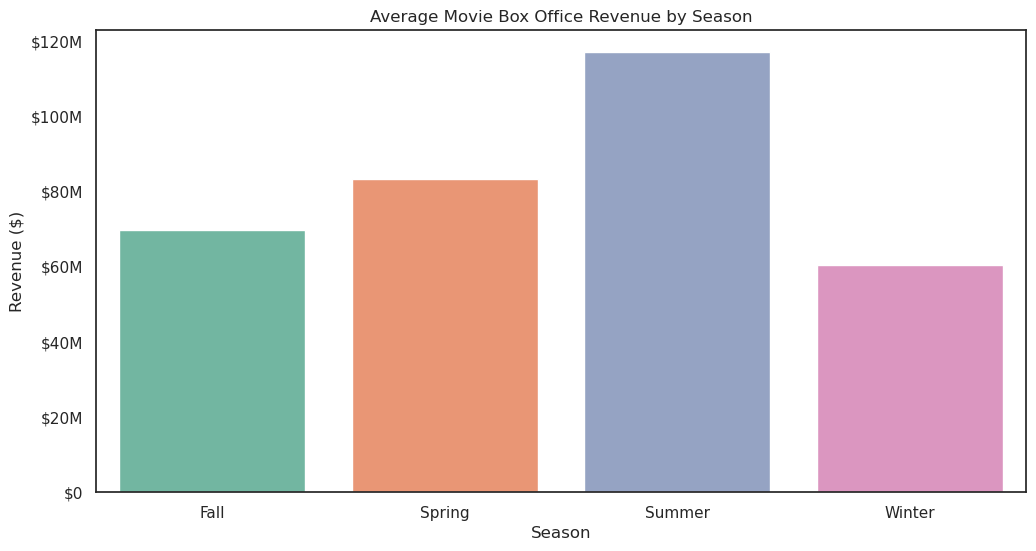

In [ ]:
# get the average revenue for each season
season_revenue = df_season.groupby("season")["inflated_revenue"].mean().reset_index()

# plot the average revenue per season
plt.figure(figsize=(12, 6))
sns.barplot(x="season", y="inflated_revenue", data=season_revenue, palette="Set2")
plt.title("Average Movie Box Office Revenue by Season")
plt.xlabel("Season")
plt.ylabel("Revenue ($)")
plt.gca().yaxis.set_major_formatter(revenue_formatter)
plt.show()

#### Relationship between Movie Runtime and Revenue (by Season)

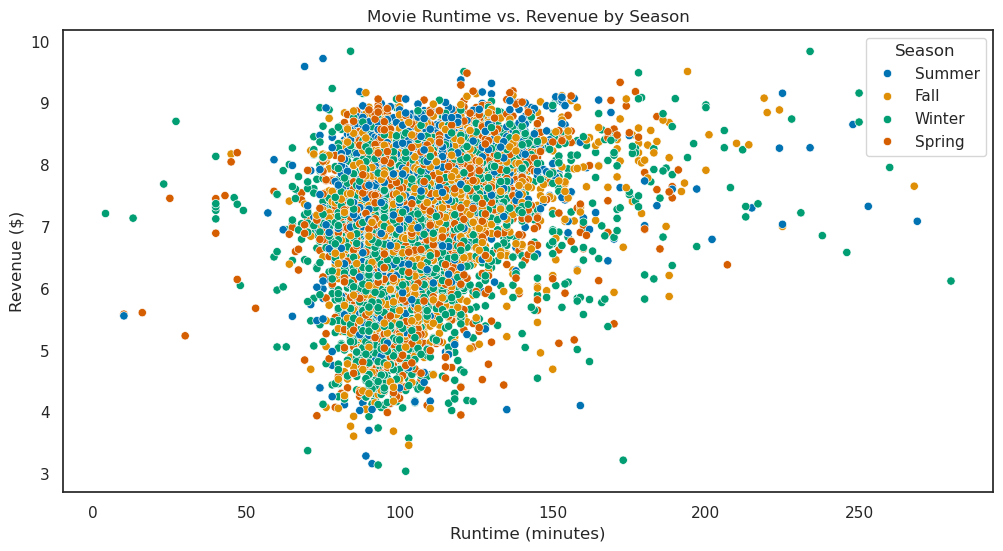

In [ ]:
# filtered df_season to remove outlier movies with runtime > 300 minutes
df_season_filtered = df_season[df_season["movie_runtime"] <= 300]
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x="movie_runtime", y="log_revenue", hue="season", data=df_season_filtered
)
plt.title("Movie Runtime vs. Revenue by Season")
plt.xlabel("Runtime (minutes)")
plt.ylabel("Revenue ($)")
plt.legend(title="Season")
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>
  
  - The initial observations show that the summer movies have higher revenue.   

</div>

#### Genre analysis

<div class="alert alert-success">

  💭 <strong>Idea:</strong>
  - How does the genre affect the revenue?
  - Does the season affect the revenue and the genre?
  - Does the release day of the week have any affect on the revenue?
  - Did the genre popularity change over the years?
  
</div>
<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>
  - Bar graps, heatmaps, scatter plots

</div>

#### Top 10 Genres by Revenue

In [ ]:
# convert the string representation to an actual list
df_genres_and_season = df_season.copy()

# ensure that the 'movie_genres' column is not null
df_genres_and_season = df_genres_and_season[
    df_genres_and_season["movie_genres"].notna()
]

# apply ast.literal_eval to convert strings to lists
df_genres_and_season["movie_genres"] = df_genres_and_season["movie_genres"].apply(
    ast.literal_eval
)

# extract the genre names
df_genres_and_season["movie_genres"] = df_genres_and_season["movie_genres"].apply(
    lambda x: [genre[1] for genre in x]
)

# explode the genres
df_genres_and_season = df_genres_and_season.explode("movie_genres")

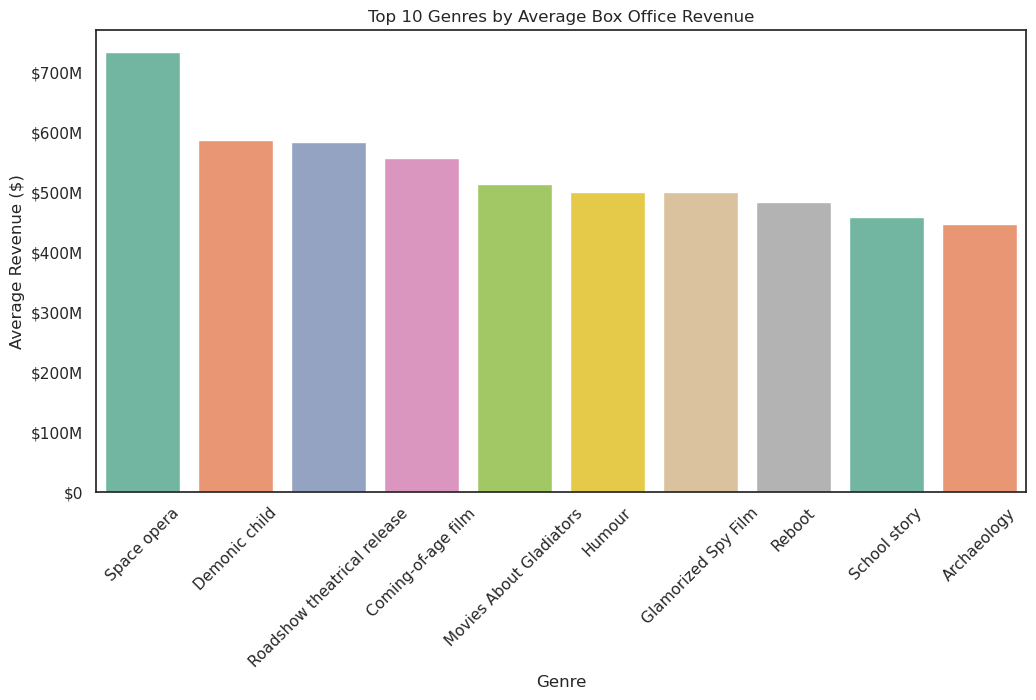

In [ ]:
genre_revenue = (
    df_genres_and_season.groupby("movie_genres")["inflated_revenue"]
    .mean()
    .reset_index()
)
top_genres = genre_revenue.sort_values("inflated_revenue", ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x="movie_genres", y="inflated_revenue", data=top_genres, palette="Set2")
plt.title("Top 10 Genres by Average Box Office Revenue")
plt.xlabel("Genre")
plt.ylabel("Average Revenue ($)")
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(revenue_formatter)
plt.show()

#### Average Revenue per Genre and Season

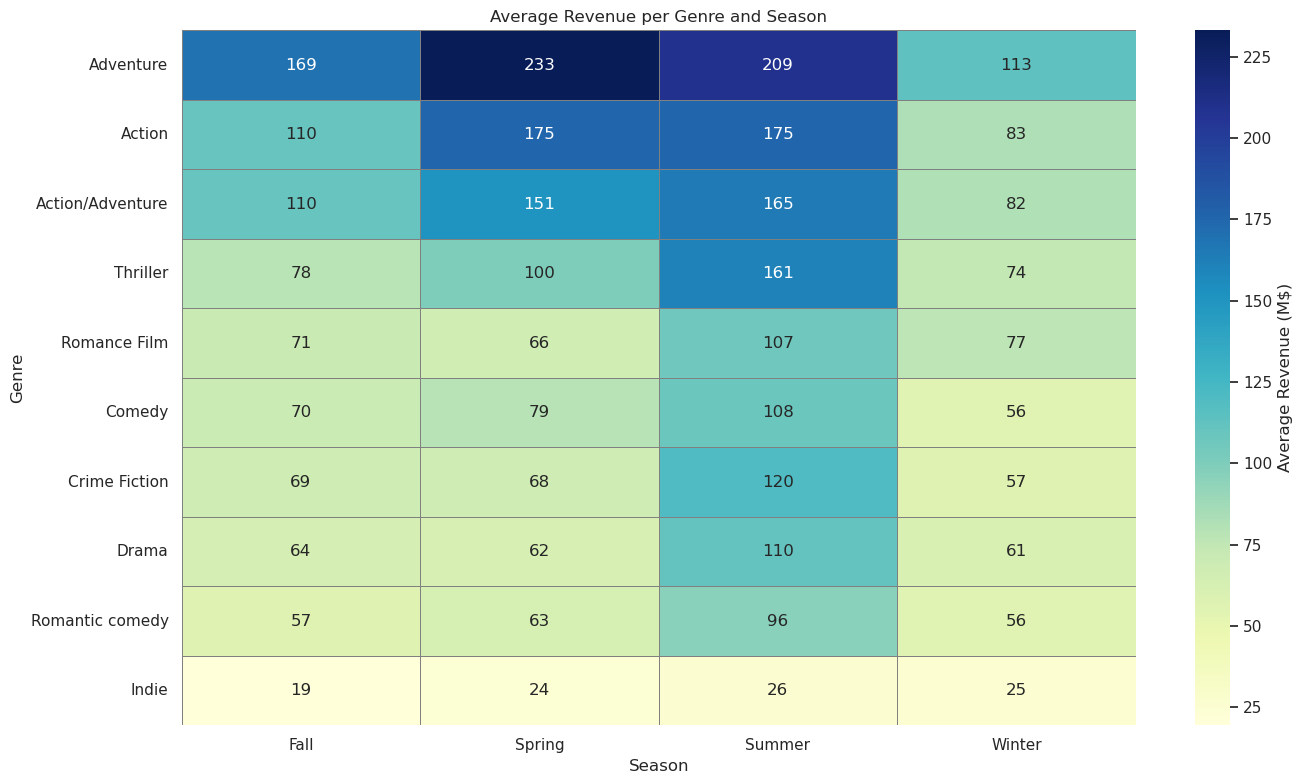

In [ ]:
# convert string representation to actual list
df_genres_and_season = df_season.copy()
df_genres_and_season["movie_genres"] = df_genres_and_season["movie_genres"].apply(
    ast.literal_eval
)
df_genres_and_season["movie_genres"] = df_genres_and_season["movie_genres"].apply(
    lambda x: [genre[1] for genre in x]
)
df_genres_and_season = df_genres_and_season.explode("movie_genres")

# get top 10 genres by frequency
top_genres_list = (
    df_genres_and_season["movie_genres"].value_counts().head(10).index.tolist()
)
df_top_genres = df_genres_and_season[
    df_genres_and_season["movie_genres"].isin(top_genres_list)
]

pivot_table = df_top_genres.pivot_table(
    values="inflated_revenue",
    index="movie_genres",
    columns="season",
    aggfunc="mean",
)

# calculate average revenue per genre
genre_revenue = (
    df_top_genres.groupby("movie_genres")["inflated_revenue"].mean().reset_index()
)
sorted_genres = genre_revenue.sort_values("inflated_revenue", ascending=False)[
    "movie_genres"
]

# reorder the pivot table
pivot_table = pivot_table.reindex(index=sorted_genres)

# plot the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(
    pivot_table / 1e6,
    annot=True,
    fmt=".0f",
    cmap="YlGnBu",
    linewidths=0.5,
    linecolor="gray",
    cbar_kws={"label": "Average Revenue (M$)"},
)
plt.title("Average Revenue per Genre and Season")
plt.xlabel("Season")
plt.ylabel("Genre")
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

#### Average Revenue per Genre and Season (Bar Plot)

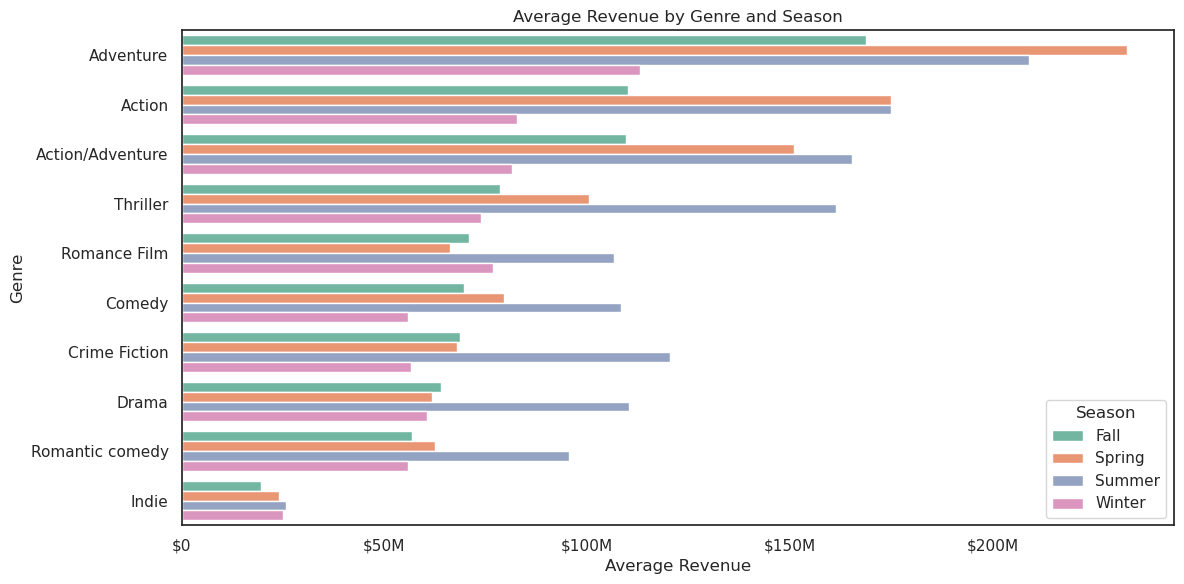

In [ ]:
# reset index for plotting
pivot_table_reset = pivot_table.reset_index().melt(
    id_vars="movie_genres", var_name="Season", value_name="Average Revenue"
)

plt.figure(figsize=(12, 6))
sns.barplot(
    x="Average Revenue",
    y="movie_genres",
    hue="Season",
    data=pivot_table_reset,
    palette="Set2",
)
plt.title("Average Revenue by Genre and Season")
plt.xlabel("Average Revenue")
plt.ylabel("Genre")
plt.legend(title="Season")
plt.tight_layout()
plt.gca().xaxis.set_major_formatter(revenue_formatter)
plt.show()

#### Average Revenue per Genre and Season (Top 10 Genres)

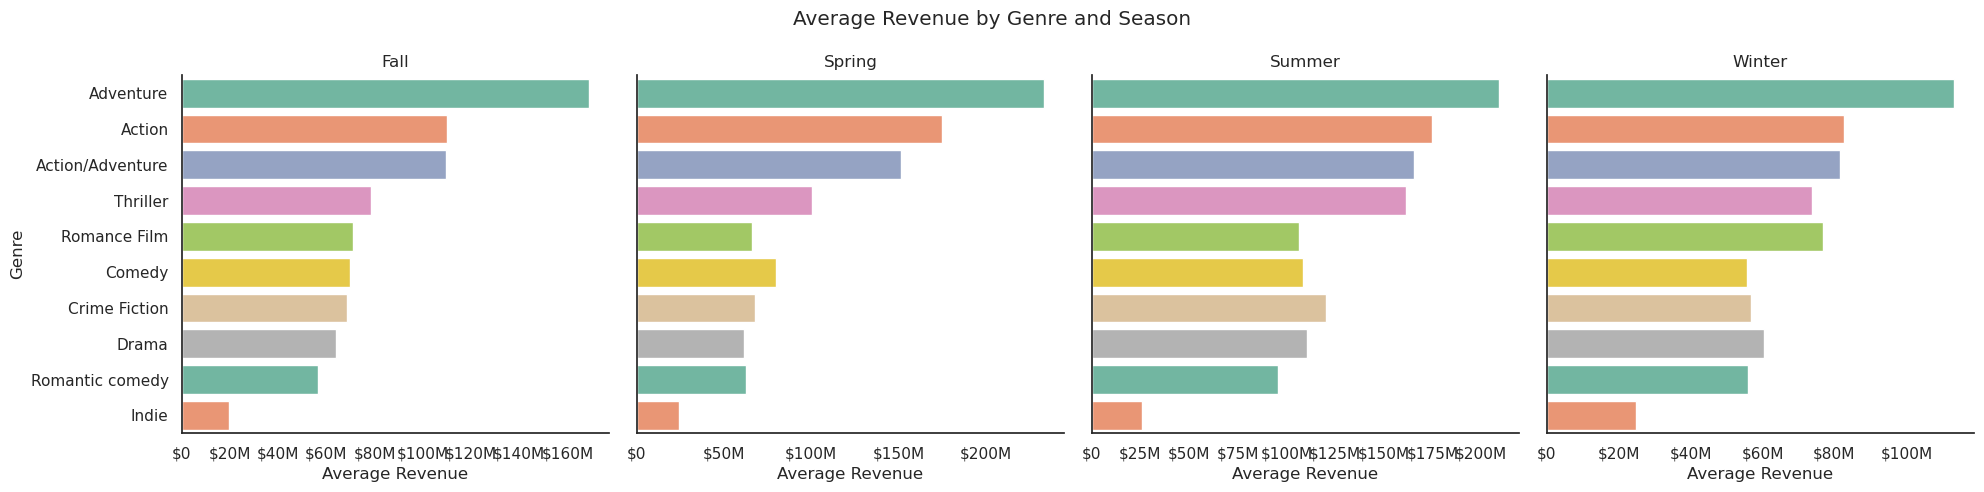

In [ ]:
g = sns.FacetGrid(
    pivot_table_reset, col="Season", sharex=False, sharey=True, height=5, aspect=1
)
g.map_dataframe(
    sns.barplot,
    x="Average Revenue",
    y="movie_genres",
    order=sorted_genres,
    palette="Set2",
)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Average Revenue", "Genre")
g.set(yticks=sorted_genres)

# apply revenue_formatter to each subplot's x-axis
for ax in g.axes.flat:
    ax.xaxis.set_major_formatter(plt.FuncFormatter(revenue_formatter))

plt.suptitle("Average Revenue by Genre and Season")
plt.tight_layout()
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

   - For most of the genres, the average revenue is higher for Spring and Summer seasons.
   - Most of the genres kept the same ranks for the seasons. However, the Romance genre has a significant peak in the Winter season, which might be due to the effect of Valentine's Day and Family Holidays such as Thanksgiving and Christmas.


</div>

#### Revenue vs. Duration by Season

<Figure size 1200x600 with 0 Axes>

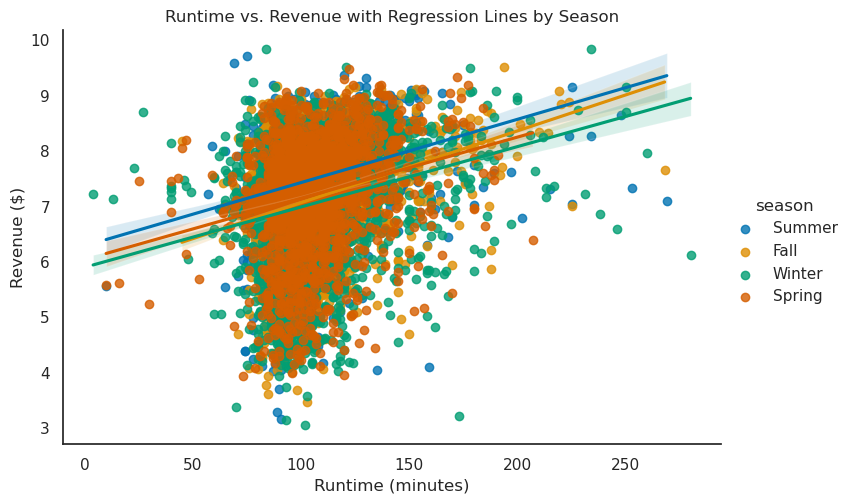

In [ ]:
plt.figure(figsize=(12, 6))
sns.lmplot(
    x="movie_runtime",
    y="log_revenue",
    hue="season",
    data=df_season_filtered,
    aspect=1.5,
)
plt.title("Runtime vs. Revenue with Regression Lines by Season")
plt.xlabel("Runtime (minutes)")
plt.ylabel("Revenue ($)")
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

   - The scatter plot shows the relationship between the movie runtime and the box office revenue, where the movies are categorized by the season in which they were released.
   - Regression lines are added for each season, showing the trend or slope for each season’s data points. The lines indicate if there is a positive, negative, or negligible correlation between runtime and revenue for each season.
   - Positive Slope: Implies that movies with longer runtimes tend to generate higher revenue in that season.
   - Negative Slope: Suggests that shorter movies tend to have higher revenue in that season.
   - Flat or Near-Zero Slope: Indicates little to no relationship between runtime and revenue for that season.


</div>

#### Average Movie Revenue by Release Day of the Week

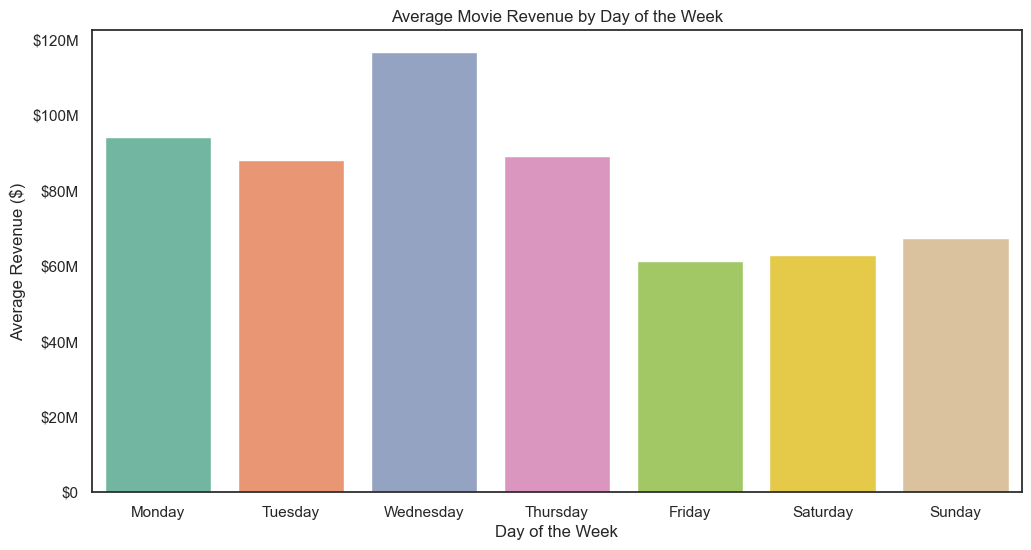

In [4]:
# convert release date to datetime
df_season["movie_release_date"] = pd.to_datetime(
    df_season["movie_release_date"], errors="coerce"
)

# extract day of the week
df_season["release_dayofweek"] = df_season["movie_release_date"].dt.day_name()

day_revenue = (
    df_season.groupby("release_dayofweek")["inflated_revenue"].mean().reset_index()
)
day_order = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]

plt.figure(figsize=(12, 6))
sns.barplot(
    x="release_dayofweek",
    y="inflated_revenue",
    data=day_revenue,
    order=day_order,
    palette="Set2",
)
plt.title("Average Movie Revenue by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Average Revenue ($)")
plt.gca().yaxis.set_major_formatter(revenue_formatter)
plt.show()

#### Genre Popularity Over Time

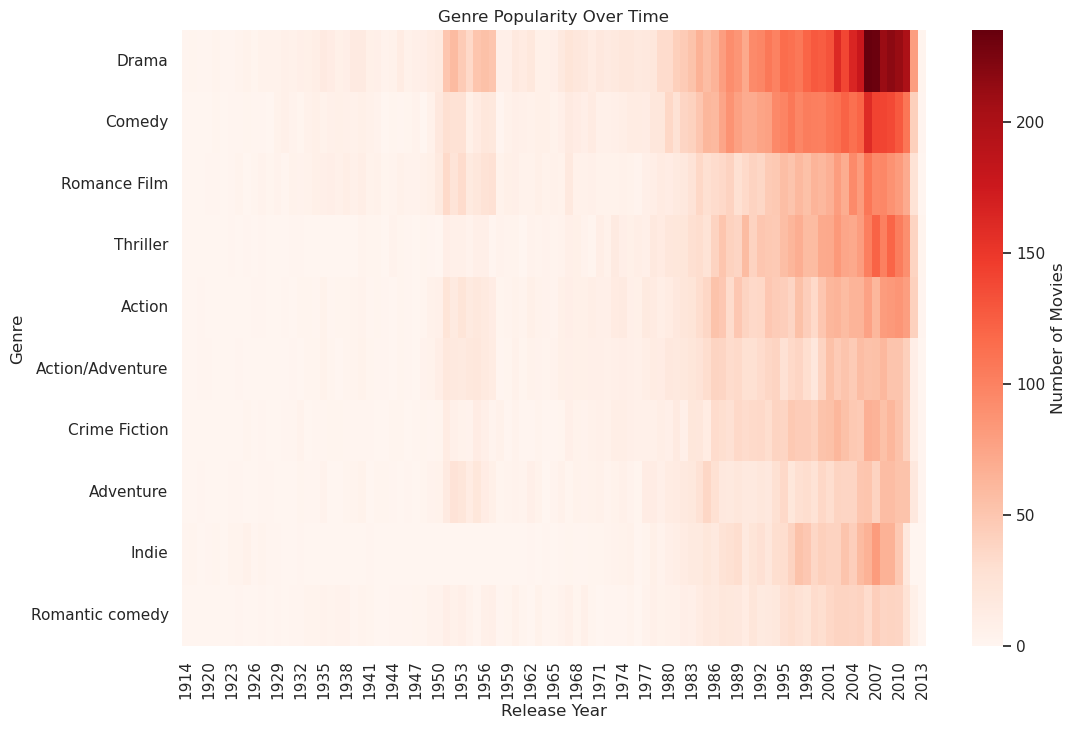

In [ ]:
# count of genres per year
genre_year = (
    df_genres_and_season.groupby(["movie_genres", "release_year"])
    .size()
    .reset_index(name="count")
)

# convert release year to integer
genre_year["release_year"] = genre_year["release_year"].astype(int)

# pivot table
genre_year_pivot = genre_year.pivot_table(
    values="count", index="movie_genres", columns="release_year", fill_value=0
)

# select top 10 genres
top_genres_list = (
    df_genres_and_season["movie_genres"].value_counts().head(10).index.tolist()
)
genre_year_pivot = genre_year_pivot.loc[top_genres_list]

plt.figure(figsize=(12, 8))
sns.heatmap(genre_year_pivot, cmap="Reds", cbar_kws={"label": "Number of Movies"})
plt.title("Genre Popularity Over Time")
plt.xlabel("Release Year")
plt.ylabel("Genre")
plt.show()

#### Genre Popularity by Season

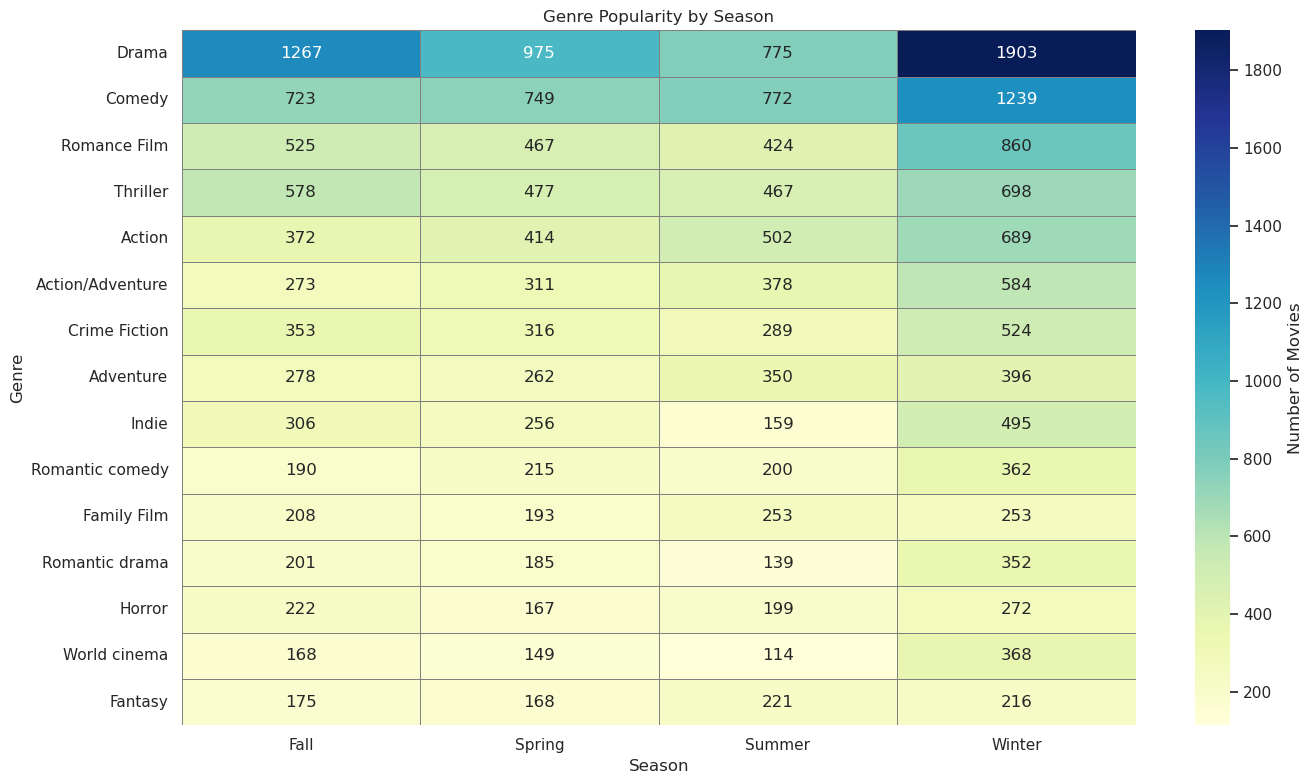

In [ ]:
genre_season_count = (
    df_genres_and_season.groupby(["season", "movie_genres"])
    .size()
    .reset_index(name="movie_count")
)

# create pivot table
pivot_table = genre_season_count.pivot_table(
    values="movie_count",
    index="movie_genres",
    columns="season",
    aggfunc="sum",
    fill_value=0,
)

# select top genres overall
top_genres_overall = (
    df_genres_and_season["movie_genres"].value_counts().head(15).index.tolist()
)
pivot_table = pivot_table.loc[top_genres_overall]

plt.figure(figsize=(14, 8))
sns.heatmap(
    pivot_table,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    linewidths=0.5,
    linecolor="gray",
    cbar_kws={"label": "Number of Movies"},
)
plt.title("Genre Popularity by Season")
plt.xlabel("Season")
plt.ylabel("Genre")
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - Drama movies are popular in all seasons. 

</div>

### Statistical Analysis

<div class="alert alert-success">

  💭 <strong>Idea:</strong>
  - Understand the revenue distributions based on the seasons and genres.
  
</div>
<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>
  - ANOVA analysis
  - Box plots

</div>

#### ANOVA for Seasons

In [ ]:
# convert the string representation to an actual list
df_season["movie_genres"] = df_season["movie_genres"].apply(ast.literal_eval)

# extract genre names
df_season["movie_genres"] = df_season["movie_genres"].apply(
    lambda x: [genre[1] for genre in x]
)

# for simplicity, we'll focus on the primary genre (first in the list)
df_season["primary_genre"] = df_season["movie_genres"].apply(
    lambda x: x[0] if len(x) > 0 else np.nan
)

# drop rows with missing primary genre
df_season = df_season.dropna(subset=["primary_genre"])

In [ ]:
# create a list of revenues for each season
season_revenues = [
    df_season[df_season["season"] == season]["inflated_revenue"]
    for season in df_season["season"].unique()
]

# perform one-way ANOVA
F_statistic, p_value = f_oneway(*season_revenues)

print("ANOVA Results for Seasons:")
print("F-statistic:", F_statistic)
print("p-value:", p_value)

ANOVA Results for Seasons:
F-statistic: 31.31619243572643
p-value: 3.908405612870064e-20


#### ANOVA for Primary Genres

In [ ]:
# consider top N genres to reduce complexity
top_genres = df_season["primary_genre"].value_counts().head(5).index.tolist()
df_top_genres = df_season[df_season["primary_genre"].isin(top_genres)]

# create a list of revenues for each genre
genre_revenues = [
    df_top_genres[df_top_genres["primary_genre"] == genre]["inflated_revenue"]
    for genre in top_genres
]

# perform one-way ANOVA
F_statistic, p_value = f_oneway(*genre_revenues)
print("\nANOVA Results for Genres:")
print("F-statistic:", F_statistic)
print("p-value:", p_value)


ANOVA Results for Genres:
F-statistic: 25.395160610477028
p-value: 7.81063108134714e-21


#### Revenue Distribution by Season

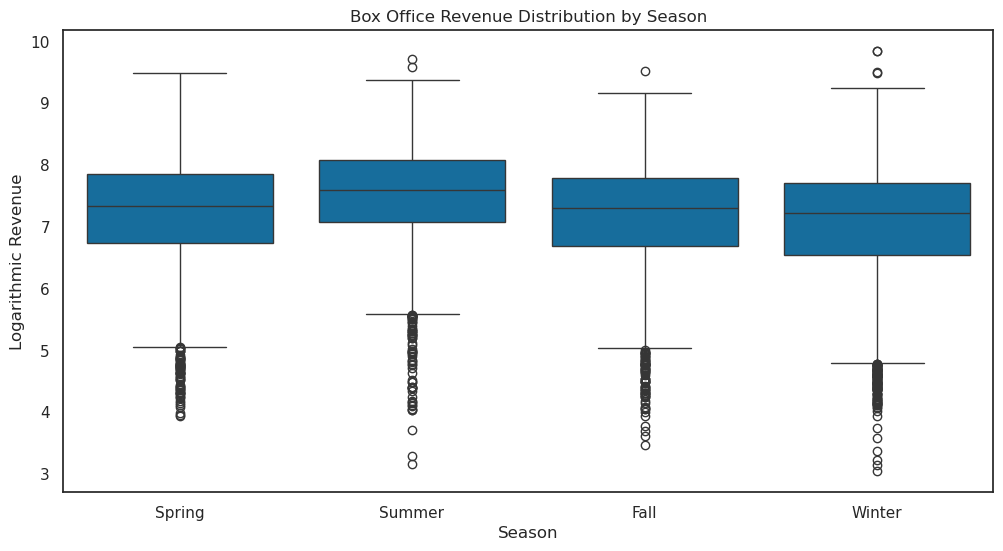

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    x="season",
    y="log_revenue",
    data=df_season,
    order=["Spring", "Summer", "Fall", "Winter"],
)
plt.title("Box Office Revenue Distribution by Season")
plt.xlabel("Season")
plt.ylabel("Logarithmic Revenue")
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

   - Initial observations show that summer season, and thriller and adventure movies have the highest revenues.

</div>

# Movie 6: Treasure 💰
## How does a movie’s budget relate to its box office revenue?

This film delves into the relationship between a movie's budget and its box office revenue. It examines the Return on investment (ROI) and analyses how this relationship varies across different genres.

**🏗️ Analysis Structure:**

- **Data Preparation**
  - **Columns:** budget, inflated_budget, inflated_revenue, movie_genres, release_year
  - **Derived Metrics:** ROI, budget_to_revenue_ratio
  - **Missing Data:** Handle missing budget values
  - **Outlier Analysis:** Identify and handle budget/revenue outliers
  
- **Exploratory Analysis**
  - Budget and revenue distributions
  - Historical budget trends
  - ROI patterns by genre
  - Budget threshold analysis
  
- **Statistical Analysis** 
  - Budget-revenue correlations
  - Genre-specific ROI analysis
  - Multiple regression models
  - Budget optimization insights

- **Key Visualizations**
  - Budget vs Revenue scatter plots
  - ROI distribution analysis
  - Genre-specific budget patterns
  - Historical budget trends

### Data Preparation

#### Relevant Columns
For this analysis, we’ll focus on the following columns:
*	`inflated_budget`: The budget adjusted for inflation.
*	`inflated_revenue`: The box office revenue adjusted for inflation.
*	`release_year`: The year the movie was released.
*   `movie_genres`: The genres of the movie.

We will also create:
- `ROI`: (`inflated_revenue` - `inflated_budget`) / `inflated_budget`, representing the return on investment.

In [11]:
# data preparation: select necessary columns, drop missing values, handle duplicates, create ROI column
df_budget = prepare_df_for_budget_analysis(df)
df_budget.head()

movie_name  inflated_budget  inflated_revenue  release_year  \
0            Ghosts of Mars     3.795294e+07      1.899115e+07          2001   
1  Alexander's Ragtime Band     3.406370e+07      6.131466e+07          1938   
2                   Henry V     1.742456e+07      1.967252e+07          1989   
3              Mary Poppins     4.642804e+07      7.913870e+08          1964   
5                  Baby Boy     2.168739e+07      3.982571e+07          2001   

                                         genres_list  log_revenue  log_budget  \
0  [Thriller, Science Fiction, Horror, Adventure,...     7.278551    7.579245   
1                 [Musical, Comedy, Black-and-white]     7.787564    7.532292   
2  [Costume drama, War film, Epic, Period piece, ...     7.293860    7.241162   
3  [Children's/Family, Musical, Fantasy, Comedy, ...     8.898389    7.666780   
5              [Crime Fiction, Drama, Coming of age]     7.600164    7.336207   

         ROI  
0  -0.499613  
1   0.800000  
2   0.129011  
3  16.045454  
5   0.836353

### Exploratory Data Analysis (EDA)

<div class="alert alert-success"> 💭 <strong>Idea:</strong> 

 - Examine how budgets and revenues are distributed.  
 - Check trends over time.  
 - Understand ROI and see if high budgets always mean higher returns.  
 - Explore how these relationships vary by genre.
</div> <div class="alert alert-warning"> 🛠️ <strong>Methods:</strong>

 - Use histograms and box plots to visualize budget and revenue distributions.
 - Analyze budget trends over time.

#### Summary Statistics

In [13]:
df_budget[["inflated_budget", "inflated_revenue", "ROI"]].describe()

inflated_budget  inflated_revenue          ROI
count     4.406000e+03      4.406000e+03  4406.000000
mean      4.313721e+07      1.323322e+08     5.426125
std       4.949749e+07      2.766360e+08    66.730760
min       2.893850e+03      1.956853e+03    -0.999790
25%       1.204503e+07      1.535224e+07    -0.216270
50%       2.840616e+07      4.996695e+07     0.964592
75%       5.761574e+07      1.451063e+08     3.066244
max       1.280622e+09      6.941575e+09  4142.984983

#### Distribution of Budgets and Revenues

The distributions are heavily skewed, making log transformations appropriate for correlation and regression analyses.

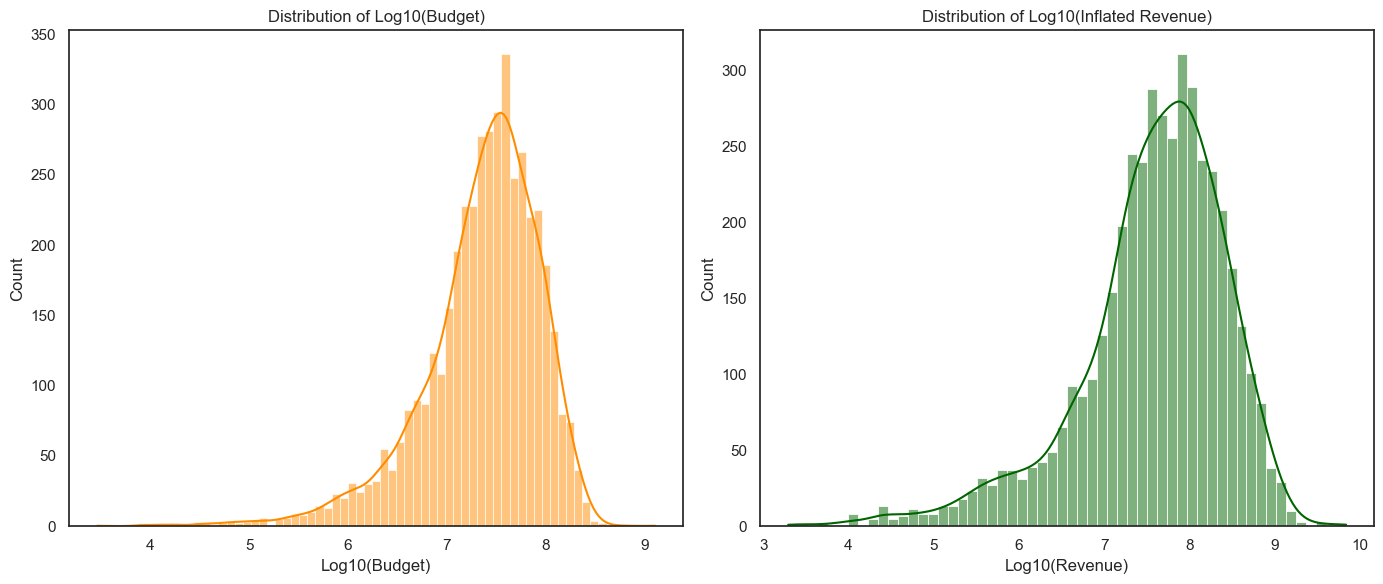

In [14]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(np.log10(df_budget["inflated_budget"]), kde=True, color="darkorange")
plt.title("Distribution of Log10(Budget)")
plt.xlabel("Log10(Budget)")

plt.subplot(1, 2, 2)
sns.histplot(np.log10(df_budget["inflated_revenue"]), kde=True, color="darkgreen")
plt.title("Distribution of Log10(Inflated Revenue)")
plt.xlabel("Log10(Revenue)")

plt.tight_layout()
plt.show()

#### Budget Trends Over Time

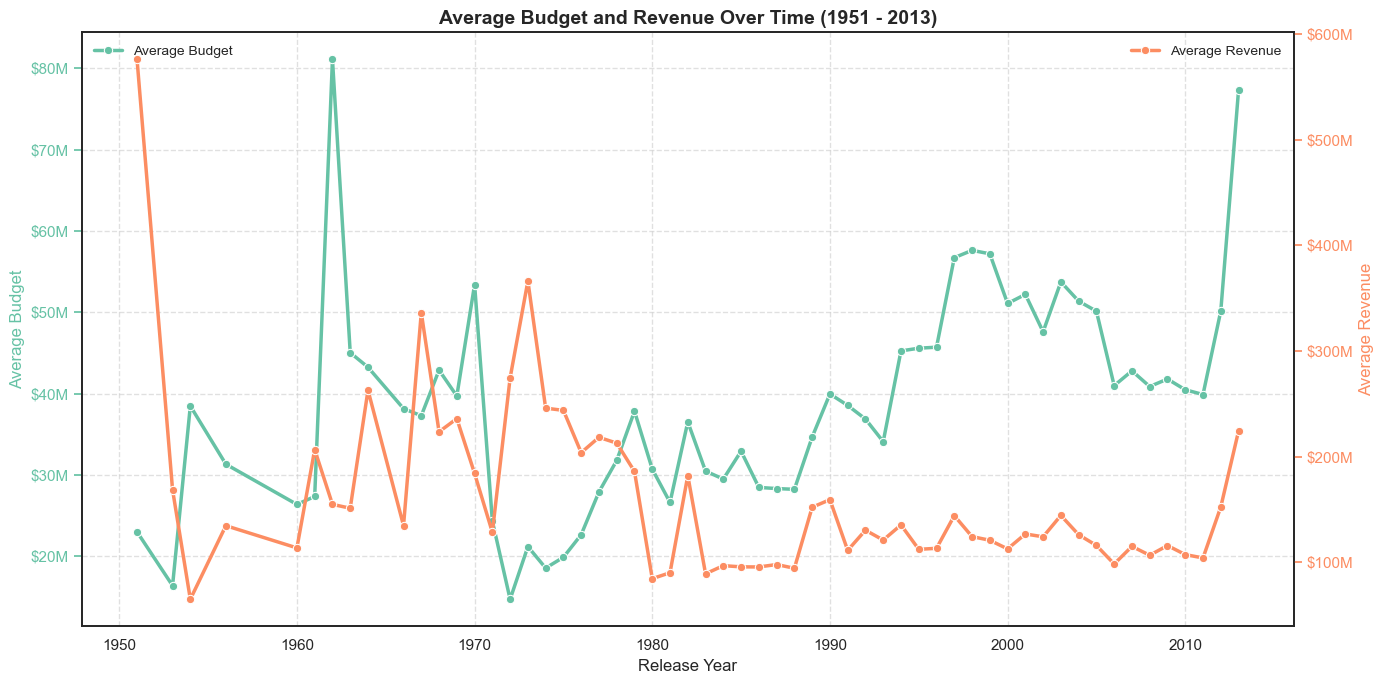

In [15]:
# plot the budget - revenue trend over time (for years with at least 10 movies for reliable statistics)
plot_budget_revenue_trend(df_budget, min_movies=10)

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - Till the late 1970s, the ratio of revenue to budget fluctuates. After 1980s, while budgets be steady, revenues increase, leading to a widening gap. 
  - The post-2010 spike in budgets might be due to the industry’s focus on high-cost blockbusters.

</div>

#### ROI Analysis

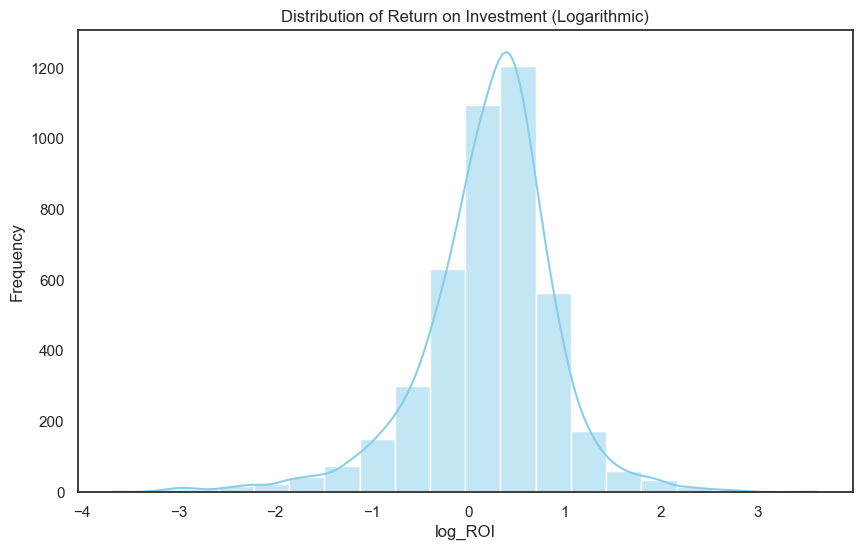

In [16]:
df_budget["log_ROI"] = np.log10(df_budget["ROI"] + 1)

# filter extreme values (potential incorrect data)
df_budget = df_budget[(df_budget["log_ROI"] > -5) & (df_budget["log_ROI"] < 5)]

plot_distribution(
    df_budget, "log_ROI", title="Distribution of Return on Investment (Logarithmic)"
)

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - We can see that some movies have a very high ROI (outliers) (even after applying log10). We will investigate this further below.

</div>

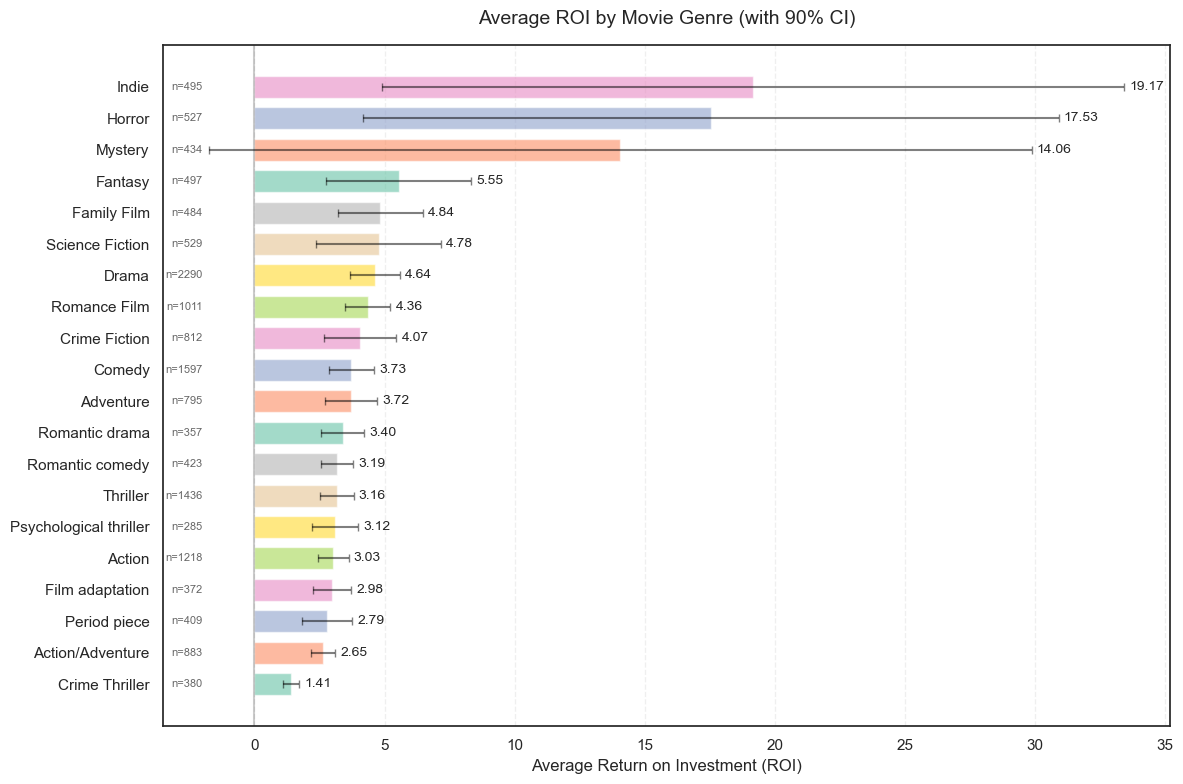

In [17]:
# Data preparation
df_budget_exploded = df_budget.explode("genres_list")

# Calculate statistics per genre
genre_stats = (
    df_budget_exploded.groupby("genres_list")
    .agg({"ROI": ["mean", "std", "count"]})
    .reset_index()
)
genre_stats.columns = ["genre", "mean_roi", "std_roi", "count"]

# Calculate confidence intervals (95%)
genre_stats["ci"] = 1.645 * (genre_stats["std_roi"] / np.sqrt(genre_stats["count"]))

# Get top 20 genres by count
top_20_genress = genre_stats.nlargest(20, "count").sort_values(
    "mean_roi", ascending=True
)

# Create figure
plt.figure(figsize=(12, 8))

# Create bar plot
bars = plt.barh(
    y=range(len(top_20_genress)),
    width=top_20_genress["mean_roi"],
    height=0.7,
    color=sns.color_palette("Set2", len(top_20_genress)),
    alpha=0.6,
)

# Add error bars
plt.errorbar(
    x=top_20_genress["mean_roi"],
    y=range(len(top_20_genress)),
    xerr=top_20_genress["ci"],
    fmt="none",
    color="black",
    capsize=3,
    alpha=0.5,
)

# Customize plot
plt.yticks(range(len(top_20_genress)), top_20_genress["genre"])
plt.xlabel("Average Return on Investment (ROI)", fontsize=12)
plt.title("Average ROI by Movie Genre (with 90% CI)", fontsize=14, pad=15)

# Add value annotations
for i, bar in enumerate(bars):
    plt.text(
        bar.get_width() + top_20_genress["ci"].iloc[i] + 0.2,
        bar.get_y() + bar.get_height() / 2,
        f'{top_20_genress["mean_roi"].iloc[i]:.2f}',
        va="center",
        ha="left",
        fontsize=10,
    )

# Add count annotations
for i, count in enumerate(top_20_genress["count"]):
    plt.text(-2, i, f"n={count}", va="center", ha="right", fontsize=8, alpha=0.7)

# Styling
plt.grid(axis="x", linestyle="--", alpha=0.3)
plt.axvline(x=0, color="black", alpha=0.2)

plt.tight_layout()
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - Horror and Indie films have the highest average ROI but also exhibit the largest confidence intervals. This suggests that while they can deliver exceptional returns, their performance is highly variable.
  - Fantasy and Family films balance moderate ROI with lower variability, as indicated by their narrower confidence intervals. These genres may offer more reliable returns, appealing to studios looking for safer, less volatile investments.
  - Genres like Action/Adventure and Crime Thriller show both low average ROI and relatively smaller confidence intervals. This suggests they consistently underperform, potentially due to high production costs or a saturated market.
</div>

In [18]:
# 5 movies with the highest ROI and their genres
top_5_roi_movies = df_budget.nlargest(5, "ROI")
top_5_roi_movies[
    ["movie_name", "genres_list", "inflated_budget", "inflated_revenue", "ROI"]
]

movie_name  \
3997  The Blair Witch Project   
7422               Eraserhead   
5438           Pink Flamingos   
308     The Birth of a Nation   
4630            Super Size Me   

                                            genres_list  inflated_budget  \
3997  [Horror, Indie, Supernatural, Cult, Mystery, A...     8.645013e+04   
7422  [Science Fiction, Horror, Indie, Experimental ...     3.959970e+04   
5438  [Crime Fiction, Horror, Gross-out film, Gay, C...     6.887412e+04   
308   [Silent film, Indie, Costume drama, Epic, Blac...     2.374350e+06   
4630  [Culture & Society, Business, Indie, Drama, Co...     8.259313e+04   

      inflated_revenue          ROI  
3997      3.582480e+08  4142.984983  
7422      2.771979e+07   699.000000  
5438      4.017657e+07   582.333333  
308       1.187175e+09   499.000000  
4630      3.811991e+07   460.538462

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - As it is shown on the table above, the 5 movies with the highest ROI are all from either the Horror or Indie genre. This suggests that these genres have the potential to deliver exceptional returns.
  - As an extraordinary example, the movie "The Blair Witch Project" had a budget of $60,000 and a revenue of $250,000,000 (these values are before inlation adjustment), resulting in an ROI of ~4143.
</div>

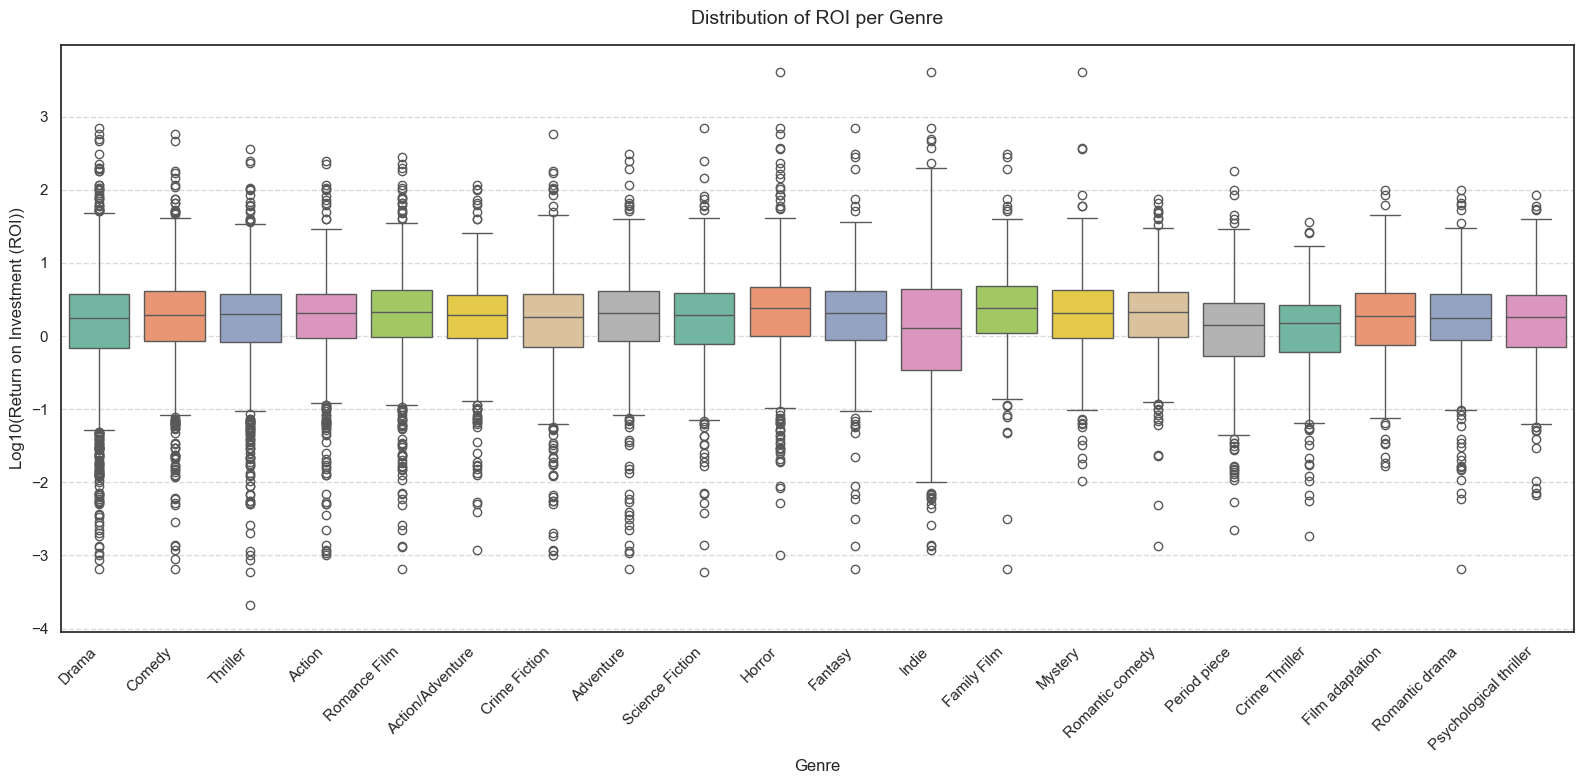

In [19]:
# Explode the genres list to create one row per genre-movie combination
df_budget_exploded = df_budget.explode("genres_list")

# Filter for top 20 genres
genre_counts = df_budget_exploded["genres_list"].value_counts()
top_20_genres = genre_counts.head(20).index.tolist()
df_budget_filtered = df_budget_exploded[
    df_budget_exploded["genres_list"].isin(top_20_genres)
]

df_budget_filtered["log_ROI"] = np.log10(df_budget_filtered["ROI"] + 1)

# Create the boxplot
plt.figure(figsize=(16, 8))
sns.boxplot(
    x="genres_list",
    y="log_ROI",
    data=df_budget_filtered,
    palette="Set2",
    order=top_20_genres,
)

# Customize the plot
plt.title("Distribution of ROI per Genre", fontsize=14, pad=15)
plt.xlabel("Genre", fontsize=12)
plt.ylabel("Log10(Return on Investment (ROI))", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - Many movies have a negative ROI, meaning that their revenue was smaller than their budget.
  - Some genres, as for example Horror, have a very high ROI in some cases, and in general their ROI is higher than others.
  - The ROI distribution for most genres seems to be highly skewed. 
</div>

#### Distribution of Budget per Genre

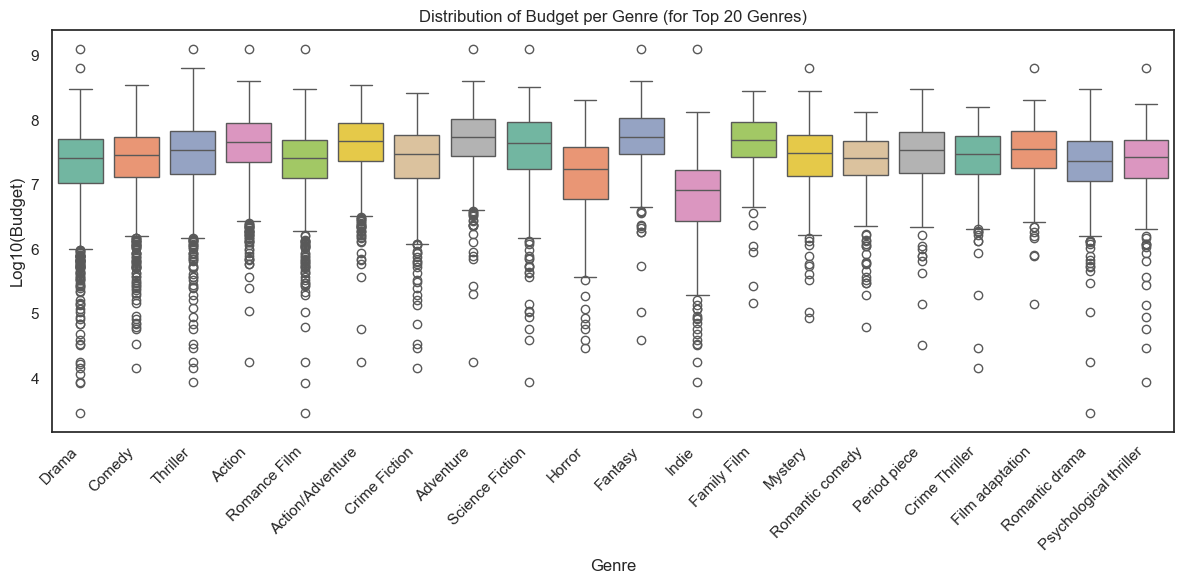

In [20]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    x="genres_list",
    y="log_budget",
    data=df_budget_filtered,
    palette="Set2",
    order=top_20_genres,
)
plt.title("Distribution of Budget per Genre (for Top 20 Genres)")
plt.ylabel("Log10(Budget)")
plt.xlabel("Genre")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - Horror and Indie films have the lowest budgets on average, with a wide range, suggesting they often operate on smaller scales but occasionally receive larger investments. This aligns with their high ROI potential but also highlights their variability.
  - Action, Science Fiction, and Fantasy genres tend to have the highest average budgets, as seen from their elevated median and upper ranges. These genres likely demand significant resources for special effects, set design, and large-scale production.
</div>

#### Revenue to Budget Ratio Analysis

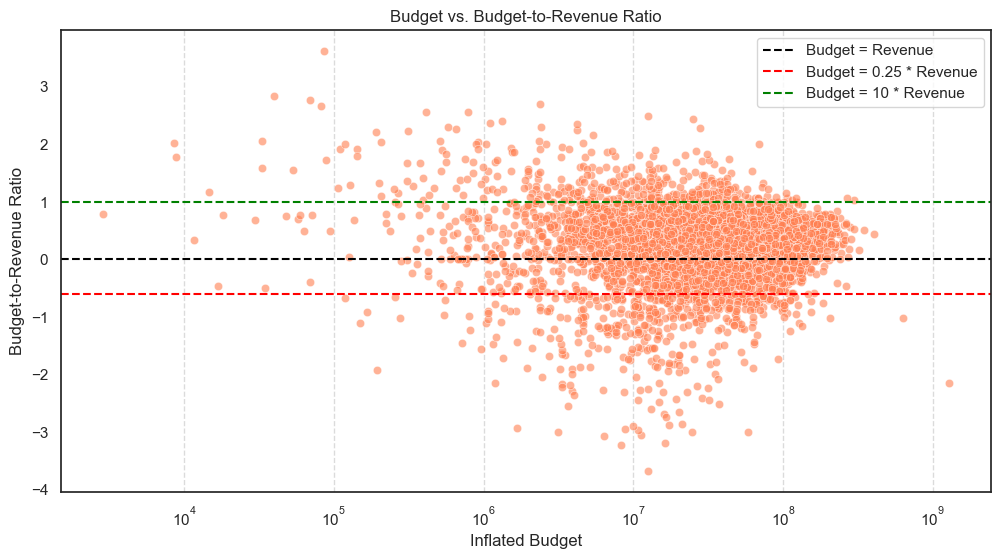

In [23]:
# budget vs revenue-budget ratio
df_budget["log_revenue_to_budget_ratio"] = np.log10(
    df_budget["inflated_revenue"] / df_budget["inflated_budget"]
)


plt.figure(figsize=(12, 6))
sns.scatterplot(
    x="inflated_budget",
    y="log_revenue_to_budget_ratio",
    data=df_budget,
    alpha=0.6,
    color="coral",
)
plt.title("Budget vs. Budget-to-Revenue Ratio")
plt.xlabel("Inflated Budget")
plt.ylabel("Budget-to-Revenue Ratio")
plt.xscale("log")  # Use log scale for better visualization
plt.grid(axis="x", linestyle="--", alpha=0.7)

# add horizontal lines to highlight different thresholds
plt.axhline(y=0, color="black", linestyle="--", linewidth=1.5, label="Budget = Revenue")
plt.axhline(
    y=np.log10(0.25),
    color="red",
    linestyle="--",
    linewidth=1.5,
    label="Budget = 0.25 * Revenue",
)
plt.axhline(
    y=np.log10(10),
    color="green",
    linestyle="--",
    linewidth=1.5,
    label="Budget = 10 * Revenue",
)
plt.legend()
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>
  
  - Most movies with lower budgets have a higher revenue-to-budget ratio, which suggests that it is more likely to times your budget with a smaller number to get the revenue in the film industry.
  - Most movies reside in the 0-10 range, which means that it is unlikely to get extremely high spikes in revenue compared to the budget.
</div>

### Statistical Analysis

<div class="alert alert-success"> 💭 <strong>Idea:</strong> 

 - Determine the strength and direction of the relationship between budget and revenue. 
 - Identify if higher budget movies result in higher revenues, and if this varies by genre. 
 - Predict box office revenue based on movie budget.
 </div> 
<div class="alert alert-warning"> 🛠️ <strong>Methods:</strong> 

 - Calculate the Pearson and Spearman correlation coefficients between budget and revenue, both on the full data set and for each genre individually.
 - Use linear regression to model the relationship between log-transformed budget and log-transformed box office revenue.
 </div>

#### Correlation Analysis

In [24]:
# Pearson correlation between log-transformed budget and revenue
corr_pearson = df_budget[["log_budget", "log_revenue"]].corr(method="pearson")
print("Pearson Correlation Coefficient:")
print(corr_pearson)

# spearman correlation between log-transformed budget and revenue
corr_spearman = df_budget[["log_budget", "log_revenue"]].corr(method="spearman")
print("\nSpearman Correlation Coefficient:")
print(corr_spearman)

Pearson Correlation Coefficient:
             log_budget  log_revenue
log_budget     1.000000     0.623765
log_revenue    0.623765     1.000000

Spearman Correlation Coefficient:
             log_budget  log_revenue
log_budget     1.000000     0.640116
log_revenue    0.640116     1.000000


<div class="alert alert-info">
  💡 <strong>Discussion:</strong>
  - The correlation between log-transformed budget and revenue is 0.623 (Pearson) and 0.640 (Spearman), indicating an important positive relationship.
</div>

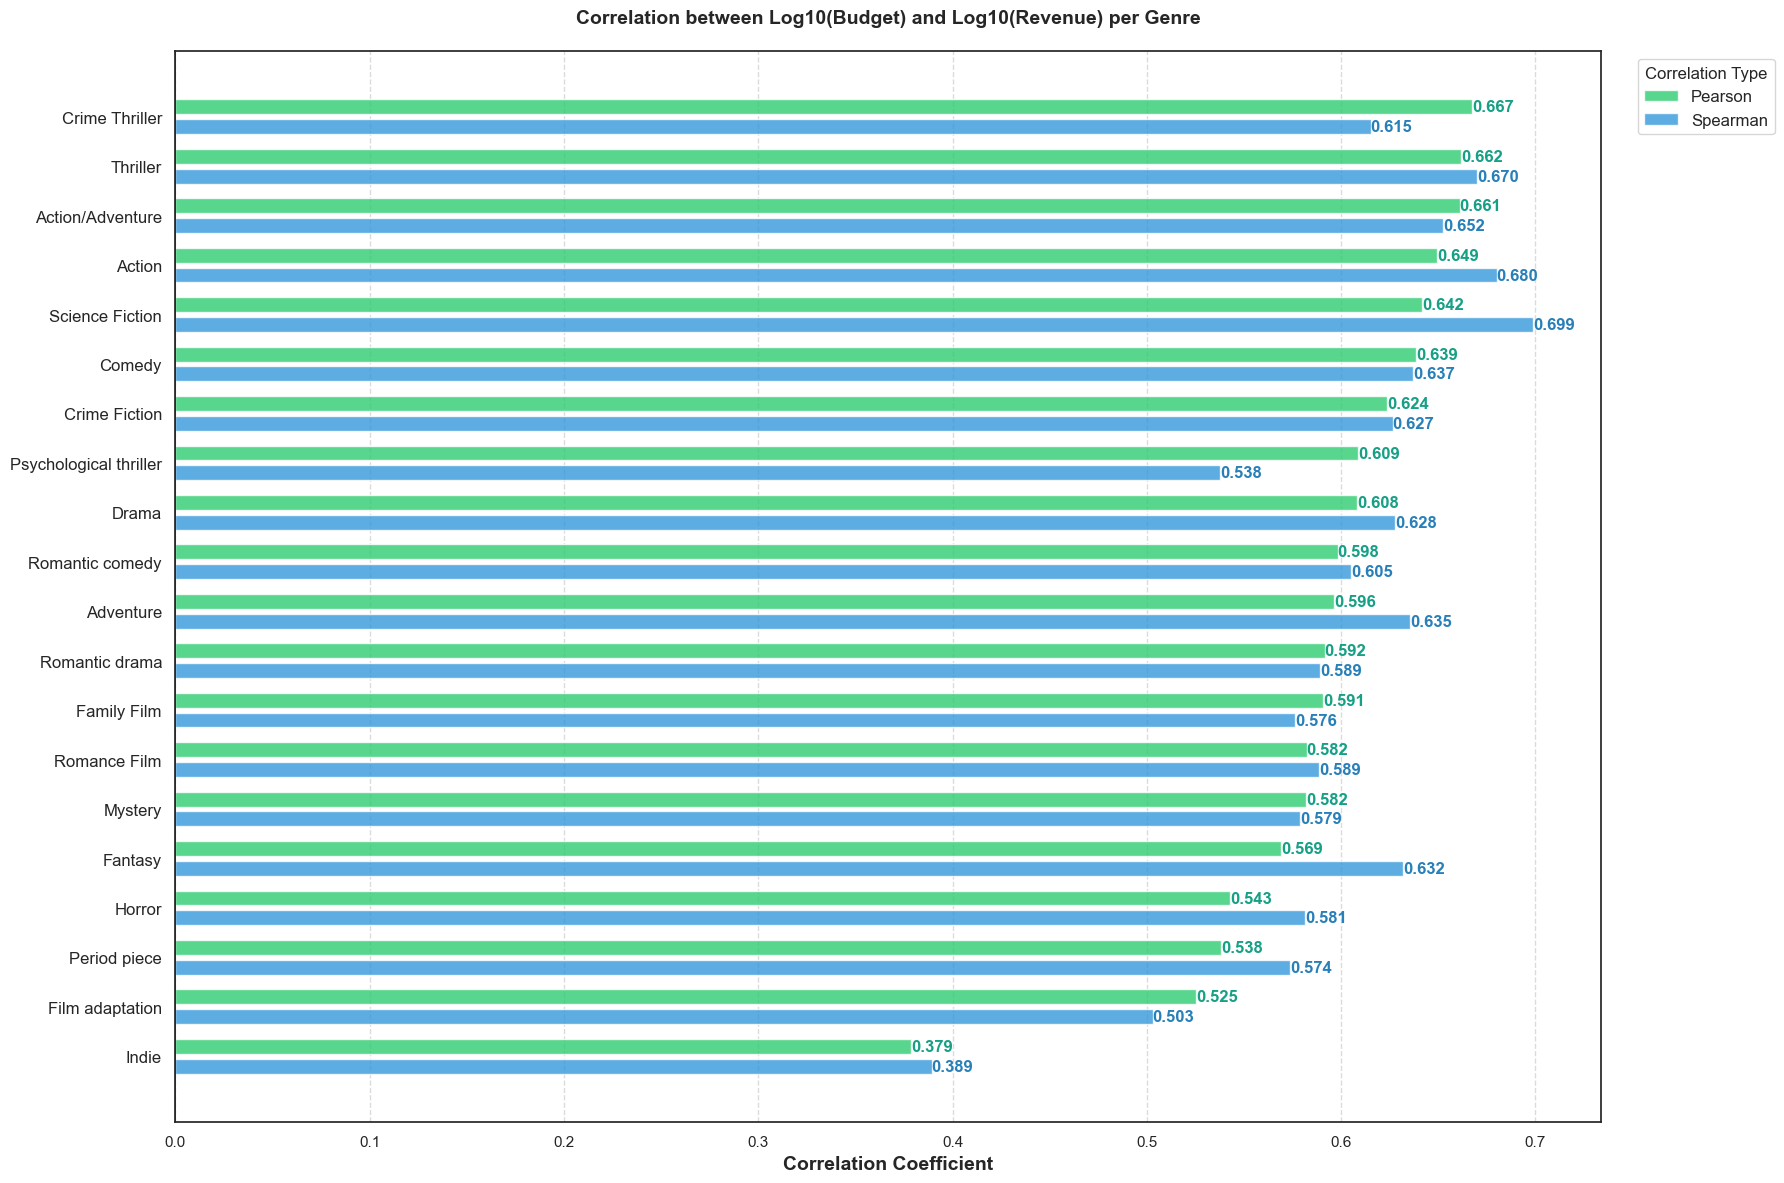

In [25]:
# calculate the correlation for each genre
genre_corrs = []
for genre in top_20_genres:
    df_budget_genre = df_budget[
        df_budget["genres_list"].apply(lambda x: genre in x)
    ]  # filter for movies that contain that genre
    if len(df_budget_genre) > 0:  # only proceed if there are movies in this genre
        corr_pearson = (
            df_budget_genre[["inflated_budget", "inflated_revenue"]]
            .apply(np.log10)
            .corr(method="pearson")
        )  # calculate pearson correlation
        corr_spearman = (
            df_budget_genre[["inflated_budget", "inflated_revenue"]]
            .apply(np.log10)
            .corr(method="spearman")
        )  # calculate spearman correlation
        genre_corrs.append(
            {
                "Genre": genre,
                "Pearson": corr_pearson.iloc[0, 1],  # take the correlation
                "Spearman": corr_spearman.iloc[0, 1],  # take the correlation
            }
        )

genre_corrs = pd.DataFrame(genre_corrs)
genre_corrs.set_index("Genre", inplace=True)

plot_genre_correlation_bars(
    genre_corrs,
    title="Correlation between Log10(Budget) and Log10(Revenue) per Genre",
)
# # sort by pearson
# genre_corrs.sort_values(by="Pearson", ascending=False)

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - Correlations between budget and revenue mostly show similar values across genres.
  - The correlation between budget and revenue is highest for Crime Thriller and lowest for Indie movies for the Top 20 genres.
</div>

#### Budget vs Revenue Log-Log Scatter Plot

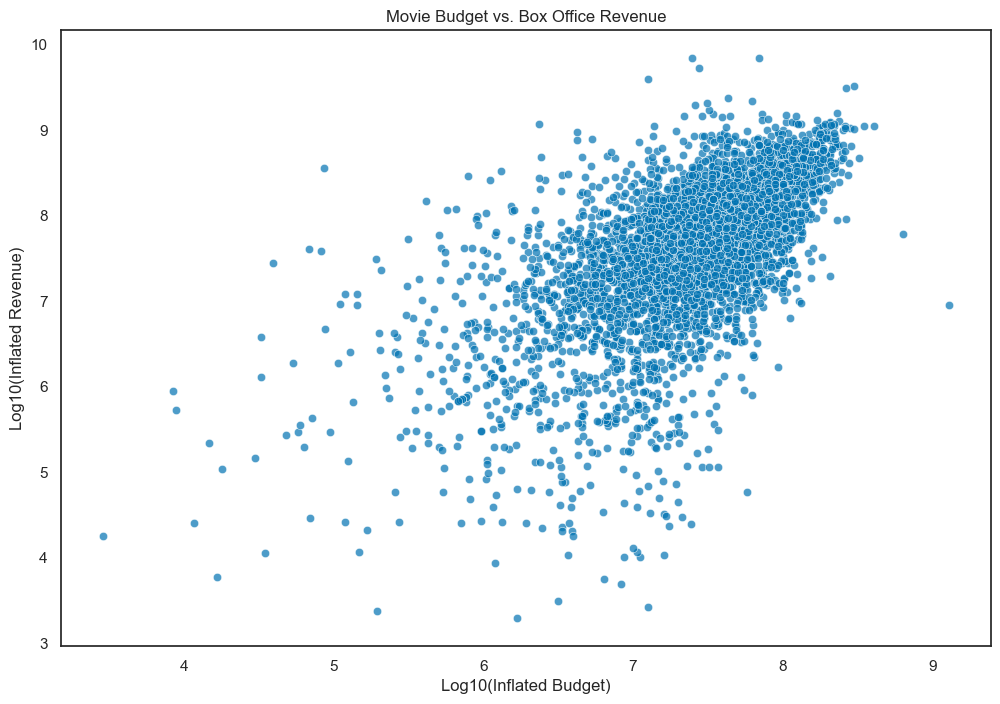

In [26]:
plot_scatter(
    df_budget,
    x="log_budget",
    y="log_revenue",
    title="Movie Budget vs. Box Office Revenue",
    xlabel="Log10(Inflated Budget)",
    ylabel="Log10(Inflated Revenue)",
)

As can be seen in the scatter plot, it is hard to see the density of the points. A hexbin plot might be better.

<Figure size 1200x800 with 0 Axes>

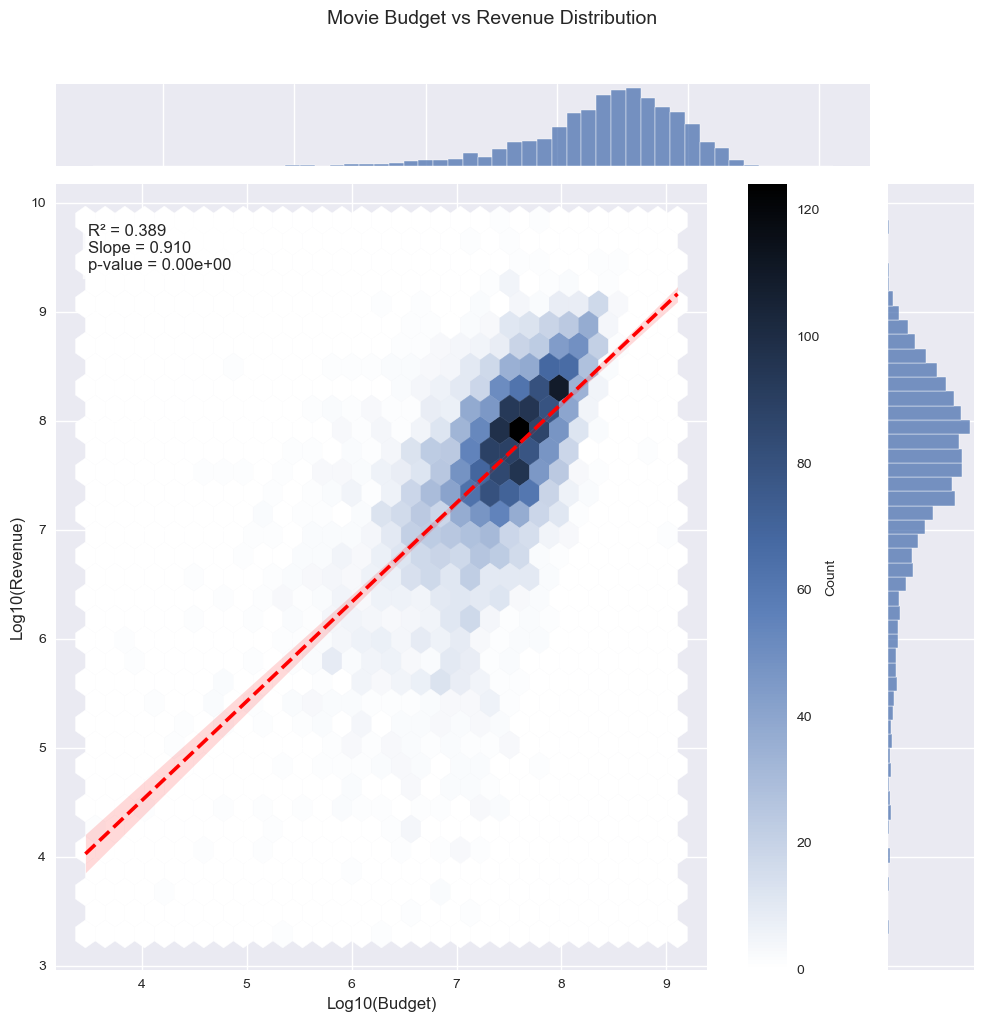

In [27]:
# Set style and figure size
plt.style.use("seaborn-v0_8")
plt.figure(figsize=(12, 8))

# Create joint plot with improved hexbin
g = sns.jointplot(
    data=df_budget,
    x="log_budget",
    y="log_revenue",
    kind="hex",
    height=10,
    joint_kws={"gridsize": 30},
    marginal_kws={"bins": 50},
    ratio=8,
)

# Add regression line with confidence interval
sns.regplot(
    data=df_budget,
    x="log_budget",
    y="log_revenue",
    scatter=False,
    color="red",
    line_kws={"linestyle": "--"},
    ax=g.ax_joint,
)

# Calculate statistics
slope, intercept, r_value, p_value, std_err = stats.linregress(
    df_budget["log_budget"], df_budget["log_revenue"]
)

# Add statistical annotations
stats_text = (
    f"R² = {r_value**2:.3f}\n" f"Slope = {slope:.3f}\n" f"p-value = {p_value:.2e}"
)

g.ax_joint.text(
    0.05,
    0.95,
    stats_text,
    transform=g.ax_joint.transAxes,
    bbox=dict(facecolor="white", alpha=0.8),
    verticalalignment="top",
)

# Customize aesthetics
g.fig.suptitle("Movie Budget vs Revenue Distribution", y=1.02, fontsize=14)
g.ax_joint.set_xlabel("Log10(Budget)", fontsize=12)
g.ax_joint.set_ylabel("Log10(Revenue)", fontsize=12)

# Add colorbar with proper label
cbar = g.fig.colorbar(g.ax_joint.collections[0], ax=g.ax_joint)
cbar.set_label("Count", fontsize=10)

# Adjust layout
plt.tight_layout()
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - The hexbin plot provides a better view of data density and confirms the strong positive correlation between budget and revenue.
</div>

#### Regression Analysis

In [28]:
X = df_budget["log_budget"]
Y = df_budget["log_revenue"]

# add constant to the independent variable
X = sm.add_constant(X)

# fit the model
model = sm.OLS(Y, X).fit()

# model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_revenue   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     2805.
Date:                Fri, 20 Dec 2024   Prob (F-statistic):               0.00
Time:                        21:54:21   Log-Likelihood:                -4581.5
No. Observations:                4406   AIC:                             9167.
Df Residuals:                    4404   BIC:                             9180.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8753      0.127      6.902      0.000       0.627       1.124
log_budget     0.9102      0.017     52.961      0.000       0.876       0.944
==============================================================================
Omnibus:                      796.601   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2432.535
Skew:                          -0.929   Prob(JB):                         0.00
Kurtosis:                       6.130   Cond. No.                         92.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - Very strong positive relationship between budget and revenue (coefficient = 0.91), indicating that a 1% increase in log(budget) corresponds to approximately 0.91% increase in log(revenue), with high statistical significance (p < 0.001).

  - The model explains about 39% of the variance in movie revenues (R-squared = 0.389), so it suggests that while budget is an important predictor, other factors also significantly influence movie revenue.
</div>